# From RAGs to Riches: How Search and Q&A Capabilities with RAG can Accelerate Engineering and Marketing Workflows

This is a POC of a RAG system for a hypothetical tech company. The company is looking for new ways to organize their question answering and search capabilities to accelerate both product engineering activity (for an engineering team of ~300 people) and marketing initiatives (for a marketing/support staff department of ~40 people).

##1. Notebook Setup

Install and import needed libraries.

In [ ]:
%%capture
!pip -q install git+https://github.com/huggingface/transformers
!pip install -q datasets loralib sentencepiece
!pip -q install bitsandbytes accelerate
!pip -q install langchain
!pip install einops
!pip install faiss-gpu
!pip install --upgrade --quiet  langchain-community chromadb bs4 qdrant-client
!pip install langchainhub

!pip install --upgrade --quiet  wikipedia
!pip install --upgrade --quiet  arxiv
!pip install --upgrade --quiet  pymupdf

!pip install xmltodict

!pip install cohere

!pip install -U langchain-cohere
!pip install evaluate
!pip install rouge-score
!pip install bert_score
!pip install ragas


In [ ]:
import torch
import os
import bs4
import json
import numpy as np
import time

from pprint import pprint

import locale

from transformers import AutoTokenizer , AutoModelForCausalLM
from transformers import pipeline, BitsAndBytesConfig

from langchain.llms import HuggingFacePipeline
from langchain import PromptTemplate, LLMChain
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_text_splitters import CharacterTextSplitter
from langchain_core.output_parsers import StrOutputParser
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS
from langchain_community.vectorstores import Chroma
from langchain_community.vectorstores import Qdrant
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.utils.math import cosine_similarity

from langchain_community.document_loaders import ArxivLoader
from langchain_community.document_loaders import TextLoader
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.document_loaders import OnlinePDFLoader
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_community.document_loaders import PubMedLoader

from google.colab import userdata

from langchain_cohere import ChatCohere
import pandas as pd
from pandas import ExcelWriter
from matplotlib import pyplot as plt
import re
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
import evaluate
import spacy
from bert_score import BERTScorer
from datasets import Dataset
from ragas import evaluate as ragas_evaluate
from ragas.metrics import (
    context_precision,
    context_recall,
    faithfulness,
    answer_relevancy,
    answer_correctness,
)
import plotly.graph_objects as go


In [ ]:
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
%%capture
!pip install sentence_transformers

In [ ]:
from sentence_transformers import SentenceTransformer, util

In [ ]:
pd.set_option('display.max_columns', 50)

In [ ]:
COHERE_API_KEY = userdata.get('COHERE_API_KEY')
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

##2. Building and Testing the Components of a RAG System

Introduce and test the base components of a RAG system using Hugging Face and LangChain libraries. This section starts laying the groundwork for the POC model/system.



###2.1 Embedding Model

Represent text as vectors using the sentence_transformer architecture.

Embedding models tested (from Hugging Face):
- 'all-MiniLM-L6-v2'
- 'multi-qa-mpnet-base-dot-v1'
- 'avsolatorio/GIST-Embedding-v0'



In [ ]:
%%capture
base_embeddings = HuggingFaceEmbeddings(model_name="multi-qa-mpnet-base-dot-v1")

In [ ]:
text = "This is a test document."
query_result = base_embeddings.embed_query(text)
print(f'Embedding dimension: {len(query_result)}')

doc_result = base_embeddings.embed_documents([text, "This is not a test document."])
len(doc_result)

Embedding dimension: 768


2

###2.2. Loading and Chunking Texts

Load the documents for the RAG system, starting with just a single example.

In [ ]:
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)

documents = loader.load()

Split the  text into chunks (retrieval units).  


In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=128, chunk_overlap=0)
splits = text_splitter.split_documents(documents)
print('Number of splits/chunks: ', str(len(splits)))

Number of splits/chunks:  444


In [ ]:
splits[39].page_content

'correcting previous mistakes. It plays a crucial role in real-world tasks where trial and error are inevitable.'

###2.3 Storing the Embeddings of Chunks in a Vectorstore

Save vector representations of the chunks in a vectorstore using Qdrant.

In [ ]:
vectorstore = Qdrant.from_documents(splits,
    base_embeddings,
    location=":memory:",  # Local mode with in-memory storage only
    collection_name="test",
)
retriever = vectorstore.as_retriever()

In [ ]:
query = "What is Chain of Thought doing?"
docs = vectorstore.similarity_search_by_vector(base_embeddings.embed_query(query)) # Ranks the splits

In [ ]:
docs

[Document(page_content='the model’s thinking process.', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', '_id': '9a97ca9dd4164b52a8f6da12e433ff26', '_collection_name': 'test'}),
 Document(page_content='[1] Wei et al. “Chain of thought prompting elicits reasoning in large language models.” NeurIPS 2022', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', '_id': 'd5f0880f43954f1bb117e56ad81fc31c', '_collection_name': 'test'}),
 Document(page_content='the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', '_id': '64a22c24de54404a881f2158b8b3b653', '_collection_name': 'test'}),
 Document(page_content='Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-2

###2.4. Large Language Model (LLM)

Incorporate an LLM to generate responses to prompts/questions.

LLMs tested (from Hugging Face / Cohere):
- 'mistralai/Mistral-7B-Instruct-v0.1' (Open Source)
- 'ChatCohere' (Proprietary)

In [ ]:
%%capture

quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         llm_int4_enable_fp32_cpu_offload=True)


llm_mistral_model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.1",
    torch_dtype=torch.float32,
    device_map='auto',
    quantization_config=quantization_config
)

llm_mistral_tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")

Unused kwargs: ['llm_int4_enable_fp32_cpu_offload']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


In [ ]:
mistral_pipe = pipeline(
    "text-generation",
    model=llm_mistral_model,
    tokenizer=llm_mistral_tokenizer,
    max_length=1000,
    temperature=0.6,
    top_p=0.95,
    do_sample=True,
    repetition_penalty=1.2
)
mistral_pipe.model.config.pad_token_id = mistral_pipe.model.config.eos_token_id

In [ ]:
mistral_pipe("[INST]Give me a two-sentence story about an apple![/INST]")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': '[INST]Give me a two-sentence story about an apple![/INST] Once upon a time, there was a red apple that fell from the tree. It rolled down the hill and into the hands of a little girl who delighted in biting into its juicy flesh.'}]

###2.5 Testing the LLM in a LangChain Chain

Create a LangChain chain consisting of a prompt template, LLM, and String Formatter.

In [ ]:
mistral_llm_lc = HuggingFacePipeline(pipeline=mistral_pipe)

In [ ]:
test_llm_template = """[INST] Give me a two-sentence story about an {object}! [/INST]"""
test_llm_prompt_template = PromptTemplate(template=test_llm_template, input_variables=["object"])



In [ ]:
test_llm_chain_short = (
    {"object": RunnablePassthrough()}
    | test_llm_prompt_template
    | mistral_llm_lc
)

In [ ]:
test_llm_chain_short.invoke('apple')

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'[INST] Give me a two-sentence story about an apple! [/INST] Once upon a time, there was a bright red apple that grew on a lush tree in the heart of an enchanted orchard. One day, a curious little girl stumbled upon the tree and plucked the apple from its branch, not realizing the magic it held within.'

In [ ]:
cohere_chat_model = ChatCohere(cohere_api_key=COHERE_API_KEY)

In [ ]:
test_cohere_llm_chain_short = (
    {"object": RunnablePassthrough()}
    | test_llm_prompt_template
    | cohere_chat_model
)

In [ ]:
test_cohere_llm_chain_short.invoke('apple')

AIMessage(content="The apple, once bitter and unappealing, fell from the tree and transformed into a sweet, juicy treat. Its once sour notes now a distant memory, it became a symbol of nature's surprising delights.", additional_kwargs={'documents': None, 'citations': None, 'search_results': None, 'search_queries': None, 'is_search_required': None, 'generation_id': 'd702709c-2da1-40d1-aebc-eb7100581ff1'}, response_metadata={'documents': None, 'citations': None, 'search_results': None, 'search_queries': None, 'is_search_required': None, 'generation_id': 'd702709c-2da1-40d1-aebc-eb7100581ff1'}, id='run-d2cb3567-f0c3-4ea8-acb8-6388dc141941-0')

In [ ]:
output_parser = StrOutputParser()

test_cohere_llm_chain_short_formatted = (
    {"object": RunnablePassthrough()}
    | test_llm_prompt_template
    | cohere_chat_model
    | output_parser
)

test_cohere_llm_chain_short_formatted.invoke('apple')

"The apple, once bitter and unappealing, fell from the tree and transformed into a sweet, juicy treat. Its once sour notes now a distant memory, it became a symbol of nature's surprising delights."

###2.6 Setting Up a Simple RAG Chain

Simple test of a RAG template that takes a question and a pre-defined context as input, and generates an answer based on the provided context.

In [ ]:
rag_template = """[INST] Answer the question based only on the following context:
{context}

Question: {question}
[/INST]
"""
rag_prompt_template = ChatPromptTemplate.from_template(rag_template)

base_rag_chain =(
    {"context": RunnablePassthrough(),
     "question": RunnablePassthrough()}
    | rag_prompt_template
    | mistral_llm_lc
    | output_parser
)

predefined_context = "Germany has won the World Cup 4 times."
question = "How many times did Germany win the world cup?"

resp = base_rag_chain.invoke({'context': predefined_context,
                           'question': question})
print(resp)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Human: [INST] Answer the question based only on the following context:
{'context': 'Germany has won the World Cup 4 times.', 'question': 'How many times did Germany win the world cup?'}

Question: {'context': 'Germany has won the World Cup 4 times.', 'question': 'How many times did Germany win the world cup?'}
[/INST]
Answer: Germany won the World Cup 4 times.


Create a simple formatting function that can be used in the chain to combine a list of chunks into one string.



In [ ]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [ ]:
rag_template = """Here is a context:\n{context} \n\nand here is a question: \n{question}"""

rag_prompt = ChatPromptTemplate.from_template(rag_template)

rag_chain = (
    {"context": retriever | format_docs,
     "question": RunnablePassthrough()}
    | rag_prompt


)

In [ ]:
output = rag_chain.invoke('What is Chain of Thought?')

In [ ]:
print(output.messages[0].content)

Here is a context:
the model’s thinking process.

[1] Wei et al. “Chain of thought prompting elicits reasoning in large language models.” NeurIPS 2022

the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process

Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes 

and here is a question: 
What is Chain of Thought?


In [ ]:
output_parser = StrOutputParser()

rag_template = """[INST]Please answer the question below only based on the context information provided.\n\nHere is a context:\n{context} \n\nHere is a question: \n{question}.[/INST]"""
rag_prompt = ChatPromptTemplate.from_template(rag_template)

rag_chain = (
    {"context": retriever | format_docs,
     "question": RunnablePassthrough()}
    | rag_prompt
    | mistral_llm_lc

)



In [ ]:
rag_chain.invoke('What is Chain of Thought?')

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'Human: [INST]Please answer the question below only based on the context information provided.\n\nHere is a context:\nthe model’s thinking process.\n\n[1] Wei et al. “Chain of thought prompting elicits reasoning in large language models.” NeurIPS 2022\n\nthe problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process\n\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes \n\nHere is a question: \nWhat is Chain of Thought?.[/INST] Based on the provided context, "Chain of Thought" refers to a method used in natural language processing that involves breaking down a given problem or task into smaller parts and generating multiple potential solutions for each part through a series of interconnected thought processes. This approach allows for the exploration of multiple reasoning possibilities at each step, resulting in a hierarchical tree-like structure 

In [ ]:
cohere_rag_chain = (
    {"context": retriever | format_docs,
     "question": RunnablePassthrough()}
    | rag_prompt
    | cohere_chat_model
    | output_parser
)

In [ ]:
cohere_rag_chain.invoke('What is Chain of Thought?')

"Chain of Thought (CoT) is a prompting technique used to elicit reasoning and improve the performance of large language models on complex tasks. It involves decomposing a problem into a series of thought steps, generating multiple thoughts for each step, and then using these thoughts to guide the model's search process. By structuring the model's thinking process in this way, CoT helps the model to provide more reasoned and transparent responses."

##3. Building and Experimenting with the POC RAG Model

Acquire document data, chunk it, vectorize it, and store embeddings in vector database.


###3.1 Laying the Foundation for the Vector Database

Use Qdrant to store document data (vectors) in memory and create the document retriever.

In [ ]:
qdrant_vectorstore = Qdrant.from_documents(splits,
    base_embeddings,
    location=":memory:",  # Local mode with in-memory storage only
    collection_name="rag_tech_db",
    force_recreate=True
)

retriever = qdrant_vectorstore.as_retriever()

###3.2 Laying the Foundation for Data Acquisition, Chunking, and Vectorization

Set chunk size and overlap, as well as the type of splitter, and load document data into vectorstore.

In [ ]:
# Initial defaults for setup/testing (to be changed later)
CHUNK_SIZE=128
OVERLAP=0

text_splitter = RecursiveCharacterTextSplitter(chunk_size=CHUNK_SIZE, chunk_overlap=OVERLAP)

RAG documents include the following four types:

* A few recent arXiv research papers on RAG and NLP
* Several question-answering/prompt engineering blog posts by applied AI researcher Lilian Weng
* A number of Wikipedia articles on GenAI, information retrieval, and LLMs


In [ ]:
# Assign a unique number to each document ingested for reference
global_doc_number = 1

Load the arXiv documents and split into chunks.

In [ ]:
arxiv_numbers = ('2005.11401', '2104.07567', '2104.09864', '2105.03011', '2106.09685', '2203.02155', '2211.09260', '2211.12561',
                 '2212.09741', '2305.14314', '2305.18290', '2306.15595', '2309.08872', '2309.15217', '2310.06825', '2310.11511',
                 '2311.08377', '2312.05708', '2401.06532', '2402.01306')

In [ ]:
all_arxiv_pages = []

# Loop through the papers
for identifier in arxiv_numbers:
    # Construct URL using the arXiv unique identifier
    arx_url = f"https://arxiv.org/pdf/{identifier}.pdf"

    # Extract pages from the document and add them to the list of pages
    arx_loader = PyMuPDFLoader(arx_url)
    arx_pages = arx_loader.load()
    for page_num in range(len(arx_pages)):
        page = arx_pages[page_num]
        page.metadata['page_num'] = page_num
        page.metadata['doc_num'] = global_doc_number
        page.metadata['doc_source'] = "ArXiv"
        all_arxiv_pages.append(page)


    global_doc_number += 1

In [ ]:
num_pages = len(all_arxiv_pages)
num_docs = global_doc_number - 1

print(f"{num_docs} documents in total")
print(f"{num_pages} pages in total")

20 documents in total
420 pages in total


In [ ]:
all_arxiv_pages[5].page_content[:150]  # All pages of the document content

'Table 1: Open-Domain QA Test Scores. For TQA,\nleft column uses the standard test set for Open-\nDomain QA, right column uses the TQA-Wiki\ntest set. See'

In [ ]:
# Index document chunks
splits = text_splitter.split_documents(all_arxiv_pages)
for idx, text in enumerate(splits):
    splits[idx].metadata['split_id'] = idx

print('Number of splits/chunks: ', len(splits))

Number of splits/chunks:  14652


In [ ]:
splits[0]

Document(page_content='Retrieval-Augmented Generation for\nKnowledge-Intensive NLP Tasks\nPatrick Lewis†‡, Ethan Perez⋆,', metadata={'source': 'https://arxiv.org/pdf/2005.11401.pdf', 'file_path': 'https://arxiv.org/pdf/2005.11401.pdf', 'page': 0, 'total_pages': 19, 'format': 'PDF 1.5', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': 'LaTeX with hyperref', 'producer': 'pdfTeX-1.40.21', 'creationDate': 'D:20210413004838Z', 'modDate': 'D:20210413004838Z', 'trapped': '', 'page_num': 0, 'doc_num': 1, 'doc_source': 'ArXiv', 'split_id': 0})

Add vectors to vectorstore and retrieve a nearest neighbor to a query.

In [ ]:
%%capture

qdrant_vectorstore.add_documents(documents=splits)

In [ ]:
query = "How can we train a model for preferences?"
found_docs = qdrant_vectorstore.similarity_search_with_score(query)

In [ ]:
print(found_docs[0][0].page_content)
print(found_docs[0][1])

One path forward could be to train models that can be conditioned on the preferences of certain
0.8218969669738703


Load the Wikipedia documents, split into chunks, and add vectors to vectorstore.

In [ ]:
wiki_docs = WikipediaLoader(query="Generative Artificial Intelligence", load_max_docs=4).load()
for idx, text in enumerate(wiki_docs):
    wiki_docs[idx].metadata['doc_num'] = global_doc_number
    wiki_docs[idx].metadata['doc_source'] = "Wikipedia"

global_doc_number += 1

print('Number of documents: ', len(wiki_docs))

# Index document chunks
wiki_splits = text_splitter.split_documents(wiki_docs)
for idx, text in enumerate(wiki_splits):
    wiki_splits[idx].metadata['split_id'] = idx

print('Number of splits/chunks: ', len(wiki_splits))


Number of documents:  4
Number of splits/chunks:  145


In [ ]:
%%capture

qdrant_vectorstore.add_documents(documents=wiki_splits)

In [ ]:
wiki_docs = WikipediaLoader(query="Information Retrieval", load_max_docs=4).load()
for idx, text in enumerate(wiki_docs):
    wiki_docs[idx].metadata['doc_num'] = global_doc_number
    wiki_docs[idx].metadata['doc_source'] = "Wikipedia"

global_doc_number += 1

print('Number of documents: ', len(wiki_docs))

# Index document chunks
wiki_splits = text_splitter.split_documents(wiki_docs)
for idx, text in enumerate(wiki_splits):
    wiki_splits[idx].metadata['split_id'] = idx

print('Number of splits/chunks: ', len(wiki_splits))

Number of documents:  4
Number of splits/chunks:  156


In [ ]:
%%capture

qdrant_vectorstore.add_documents(documents=wiki_splits)

In [ ]:
wiki_docs = WikipediaLoader(query="Large Language Models", load_max_docs=4).load()
for idx, text in enumerate(wiki_docs):
    wiki_docs[idx].metadata['doc_num'] = global_doc_number
    wiki_docs[idx].metadata['doc_source'] = "Wikipedia"

global_doc_number += 1

print('Number of documents: ', len(wiki_docs))

# Index document chunks
wiki_splits = text_splitter.split_documents(wiki_docs)
for idx, text in enumerate(wiki_splits):
    wiki_splits[idx].metadata['split_id'] = idx

print('Number of splits/chunks: ', len(wiki_splits))

Number of documents:  4
Number of splits/chunks:  141


In [ ]:
%%capture

qdrant_vectorstore.add_documents(documents=wiki_splits)

Load the blog documents, split into chunks, and add vectors to vectorstore.

In [ ]:
web_loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2020-10-29-odqa/",
               "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
               "https://lilianweng.github.io/posts/2018-06-24-attention/"),

    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)

web_documents = web_loader.load()

for idx, text in enumerate(web_documents):
    web_documents[idx].metadata['doc_num'] = global_doc_number
    web_documents[idx].metadata['doc_source'] = "WWW"
global_doc_number += 1

print('Number of documents: ', len(web_documents))


Number of documents:  3


In [ ]:
web_splits = text_splitter.split_documents(web_documents)

for idx, text in enumerate(web_splits):
    web_splits[idx].metadata['split_id'] = idx

print('Number of splits: ', len(web_splits))

Number of splits:  1143


In [ ]:
%%capture

qdrant_vectorstore.add_documents(documents=web_splits)

###3.3 Defining Validation and Test Data for the RAG System

Establish "ground truth" answers (gold answers) to a series of relevant questions users might pose to the RAG system.

In [ ]:
validation_questions_answers = {
    0: {"question": "What purpose do large language models serve in the field of natural language processing?",
  "gold_answer_research": "Large language models (LLMs) serve the purpose of enabling general-purpose language generation and other natural language processing tasks such as classification. They achieve this by learning statistical relationships from text documents during computationally intensive self-supervised and semi-supervised training. LLMs can be used for text generation by predicting the next token or word, making them valuable for tasks like speech recognition, machine translation, and information retrieval. Additionally, LLMs have superseded previous models like recurrent neural networks, showcasing their efficiency and effectiveness in NLP tasks.",
  "gold_answer_marketing": "Large language models serve the purpose of improving performance in various natural language processing tasks, such as speech recognition, machine translation, natural language generation, optical character recognition, handwriting recognition, grammar induction, and information retrieval."},
1: {"question": "How does a large language model learn from text during training?",
  "gold_answer_research": "A large language model learns from text during training by first going through an unsupervised generative 'pretraining' stage where it sets initial parameters using a language modeling objective. Then, it goes through a supervised discriminative 'fine-tuning' stage where it refines its parameters based on annotated examples or task demonstrations. This dual-stage approach allows the model to learn statistical relationships from text documents in a computationally intensive process, enabling it to achieve general-purpose language generation and natural language processing tasks.",
  "gold_answer_marketing": "A large language model learns from text during training by first pretraining on a diverse dataset to acquire general language knowledge, and then fine-tuning on specific tasks or demonstrations to adapt its parameters for more targeted performance."},
2: {"question": "What are some key architectures behind the development of large language models?",
  "gold_answer_research": "Key architectures behind the development of large language models include the use of self-attention mechanisms, such as those seen in Transformer decoders. These architectures have been applied to tasks like autoregressive language modeling and have led to the dominance of Transformer-based language models in NLP. Models like BERT and GPT-2 have further advanced this paradigm, showcasing the power of large Transformer language models in achieving state-of-the-art results across various NLP tasks. Additionally, architectures like neural-retriever-in-the-loop generative-based models have shown improvements in tasks like open-domain QA and knowledge-grounded dialogue, emphasizing the importance of consistent and engaging responses in long-form generation and multi-turn conversations.",
  "gold_answer_marketing": "Key architectures behind the development of large language models include Transformer-based models such as BERT and GPT-2, which utilize self-attention mechanisms for tasks like autoregressive language modeling and knowledge-grounded dialogue. These models have shown significant success in NLP tasks and have led to advancements in general-purpose language generation and natural language processing."},
3: {"question": "Can you name some specific large language models and the companies or organizations that have developed them?",
  "gold_answer_research": "Some specific large language models include GPT-3 by OpenAI, Chinchilla by DeepMind, and BERT by Google. OpenAI developed GPT-3, DeepMind developed Chinchilla, and Google developed BERT. These models have been significant advancements in the field of natural language processing.",
  "gold_answer_marketing": "Chinchilla by DeepMind, GPT-3 by OpenAI."},
7: {"question": "What licensing models have been adopted for the distribution of source-available language models?",
  "gold_answer_research": "Based on the provided context, it seems that licensing models for the distribution of source-available language models have not been explicitly discussed in the referenced papers. However, it is crucial to consider potential licensing options such as open-source licenses (e.g., GPL, MIT) or proprietary licenses when distributing language models to ensure legal compliance and control over usage rights. Additionally, considering the implications of different licensing models on accessibility, collaboration, and commercialization is essential for determining the most suitable approach for sharing language models with the community. Further research or consultation with legal experts may be necessary to explore specific licensing strategies for source-available language models.",
  "gold_answer_marketing": "Answer: Some organizations choose open-sourcing, while others restrict access to a few organizations with resources or offer end-to-end deployment via API."},
8: {"question": "What are language models and what is their purpose in natural language processing?",
  "gold_answer_research": "Language models are probabilistic models of natural language that help predict or correct text. Their purpose in natural language processing is to assist in various tasks such as speech recognition, machine translation, natural language generation, and information retrieval. By analyzing the performance of human subjects, language models improve the understanding and generation of human-like text.",
  "gold_answer_marketing": "Language models are probabilistic models of natural language that are used in tasks such as speech recognition, machine translation, and natural language generation in natural language processing."},
9: {"question": "How have language models evolved in terms of architecture, from the 1980s to present times?",
  "gold_answer_research": "Language models have evolved significantly in terms of architecture from the 1980s to present times. In the 1980s, the first statistical language model was proposed, leading to experiments by IBM that identified areas for improvement by observing human subjects. However, it wasn't until 2017 when the transformer architecture was introduced by Google, revolutionizing the field. This development paved the way for models like BERT in 2018, which marked a shift towards large-scale transformer-based language models. These modern architectures, based on self-attention mechanisms, have dominated the field of natural language processing, achieving state-of-the-art performance in various tasks.",
  "gold_answer_marketing": "Language models have evolved from early statistical models in the 1980s to modern transformer architectures, such as BERT and GPT-2, which use self-attention mechanisms and have become dominant in natural language processing tasks."},
11: {"question": "Can you explain how maximum entropy language models work and what the partition function signifies?",
  "gold_answer_research": "Maximum entropy language models use feature functions to encode the relationship between a word and its n-gram history, aiming to maximize reward while satisfying a KL-constrained objective. The partition function, denoted as Z(x), is crucial in normalizing the probabilities of all possible outputs given the input. It represents the sum of the exponential of the reward function over all possible output sequences, making it computationally expensive to estimate but essential for accurate modeling. The partition function ensures that the model's predicted probabilities sum up to 1, providing a foundation for effective language modeling.",
  "gold_answer_marketing": "Maximum entropy language models encode the relationship between a word and the n-gram history using feature functions. The partition function in this context represents the total probability of all possible outcomes, making it a crucial factor in determining the optimal solution for the reward maximization objective."},
12: {"question": "What is the benefit of using continuous space embeddings in recurrent neural network language models?",
  "gold_answer_research": "Continuous space embeddings in recurrent neural network language models help alleviate the curse of dimensionality by representing words as non-linear combinations of weights in the embedding space. This approach helps address the data sparsity problem caused by the exponential increase in possible word sequences with vocabulary size. By utilizing continuous space embeddings, neural networks can effectively capture semantic relationships and meaning within the language model.",
  "gold_answer_marketing": "Continuous space embeddings in recurrent neural network language models help alleviate the curse of dimensionality caused by the exponential increase in possible word sequences, reducing data sparsity issues."},
13: {"question": "What challenges do large language models face in mirroring human cognitive patterns?",
  "gold_answer_research": "Large language models face challenges in mirroring human cognitive patterns because they sometimes learn patterns that humans do not learn, while also failing to learn patterns that humans typically learn. This discrepancy suggests that the models may not be plausible cognitive models, despite matching human performance in some tasks. Further research is needed to address these limitations and improve the alignment of large language models with human cognitive patterns.",
  "gold_answer_marketing": "Large language models sometimes learn patterns that humans do not learn and fail to learn patterns that humans typically do learn."},
16: {"question": "What factors influenced the development of generative language models by Anthropic?",
  "gold_answer_research": "Several factors influenced the development of generative language models by Anthropic, including the limitations in coding, math, and reasoning capabilities of the initial version Claude, the partnerships with companies like Notion and Quora to enhance the model's capabilities, and the need to address biases, unsafe content, and ethical considerations in training data. Additionally, the reliance on supervised learning and the need for controlled generation in generative models played a role in shaping the development of Anthropic's language models.",
  "gold_answer_marketing": "Factors that influenced the development of generative language models by Anthropic include partnerships with companies like Notion and Quora, limitations in coding, math, and reasoning capabilities in initial models like Claude, and the need to address biases and unsafe content in training datasets."},
17: {"question": "What is Constitutional AI and how does it affect the functionality of AI systems?",
  "gold_answer_research": "Constitutional AI is an approach developed by Anthropic for training AI systems, particularly language models like Claude, to be harmless and helpful without relying on extensive human feedback. It involves two phases: supervised learning, where the model generates responses to prompts and self-critiques based on a set of guiding principles, and reinforcement learning, where the model is trained with AI-generated feedback according to constitutional principles. This approach enables the training of AI assistants that are both helpful and harmless, with the ability to explain objections to harmful requests, enhancing transparency and reducing the need for human supervision.",
  "gold_answer_marketing": "Constitutional AI is an approach developed by Anthropic for training AI systems, particularly language models like Claude, to be harmless and helpful without relying on extensive human feedback. It involves supervised learning and reinforcement learning phases to guide the model's responses based on a set of guiding principles (a 'constitution'). This approach aims to create AI systems that are both helpful and transparent in their decision-making process, reducing the need for constant human supervision."},
18: {"question": "How do advances in AI models impact their ability to interact with different types of data, such as images?",
  "gold_answer_research": "Advances in AI models, such as multimodal models like RA-CM3, have significantly improved their ability to interact with different types of data, such as images. These models can refer to external memory, like web data, to increase their knowledge capacity, allowing them to generate correct images from entity-rich captions. Additionally, these models can perform image editing and manually specify examples in-context for better results. The use of large language models, combined with larger datasets and neural networks, has also enhanced their performance in tasks like image generation and text generation.",
  "gold_answer_marketing": "Advances in AI models, such as multimodal models like RA-CM3, allow for better interaction with different types of data, like images, by accessing external memory for increased knowledge capacity and improving performance in tasks like image generation and image editing."},
19: {"question": "What are the potential trade-offs between AI system alignment with ethical guidelines and practical utility?",
  "gold_answer_research": "The potential trade-offs between AI system alignment with ethical guidelines and practical utility include the risk of reduced performance and usability due to stringent ethical alignment measures, as seen with Claude 2. Users may face limitations and refusal of assistance for benign requests, leading to debates over the 'alignment tax' in AI development. Balancing ethical considerations with practical functionality is crucial to ensure alignment with ethical guidelines without compromising the practical utility of AI systems. Research is needed to find a middle ground that prioritizes ethical alignment while maintaining usability and performance.",
  "gold_answer_marketing": "The potential trade-offs between AI system alignment with ethical guidelines and practical utility include balancing stringent ethical alignment that may reduce usability and performance, ensuring transparency and fairness in alignment processes, and addressing the alignment tax that may impact adoption of AI systems."},
20: {"question": "How has the token handling capacity changed between different versions of the Claude model?",
  "gold_answer_research": "The token handling capacity has increased with each new version of the Claude model. Claude Instant has a context length of 100,000 tokens, Claude 2.1 doubled this to 200,000 tokens, and Claude 3 Opus default version has a context window of 200,000 tokens but can be expanded to 1 million for specific use cases. This progression shows a trend towards handling larger amounts of text data for improved performance and capabilities.",
  "gold_answer_marketing": "The token handling capacity has increased from Claude to Claude Instant to Claude 2.1, with Claude Instant having a input context length of 100,000 tokens, Claude 2.1 having a context window of 200,000 tokens, and Claude 3 Opus having a context window of 1 million tokens."},
22: {"question": "In what ways has the Claude model's ability to self-critique and revise its responses enhanced its transparency?",
  "gold_answer_research": "The Claude model's ability to self-critique and revise its responses has enhanced its transparency by allowing for iterative improvements based on past actions and mistakes. Through self-reflection, the model can refine its output by learning from feedback and generating special tokens to signal the need for retrieval or confirm the relevance, support, or completeness of its responses. This process ensures that the model's statements about the world are truthful and accurate, ultimately increasing transparency in its decision-making and reasoning processes.",
  "gold_answer_marketing": "The Claude model's ability to self-critique and revise its responses has enhanced its transparency by allowing it to generate text informed by retrieved passages, criticize the output, and signal the need for retrieval or confirm the output's relevance, support, or completeness. This self-reflection process helps improve the model's accuracy and reliability in generating responses."},
23: {"question": "How do subsequent versions of Claude compare in terms of their likelihood to produce false statements?",
  "gold_answer_research": "Claude Instant is a faster and lighter version of Claude, with an input context length of 100,000 tokens. In contrast, Claude 3 has faced criticism for its stringent ethical alignment, leading to a debate over the 'alignment tax' in AI development. Users have been refused assistance with benign requests, which has sparked discussions on balancing ethical considerations and practical functionality. This suggests that Claude Instant may have a lower likelihood of producing false statements compared to Claude 3 due to its focus on usability and performance.",
  "gold_answer_marketing": "Claude Instant is a faster, less expensive, and lighter version of Claude with a shorter input context length. Claude 3 has faced criticism for ethical alignment issues that may affect usability and performance."},
24: {"question": "Who developed the language model family known as Chinchilla?",
  "gold_answer_research": "The Chinchilla language model family was developed by the research team at DeepMind and presented in March 2022. It is named 'Chinchilla' as an advancement over the previous Gopher model family. The Chinchilla family has been trained to investigate the scaling laws of large language models and is designed to outperform GPT-3.",
  "gold_answer_marketing": "The research team at DeepMind developed the language model family known as Chinchilla."},
25: {"question": "What benchmark did Chinchilla achieve an average accuracy of 67.5% on?",
  "gold_answer_research": "Chinchilla achieved an average accuracy of 67.5% on the MMLU benchmark (Measuring Massive Multitask Language Understanding).",
  "gold_answer_marketing": "Chinchilla achieved an average accuracy of 67.5% on the MMLU benchmark (Measuring Massive Multitask Language Understanding)."},
27: {"question": "What is the relationship between Chinchilla and the Gopher language model families?",
  "gold_answer_research": "The Chinchilla family of transformer models is essentially the same as the Gopher family, with minor modifications and different training optimizers. Chinchilla uses AdamW optimizer while Gopher uses Adam optimizer. Additionally, Chinchilla uses relative positional encoding and RMSNorm instead of absolute positional encoding and LayerNorm used by Gopher. Chinchilla has 70B parameters and outperforms Gopher on the MMLU benchmark by 7%, showcasing an improvement in performance. Both families follow similar naming conventions and were developed to investigate the scaling laws of large language models.",
  "gold_answer_marketing": "Chinchilla is a family of transformer models developed by DeepMind, which is a further development over a previous model family named Gopher. Both model families were trained to investigate the scaling laws of large language models."},
28: {"question": "What distinguishes the architectures of the Chinchilla and Gopher family models in terms of optimization techniques used?",
  "gold_answer_research": "The main distinction in optimization techniques between the Chinchilla and Gopher family models lies in the choice of optimizers. The Gopher family utilizes the Adam optimizer, whereas the Chinchilla family is trained using the AdamW optimizer. Additionally, the Gopher family employs RMSNorm instead of LayerNorm, and relative positional encoding rather than absolute positional encoding. These differences in optimization techniques contribute to the unique characteristics and performance of each model family.",
  "gold_answer_marketing": "The Chinchilla family uses AdamW optimizer, while the Gopher family uses the Adam optimizer."},
30: {"question": "What is the recommended strategy for training large autoregressive language models with limited compute resources, as contributed by the Chinchilla team?",
  "gold_answer_research": "The Chinchilla team recommends that the number of training tokens should be doubled for every model size doubling to achieve better results on downstream tasks. They also suggest using larger, higher-quality training datasets to improve performance. Additionally, they mention the importance of balancing model size and efficiency to address computational costs and inference latency limitations. It is advised to focus on Transformer language models and consider sharing model parameters for quick task-switching when deploying as a service.",
  "gold_answer_marketing": "The Chinchilla team recommends doubling the number of training tokens for every model size doubling and using larger, higher-quality training datasets to achieve better results on downstream tasks."},
33: {"question": "What are some key areas of research in the field of artificial intelligence as reflected in recent academic literature?",
  "gold_answer_research": "Recent academic literature in the field of artificial intelligence reflects key areas of research such as natural language processing with state-of-the-art transformers, feature learning in infinite-width neural networks, diverse beam search for complex scene description, and the development of generative AI models capable of generating text and images. Additionally, research focuses on human preferences in dueling bandits, the use of few-shot learners in language models, and the exploration of knowledge-grounded neural conversation models. These areas of research highlight the advancements in AI technology and its applications across various domains.",
  "gold_answer_marketing": "Some key areas of research in artificial intelligence include natural language processing, deep neural networks, generative AI, AI safety, AI art, reinforcement learning, and language agents alignment."},
34: {"question": "What are some of the limitations of traditional position encoding methods in the architecture of pre-trained language models (PLMs), and what novel approach does the paper propose to address these issues?",
  "gold_answer_research": "One limitation of traditional position encoding methods in PLMs is that they may not enable length extrapolation of pre-existing models, leading to the need for substantial pre-training costs. The paper proposes a novel approach called Position Interpolation, which extends existing PLMs without deviating far from existing definitions of position encoding or attention mechanisms. This method allows for much extended context windows for text modeling, leading to significant perplexity gains and improved model performance.",
  "gold_answer_marketing": "Traditional position encoding methods in PLMs have limitations in enabling length extrapolation and adapting to extended context windows. The paper proposes a novel approach called Position Interpolation, which generates strong models that can effectively make use of much extended context windows. This method allows for substantial pre-training cost savings and preserves the quality of the original models, even for small context window tasks."},
35: {"question": "How does the Rotary Position Embedding (RoPE) approach in Transformers differ from the traditional additive method of position embedding with respect to encoding position information?",
  "gold_answer_research": "The RoPE approach in Transformers differs from the traditional additive method of position embedding by being multiplicative instead of additive. While traditional methods add position encoding to context representations, RoPE incorporates relative position information through rotation matrix product. This means that RoPE naturally includes relative position dependency in the self-attention formulation, without altering terms in the expanded formulation like the additive method does. Additionally, RoPE's properties show that it decays as the relative distance between positions increases, providing a clear theoretical interpretation of how position information is encoded.",
  "gold_answer_marketing": "The RoPE approach in Transformers differs from the traditional additive method of position embedding by incorporating relative position information through rotation matrix product instead of altering terms in the expanded formulation of additive position encoding."},
36: {"question": "What is the significance of comparing the normalized subspace similarity between ∆Wq, ∆Wv, and random Gaussian matrices when analyzing the adaptation of pre-trained language models?",
  "gold_answer_research": "Comparing the normalized subspace similarity between ∆Wq, ∆Wv, and random Gaussian matrices provides insight into the underlying mechanism for adapting pre-trained language models. It helps determine the intrinsic rank of the adaptation matrix ∆W and sheds light on the connection between ∆W and the original weight matrix W. By analyzing these similarities, we can understand how much of the adaptation is specific to the task at hand and how much is influenced by the pre-trained model. This comparison is crucial for optimizing the adaptation process and maximizing downstream performance in NLP tasks.",
  "gold_answer_marketing": "Comparing the normalized subspace similarity between ∆Wq, ∆Wv, and random Gaussian matrices helps understand the underlying mechanism for adapting pre-trained language models. It reveals the intrinsic rank and common singular value directions learned by different runs, shedding light on the fundamental principles of using pre-trained language models for downstream tasks in NLP."},
38: {"question": "What issues are associated with the homogeneity of language model training contractors, and how might it affect the behavior of the models?",
  "gold_answer_research": "The issues associated with the homogeneity of language model training contractors include potential biases in the labeling process, lack of diverse perspectives leading to limited coverage of sensitive content, and reduced robustness in model performance across different tasks. This homogeneity can affect the behavior of the models by reinforcing certain biases, increasing the risk of harmful content generation, and limiting the models' ability to generalize effectively. To address these issues, it is important to ensure diversity among labelers, incorporate varied perspectives in training data, and implement measures to enhance model robustness and performance across a range of tasks.",
  "gold_answer_marketing": "The homogeneity of language model training contractors can lead to biased or limited perspectives in the data, which may result in the models producing harmful content, gaming objectives, or lacking sensitivity to diverse viewpoints. This can affect the behavior of the models by reinforcing stereotypes, increasing toxicity, and reducing their ability to accurately represent under-represented groups."},
39: {"question": "What are common research topics and themes found in recent publications about artificial intelligence and natural language processing?",
  "gold_answer_research": "Recent publications in artificial intelligence and natural language processing have covered topics such as transformer models, feature learning in neural networks, attention mechanisms, multi-task benchmark platforms, semantic search using sentence embeddings, cross-task generalization, and question generation for question answering. Themes commonly explored include machine comprehension of text, reinforcement learning algorithms, sentence embeddings, semantic compositionality, reasoning with language models and knowledge graphs, and the gap between neural text and human text. These publications also delve into deep language understanding, retrieval-augmented transformers, image captioning, and open datasets for image-text pairs.",
  "gold_answer_marketing": "Common research topics and themes in recent publications on artificial intelligence and natural language processing include transformer models, attention mechanisms, semantic search, sentence embeddings, and question answering using language models and knowledge graphs."},
41: {"question": "Question: When conducting demographic and technical assessments of teams or research subjects, what types of data categories are typically collected and analyzed to ensure a comprehensive understanding of the group's composition and the methods used?",
  "gold_answer_research": "When conducting demographic and technical assessments of teams or research subjects, it is important to collect and analyze data categories such as age, gender, education level, professional background, and expertise in specific areas. By gathering information on these categories, you can ensure a comprehensive understanding of the group's composition and the methods used in your assessments. Additionally, it may be helpful to consider factors like cultural background, language proficiency, and geographical location to capture a more nuanced picture of the group being assessed. This detailed approach to data collection and analysis can provide valuable insights for making informed decisions and recommendations based on the gathered information.",
  "gold_answer_marketing": "Answer: Demographic data such as age, gender, education level, and technical data related to skills and experience are typically collected and analyzed for comprehensive understanding."},
43: {"question": "What kind of tasks can be performed using the datasets described in the provided text, and what are some common features of these datasets?",
  "gold_answer_research": "The datasets described in the provided text can be used for tasks such as question answering, duplicate question retrieval, entity retrieval, citation prediction, query understanding, document understanding, passage retrieval, text summarization, fact verification, and code search. Common features of these datasets include diverse task categories, comprehensive instructions, a wide range of synthetic user personalities and interaction patterns, and a focus on enhancing comprehension of documents to deliver accurate results. Additionally, the datasets cover a variety of domains such as public health, scientific exams, climate, and general knowledge.",
  "gold_answer_marketing": "The datasets described in the provided text can be used for tasks such as question answering, document summarization, duplicate question retrieval, code search, sentence simplification, dialogue generation, body retrieval, caption generation, fact verification, and more. Some common features of these datasets include diverse input-output pairs, incorporation of various knowledge-intensive datasets, and a focus on generating high-quality synthetic data points."},
44: {"question": "What conclusions can be drawn about the relationship between input prompt toxicity and output toxicity when using different language models and prompts?",
  "gold_answer_research": "Based on the findings presented in the results section, it can be concluded that the relationship between input prompt toxicity and output toxicity varies depending on the language model used and the specific prompt given. When instructed to produce a safe and respectful output, InstructGPT models generate less toxic outputs compared to GPT-3, but this advantage disappears when the respectful prompt is removed. On the other hand, when explicitly prompted to produce a toxic output, InstructGPT outputs are much more toxic than GPT-3 outputs. Additionally, the toxicity of the model outputs is highly correlated with the toxicity of the input prompt, as shown in Figure 39.",
  "gold_answer_marketing": "The study found that when instructed to produce a safe and respectful output, InstructGPT models generate less toxic outputs compared to GPT-3. However, this advantage disappears when the respectful prompt is removed. Interestingly, when explicitly prompted to produce a toxic output, InstructGPT outputs are much more toxic than GPT-3. This suggests that the toxicity of the output is highly correlated with the toxicity of the input prompt."},
45: {"question": "What are some challenges in training retrieval systems and how are negative samples used to address them?",
  "gold_answer_research": "Training retrieval systems face challenges such as redundancy in retrieved documents and lack of diversity in retrieval. Negative samples, including randomly sampled negatives, denoised hard negatives, and instruction-unfollowing negatives, are crucial for improving system performance. Carefully designed negative samples help the system effectively learn the task, but they can also lead to performance drops in out-of-domain datasets. Combining random samples and challenging negatives during training is key to building a competitive system for both in-domain and out-of-domain retrieval.",
  "gold_answer_marketing": "Some challenges in training retrieval systems include high cost of annotating datasets for new tasks and improving performance in zero-shot settings. Negative samples, such as denoised hard negative documents and instruction-unfollowing negative documents, are used to train retrieval systems effectively and address performance drops in out-of-domain datasets."},
46: {"question": "What factors have been found to potentially impact the ability of models to follow instructions, based on the analysis provided?",
  "gold_answer_research": "Based on the analysis provided, factors that have been found to potentially impact the ability of models to follow instructions include the human feedback obtained from contractors, which may be influenced by their beliefs, cultural backgrounds, and personal history. Additionally, the model's behavior can be affected by false premises in instructions, tendencies to hedge, and performance degradation with multiple explicit constraints in instructions. The models are also not fully aligned or safe, as they can generate toxic or biased outputs, make up facts, and fail to generate reasonable outputs in some cases.",
  "gold_answer_marketing": "Factors that may impact the ability of models to follow instructions include false premises in instructions, models hedging unnecessarily, performance degradation with multiple constraints in instructions, generation of toxic or biased outputs, and over-generalization leading to refusal of innocuous instructions."},
47: {"question": "What are some key factors to consider when building a successful multi-task instruction-following retrieval system as identified in the research?",
  "gold_answer_research": "Some key factors to consider when building a successful multi-task instruction-following retrieval system include the need for cross-task interdependence for training a single retriever, the flexibility and zero-shot transfer enabled by instructions compared to task identifiers, and the elimination of the need for hosting multiple task-specific retrievers. Additionally, optimizing the mix and volume of instructional data for diverse tasks is crucial, as well as considering the impact of ranking strategy in data construction. Finally, the effectiveness of the dataset scale in retrieval and the importance of carefully designed negative samples should be taken into account for improved efficiency of instruction-following retrievers.",
  "gold_answer_marketing": "Key factors to consider when building a successful multi-task instruction-following retrieval system include the effectiveness of the dataset scale in retrieval, the diversity in data and model scale, carefully designed negative samples, and the ability to adapt to new tasks via instructions."},
48: {"question": "What are the benefits of using retrieval-augmented techniques in multimodal language modeling, as demonstrated by the performance of the RA-CM3 model in the document?",
  "gold_answer_research": "The benefits of using retrieval-augmented techniques in multimodal language modeling, as demonstrated by the performance of the RA-CM3 model, include significantly better training efficiency with less training compute, outperforming existing models by using less training data, compute, and parameters. The retrieval augmentation allows the model to focus on learning how to use retrieved documents in context, leading to improved accuracy in classification tasks. Additionally, the RA-CM3 model achieves strong performance in image and caption generation, surpassing existing models like DALL-E and Flamingo despite using fewer resources.",
  "gold_answer_marketing": "The benefits of using retrieval-augmented techniques in multimodal language modeling, as demonstrated by the performance of the RA-CM3 model in the document, include outperforming existing models by using less training data, compute, and parameters, achieving significantly better training efficiency, and improving accuracy in k-shot classification tasks. Additionally, retrieval augmentation allows the model to focus on learning how to use retrieved documents in context, leading to stronger performance in tasks such as image and caption generation."},
50: {"question": "What methods are typically employed to create training data for embedding models that use task-specific instructions?",
  "gold_answer_research": "To create training data for embedding models that use task-specific instructions, a common method is to combine datasets from different sources, such as the SuperNaturalInstructions dataset with existing collections designed for embedding training. The SuperNaturalInstructions dataset provides natural language instructions, which can be paired with positive and negative examples to form training samples. Additionally, for tasks like classification or similarity, training samples can be constructed by selecting text sequences associated with different classes or similarities. This diverse training data is essential for instruction-based finetuning, which enables the embedding model to learn from a wide range of tasks and domains.",
  "gold_answer_marketing": "Training data for embedding models that use task-specific instructions is typically created by formulating a wide variety of tasks as text-to-text problems, distinguishing good/bad candidate outputs given an input text. This is done by combining datasets with natural language instructions and constructing positive and negative pairs for training."},
51: {"question": "Question: What are some of the challenges and innovations associated with fine-tuning large language models, and how does the approach discussed in the referenced text aim to address them?",
  "gold_answer_research": "Some challenges associated with fine-tuning large language models include limited access to and manipulation of knowledge, lagging performance on knowledge-intensive tasks, and the need for provenance in decision-making and updating world knowledge. The approach discussed in the referenced text aims to address these challenges by utilizing Retrieval Augmented Generation (RAG), which involves retrieving relevant passages from a corpus to feed to the language model for improved performance in tasks such as question-answering and dialogue. This iterative approach focuses on improving alignment with user intent and fine-tuning models to control sentiment and improve response quality in various language tasks.",
  "gold_answer_marketing": "The challenges with fine-tuning large language models include aligning them with user intent and controlling the quality of generated outputs. The approach discussed in the referenced text aims to address these challenges by using Retrieval Augmented Generation (RAG) to retrieve relevant passages from a corpus and feed them to the language model, improving alignment and performance."},
52: {"question": "What is a common technique used to address the outlier issue when applying block-wise k-bit quantization to input tensors, and how does it work?",
  "gold_answer_research": "A common technique used to address the outlier issue when applying block-wise k-bit quantization to input tensors is to chunk the input tensor into blocks that are independently quantized, each with their own quantization constant. This approach involves dividing the input tensor into contiguous blocks of size B by flattening the tensor and slicing it into n blocks, where n is determined by the size of the blocks. Each block is then quantized independently using a quantization constant c, which helps prevent outlier values from causing performance degradation.",
  "gold_answer_marketing": "A common technique used to address the outlier issue when applying block-wise k-bit quantization to input tensors is to chunk the input tensor into blocks that are independently quantized, each with their own quantization constant. This helps prevent performance degradation by reducing the impact of outliers on the quantization process."},
54: {"question": "What considerations or techniques are commonly implemented when setting up finetuning experiments for machine learning models?",
  "gold_answer_research": "When setting up finetuning experiments for machine learning models, it is common to use a two-stage approach. The initial stage involves setting the initial parameters using a language modeling objective. This is followed by a supervised discriminative 'fine-tuning' stage to adapt these parameters to the target task. Additionally, it is typical to train all models using the Adam optimizer and a triangular learning rate scheduler with 10% warmup. Experimentation with different hyperparameters such as number of epochs, peak learning rate, and batch size is also conducted to optimize model performance. Finally, utilizing a mixture of datasets and balancing the sizes of datasets can help improve the robustness and generalization of the finetuned models.",
  "gold_answer_marketing": "Considerations for setting up finetuning experiments for machine learning models commonly include using a language modeling objective for initial parameter setting and supervised discriminative fine-tuning for adapting parameters to the target task. Techniques such as hyperparameter search, Adam optimizer with triangular learning rate scheduler, and balancing dataset sizes through mixing strategies are also commonly implemented. Additionally, freezing some model layers during fine-tuning and incorporating negative examples for contrastive learning can be effective strategies."},
55: {"question": "What are the implications of the equivalence relation defined in the theoretical analysis of the DPO model for understanding the relationship between reward functions in reinforcement learning?",
  "gold_answer_research": "The equivalence relation defined in the theoretical analysis of the DPO model implies that two reward functions are considered equivalent if they differ by a constant function. This means that the class of learned reward models is not constrained by this reparameterization, allowing for the exact recovery of the optimal policy. Understanding this relationship between reward functions in reinforcement learning helps in defining a unique reward function within each equivalence class, which is crucial for optimizing policies under existing models of human preferences. It also highlights the generality and flexibility in the reward model due to the proposed reparameterization.",
  "gold_answer_marketing": "The equivalence relation defined in the theoretical analysis of the DPO model shows that two reward functions are considered equivalent if they differ by a fixed function. This implies that different reward functions can lead to the same optimal policy, allowing for flexibility in designing reward models in reinforcement learning."},
59: {"question": "Considering the structure and content of the provided text, what guidelines should be used to evaluate the effectiveness of a summary or chatbot response in this context?",
  "gold_answer_research": "To evaluate the effectiveness of a summary or chatbot response in this context, guidelines should include assessing the faithfulness of the answer to the retrieved context, the relevance of the answer to the question, and the focus of the retrieved context. Additionally, consider using quality metrics such as answer relevancy to rank responses based on how directly they address the question and avoid redundant or incomplete information. Lastly, take into account the performance of different tasks such as summarization, citation prediction, and passage ranking to determine the overall effectiveness of the response.",
  "gold_answer_marketing": "Answer: Evaluate based on faithfulness, answer relevance, and context relevance."},
60: {"question": "What are some recent methods and technologies that have been developed to enhance the capabilities and performance of natural language processing models?",
  "gold_answer_research": "Recent methods and technologies developed to enhance natural language processing models include retrieval-augmented multimodal language modeling, which outperforms existing models with less training data and parameters. Another advancement is the use of feature learning in infinite-width neural networks to improve performance. Additionally, embedding techniques in NLP have been developed to map words or phrases to real number vectors, enhancing the model's understanding of language. These innovations have led to improvements in tasks like query reformulation, document ranking, and fine-tuning larger language models for various applications.",
  "gold_answer_marketing": "Recent methods and technologies include retrieval-augmented language models, feature learning in infinite-width neural networks, and word embeddings."},
61: {"question": "What are some potential directions for future work mentioned in the document related to enhancing question-answering techniques for document-oriented tasks?",
  "gold_answer_research": "One potential direction for future work mentioned in the document is the development of multi-modal approaches that incorporate table and figure information into GPT-4 question-answering for documents. Another direction is to incorporate question type in the PDFTriage approach to improve the efficiency and efficacy of the approach. Additionally, the document suggests further research in document-grounded, information-seeking question answering, which the dataset is designed to facilitate.",
  "gold_answer_marketing": "Some potential future directions mentioned in the document include developing multi-modal approaches that incorporate table and figure information into question-answering for documents, and incorporating question type in the PDFTriage approach to improve efficiency and efficacy."},
62: {"question": "What information would you expect to find in section 2 of a document, based on the types of questions classified under Summarization?",
  "gold_answer_research": "Based on the types of questions classified under Summarization, you would expect to find key takeaways, concise summaries, and specific content extraction related to different sections of the document in section 2. The section likely contains detailed summaries of specific parts of the document, along with structured metadata representation and instructions for summarizing the content effectively. It may also include guidelines for extracting specific information and rewriting text for clarity and conciseness.",
  "gold_answer_marketing": "Based on the types of questions classified under Summarization, you would expect to find key takeaways, concise summaries, and specific content extraction related to the document in section 2."},
63: {"question": "What are the main advantages and attention mechanisms that contribute to the enhanced performance and efficiency of the newly introduced language model as compared to its predecessors?",
  "gold_answer_research": "The main advantages of the newly introduced language model include utilizing retrieval-augmentation to incorporate external knowledge, which improves prediction accuracy. Additionally, the model employs attention mechanisms that allow for better understanding of dependencies between source and target sequences, leading to more informed predictions. These attention mechanisms have been extended from machine translation to various other fields, enhancing the model's adaptability and performance across different tasks. Finally, the model's use of self-attention mechanisms enables better contextual representation learning, parallelization, and modeling of longer intra-token relations, improving efficiency and performance compared to previous models.",
  "gold_answer_marketing": "The main advantages of the newly introduced language model include the use of retrieval-augmented mechanisms, attention mechanisms, and context representation learning, which contribute to enhanced performance and efficiency compared to its predecessors."},
64: {"question": "What criteria are used to assess the quality of recommendations provided by different language models in a comparison study?",
  "gold_answer_research": "In a comparison study of language models, criteria such as sentence relevance, lexical accuracy, and contextual understanding are used to assess the quality of recommendations. Different tasks may benefit from different evaluation measures, such as STRINC, LEXICAL, and CXMI. Additionally, template selection plays a vital role in the quality of recommendations, with deliberate template design being important for tasks like query suggestion. The overall quality of recommendations is often judged using a Likert scale, along with metadata collection for each model output.",
  "gold_answer_marketing": "The criteria used to assess the quality of recommendations provided by different language models in a comparison study include comparing to human-created benchmarks, examining intrinsic character, comparing two models, investigating rate of learning, and analyzing learning curves."},
65: {"question": "What approaches have been proposed to enhance the task performance of language models while considering the trade-offs such as runtime efficiency, robustness to irrelevant context, and attribution quality?",
  "gold_answer_research": "Several approaches have been proposed to enhance the task performance of language models while considering trade-offs. These include using compression and selective augmentation methods to decrease the propensity of models to generate toxic or biased outputs. Adversarial setups have been suggested where labelers find worst-case behaviors of the model and add them to the dataset. Additionally, models like BART and T5 leverage bi-directional attention to achieve stronger performance on both discriminative and generative tasks. These methods aim to balance model performance with considerations such as runtime efficiency, robustness to irrelevant context, and attribution quality.",
  "gold_answer_marketing": "Approaches proposed to enhance language model task performance include compression and selective augmentation, adversarial set-ups for labeling worst-case behaviors, retrieval-augmented models, and extending existing models to enable length extrapolation while maintaining quality."},
67: {"question": "What metrics are commonly used to compare the performance of language models in various tasks, as outlined in an experimental results table?",
  "gold_answer_research": "Common metrics used to compare the performance of language models in various tasks, as outlined in an experimental results table, include Exact Match and Unigram F1. These metrics have become standard in evaluating language models. Additionally, other metrics such as BLEU score, FactScore (factuality), precision, and recall are also commonly used to assess the performance of language models across different tasks. It is important to consider a variety of metrics to get a comprehensive understanding of the effectiveness of a language model in different contexts.",
  "gold_answer_marketing": "The metrics commonly used to compare the performance of language models in various tasks are Exact Match and Unigram F1."},
69: {"question": "What is the role of manual assessment in the validation of language model predictions according to the text provided?",
  "gold_answer_research": "Manual assessment plays a crucial role in the validation of language model predictions. The engineers evaluate the quality of model outputs by having labelers rate them on test sets consisting of prompts from held-out customers. This manual assessment helps ensure that the models are aligned with a broad distribution of language tasks and can identify any behavioral issues that may arise from misalignment. Additionally, human annotators find that certain reflection token predictions are aligned with their assessments, providing valuable insights into the accuracy and effectiveness of the models.",
  "gold_answer_marketing": "Answer: Manual assessment plays a key role in evaluating the quality of language model predictions by having labelers rate the model outputs and comparing them to prompts from held-out customers."},
70: {"question": "What are the general steps outlined for training a language model in the document, and how is the training data for the generator language model collected and utilized?",
  "gold_answer_research": "The document outlines the general steps for training a language model, including incorporating retrieved documents into the main input sequence and optimizing the loss function to train the generator. The training data for the generator language model is collected through various techniques such as supervised fine-tuning, critic learning, and custom retrievers for downstream tasks. The collected data is used to train the generator on specific tasks like summarization, machine reading comprehension, and natural language to SQL translation, improving performance on those tasks.",
  "gold_answer_marketing": "The general steps for training a language model include fine-tuning on specific datasets, filtering pretraining data, and using critic learning. Training data for the generator language model is collected from open-access NLP papers and used for downstream conditional text generation tasks."},
73: {"question": "What are the three main categories used to refine language model abilities in understanding and executing search tasks according to the given document?",
  "gold_answer_research": "The three main categories used to refine language model abilities in understanding and executing search tasks are query understanding, document understanding, and query-document relationship understanding. Tasks within these categories focus on interpreting queries, comprehending documents, and understanding the relationships between queries and documents. This approach aims to enhance the models' performance in interpreting and responding to search-related instructions effectively, improving their utility in complex information retrieval scenarios.",
  "gold_answer_marketing": "The three main categories used to refine language model abilities in understanding and executing search tasks are query understanding, document understanding, and query-document relationship understanding."},
74: {"question": "What are some of the emerging research topics and challenges in the field of natural language processing and information retrieval according to recent academic conferences and publications?",
  "gold_answer_research": "Recent academic conferences and publications have highlighted emerging research topics and challenges in natural language processing and information retrieval. Some key areas of focus include efficient retrieval augmented generation, unsupervised dense information retrieval with contrastive learning, citation-informed transformers, and knowledge refinement via interaction between search engines and large language models. Additionally, challenges such as zero-shot retrieval, semantic search using GPT sentence embeddings, and prompt-based effective input reformulation for legal case retrieval have been identified as important research directions. These topics reflect the ongoing advancements and complexities in the field, driving innovation and progress in NLP and IR research.",
  "gold_answer_marketing": "Some emerging research topics and challenges in the field of natural language processing and information retrieval include efficient generation from unstructured knowledge, semantic code search evaluation, unsupervised dense information retrieval, context-aware document term weighting, knowledge refinement through interaction with large language models, and investigating the effectiveness of large language models in search re-ranking."},
75: {"question": "Question: How do models with different fine-tuning strategies compare in terms of accuracy and F1 score for fact verification tasks?",
  "gold_answer_research": "Models with different fine-tuning strategies are compared in terms of accuracy and F1 score for fact verification tasks. The introduction of LLMs has led to notable developments, with some studies leveraging prompting methods to apply LLMs in IR tasks. However, not all LLMs consistently outperform fine-tuned smaller models. For example, RankGPT based on gpt-3.5-turbo underperforms monoBERT in certain scenarios. Fine-tuning is not strictly necessary for models like GPT3, which has been evaluated on closed book question answering tasks without any updates or fine-tuning.",
  "gold_answer_marketing": "Models with different fine-tuning strategies have shown mixed results in terms of accuracy and F1 score for fact verification tasks. Some studies have found that large language models (LLMs) outperform smaller fine-tuned models, while others have reported inconsistent performance. Factors such as task complexity and the need for prompt methods to apply LLMs in information retrieval tasks can also impact the comparison."},
76: {"question": "What components does a fact verification task typically involve in order to assess the accuracy of a given statement?",
  "gold_answer_research": "A fact verification task typically involves assessing the relationship between a claim and the evidence provided, analyzing if there is enough information for a conclusive judgment. This task requires a detailed understanding of the claim and evidence to determine if it is supported or refuted. The use of performance metrics based on including gold answers in model generations instead of exact matching can help search engines deliver accurate and relevant results. Additionally, incorporating lexical measures and verification functions can aid in determining the accuracy of statements.",
  "gold_answer_marketing": "A fact verification task typically involves assessing the relationship between a claim and supporting evidence to determine accuracy."},
78: {"question": "What are the key factors that determine the performance of HALO-aligned models compared to non-HALO models, according to the results presented in the analysis?",
  "gold_answer_research": "According to the analysis presented, the key factors that determine the performance of HALO-aligned models compared to non-HALO models include the specific alignment method used (such as DPO and PPO variant), the model size (significant gap at 13B+ model sizes), and the ability to match or exceed the generation quality of SFT target sequences. Additionally, the study suggests that the cost of increasing model alignment is modest relative to pretraining, and that the modeling of human biases in HALOs may have practical benefits in improving overall performance.",
  "gold_answer_marketing": "The key factor that determines the performance of HALO-aligned models compared to non-HALO models is the model size, with HALO-aligned models generally outperforming non-HALO models at larger sizes (13B+ model sizes)."},
80: {"question": "How does the performance of KTO compare to DPO in model alignment, and what are the potential implications for data usage and training efficiency?",
  "gold_answer_research": "Based on the provided data and experiments, KTO consistently outperforms DPO in model alignment, even with restrictions such as using only one output per input. This suggests that KTO can achieve higher win rates and improve performance across various benchmarks compared to DPO. The implications of this performance difference include the ability to achieve quality generation results with significantly fewer desirable examples, potentially leading to more efficient data usage and training processes. This indicates that KTO may offer a more efficient and effective approach to model alignment compared to DPO.",
  "gold_answer_marketing": "KTO outperforms DPO in model alignment with up to 90% fewer examples. This suggests that KTO can achieve high performance even with imbalanced data, potentially leading to more efficient training processes."},
81: {"question": "What are some common approaches to building an open-domain question answering system?",
  "gold_answer_research": "Some common approaches to building an open-domain question answering system include using the RAG model, which minimizes the negative log-likelihood of answers, and comparing it to extractive QA paradigms that rely on non-parametric knowledge retrieval. Another approach is to incorporate question rewriting techniques to make open-domain QA more conversational. Additionally, utilizing datasets like QASPER, which contain questions requiring complex reasoning, can improve the performance of the system. References to papers by Anantha et al. and Asai et al. provide further insights into building ODQA systems.",
  "gold_answer_marketing": "Common approaches to building an open-domain question answering system include using retrieval over a knowledge base and incorporating the retrieved content as part of the prompt. Other methods involve pretraining models on large amounts of text data and fine-tuning them for question answering tasks."},
82: {"question": "What is the difference between open-book and closed-book question answering?",
  "gold_answer_research": "Open-book question answering involves the use of external sources of knowledge, such as Wikipedia, to retrieve information and generate a response. In contrast, closed-book question answering relies on pre-trained language models that have memorized factual knowledge within their parameters to generate responses without explicit context. Closed-book QA can be seen as analogous to a closed-book exam where no external resources are allowed. The key distinction lies in the reliance on external knowledge sources for open-book QA versus internal memorized knowledge for closed-book QA.",
  "gold_answer_marketing": "Open-book question answering involves using external sources of knowledge to answer questions, while closed-book question answering relies on pre-trained language models to provide answers without explicit context."},
84: {"question": "What are the basic components of the Retriever-Reader framework in open-domain QA?",
  "gold_answer_research": "The basic components of the Retriever-Reader framework in open-domain QA include a retriever model, which fetches relevant information based on input prompts efficiently using FAISS. The retriever component is responsible for retrieving contextually relevant documents or evidence blocks based on the input question. The reader component then processes this retrieved information to generate answers to the questions posed. This framework combines information retrieval and machine reading comprehension to achieve state-of-the-art results in open-domain question answering tasks.",
  "gold_answer_marketing": "The basic components of the Retriever-Reader framework in open-domain QA are the retriever and the reader components, which can be set up and trained independently or jointly trained end-to-end. The retriever component automatically fetches relevant information based on input prompts, while the reader component processes and comprehends the retrieved information to answer questions."},
85: {"question": "How is the TF-IDF model used in question answering retrieval systems?",
  "gold_answer_research": "In question answering retrieval systems, the TF-IDF model is used to represent queries and documents as bag-of-word vectors with terms weighted by term frequency multiplied by inverse document frequency. This allows for efficient non-learning-based search engine operations based on the vector space model. The TF-IDF model helps in calculating the relevance of documents to queries by measuring the importance of terms in the context of the entire document collection. This classic information retrieval approach aids in retrieving relevant information to answer questions accurately and efficiently.",
  "gold_answer_marketing": "The TF-IDF model is used in question answering retrieval systems to weight terms in queries and documents based on their importance in determining relevance."},
86: {"question": "Can neural networks enhance the process of information retrieval in QA systems?",
  "gold_answer_research": "Neural networks, such as MLP, LSTM, and bidirectional LSTM, can be used to learn dense representations of text for information retrieval in QA systems. These approaches, known as 'Neural IR', are a new category of methods that can improve performance in retrieval problems. The introduction of neural retrievers in recent QA literature has shown to outperform traditional word-similarity-based architectures, such as BM25, and can scale to handle knowledge-grounded dialogue tasks effectively. Additionally, incorporating pre-trained retrievers in QA systems has been shown to enhance the performance of generative language models.",
  "gold_answer_marketing": "Yes, neural networks can enhance the process of information retrieval in QA systems by improving performance in open-domain QA tasks and enabling the generation of more accurate answers."},
87: {"question": "What is the importance of fine-tuning in the context of QA data for open-domain question answering models?",
  "gold_answer_research": "Fine-tuning is important in the context of QA data for open-domain question answering models because it allows the model to adapt and improve its performance on specific QA datasets. By fine-tuning the model with common QA datasets, engineers can optimize the model's ability to answer questions accurately. However, there is a concern about the significant overlap between questions in the train and test sets of public QA datasets, which could affect the generalization ability of the fine-tuned models. Engineers should carefully consider this overlap and potentially explore ways to mitigate its impact during the fine-tuning process to ensure the model's effectiveness in real-world applications.",
  "gold_answer_marketing": "Fine-tuning is important in the context of QA data for open-domain question answering models to improve search task performance and the ability to generalize to unseen datasets."},
88: {"question": "How does pre-training with tasks like the Inverse Cloze Task benefit open-domain question answering models?",
  "gold_answer_research": "Pre-training with tasks like the Inverse Cloze Task benefits open-domain question answering models by improving the retrieval process over a knowledge base. By predicting the context given a sentence, the model can better understand the relationship between the question and the evidence. This approach helps in incorporating retrieved content effectively into the prompt, leading to higher accuracy in the question answering task. Additionally, using models pretrained with ICT can enhance the overall performance of the QA system by providing a better understanding of the context.",
  "gold_answer_marketing": "Pre-training with tasks like the Inverse Cloze Task benefits open-domain question answering models by improving retrieval and generation steps, ultimately enhancing the accuracy of the process."},
89: {"question": "What is the main goal of prompt engineering in language models?",
  "gold_answer_research": "The main goal of prompt engineering in language models is to effectively steer the behavior of the model towards desired outcomes without updating the model weights. This is achieved by composing and formatting prompts in a way that maximizes the model's performance on a specific task. Prompt engineering involves treating prompts as trainable parameters and optimizing them directly on the embedding space through methods like AutoPrompt, Prefix-Tuning, P-tuning, and Prompt-Tuning. The ultimate aim is to enhance the model's performance and alignment with user-defined tasks.",
  "gold_answer_marketing": "The main goal of prompt engineering in language models is to steer the behavior of the model for desired outcomes without updating the model weights."},
91: {"question": "What are some known biases that can affect the performance of few-shot classification in LLMs?",
  "gold_answer_research": "Some known biases that can affect the performance of few-shot classification in LLMs include majority label bias, recency bias, and common token bias. Majority label bias occurs when the distribution of labels among examples is unbalanced, recency bias refers to the tendency for the model to repeat the label at the end, and common token bias indicates that LLM tends to produce common tokens more often than rare tokens. These biases can contribute to high variance in few-shot classification tasks and may impact the model's ability to generalize effectively.",
  "gold_answer_marketing": "Some known biases that can affect the performance of few-shot classification in LLMs are majority label bias, recency bias, and common token bias."},
92: {"question": "Why might increasing model size not reduce variance in model performance with varying prompts?",
  "gold_answer_research": "Increasing model size may not necessarily reduce variance in model performance with varying prompts because the model's ability to generalize and adapt to different prompts is not solely dependent on its size. Factors such as the quality and relevance of the training examples, the learning rate or schedule, and the model's sensitivity to different hyperparameters can also play a significant role in determining performance variability. Additionally, the complexity of the task or dataset being used for training can impact how effectively the model scales with size. It is essential to consider these factors holistically when optimizing model performance rather than relying solely on increasing model size.",
  "gold_answer_marketing": "Increasing model size may not reduce variance in model performance with varying prompts because the same order of prompts may work well for one model but poorly for another. Additionally, when the validation set is limited, choosing the order of prompts that prevents the model from producing extremely unbalanced predictions or being overconfident can also affect performance."},
93: {"question": "What is the benefit of instruction-based finetuning in language models?",
  "gold_answer_research": "Instruction-based finetuning improves models' ability to generalize to unseen domains and tasks by providing task-specific representations that can be used for many downstream language tasks without additional training. This method also allows pretrained language models to follow instructions provided in prompts, enabling them to generate the desired output given specific inputs. Additionally, instruction finetuning helps transform raw pretrained LLMs into chatbot-like models, making finetuning more accessible and common, particularly for researchers with limited resources. Overall, the benefit of instruction-based finetuning is improved model performance, enhanced generalizability, and reduced communication costs in aligning with human intentions.",
  "gold_answer_marketing": "The benefit of instruction-based finetuning in language models is improved ability to generalize to unseen domains and tasks, without the need for additional training."},
94: {"question": "Can you describe a situation where retrieval-based methods would be necessary to enhance language model performance?",
  "gold_answer_research": "Retrieval-based methods are necessary to enhance language model performance in scenarios where the model needs to generate accurate and informative responses for entity-rich queries, such as 'George Washington standing in front of the Eiffel Tower.' In such cases, incorporating a retrieval module can provide additional context and relevant information to improve the model's understanding and generation of the desired output. Additionally, retrieval-based methods are crucial for question answering tasks, where the model needs to access external knowledge sources to provide accurate and comprehensive answers. By utilizing retrieval mechanisms, the language model can benefit from a wider range of information and improve its performance in handling complex and ambiguous queries effectively.",
  "gold_answer_marketing": "Retrieval-based methods are necessary to enhance language model performance in tasks like question answering, where incorporating additional information from external sources can improve the model's ability to generate accurate and relevant responses."},
95: {"question": "What is the Chain-of-Thought prompting technique and for which types of tasks is it particularly beneficial?",
  "gold_answer_research": "Chain-of-Thought (CoT) prompting is a technique that generates reasoning chains or rationales step by step to lead to a final answer, benefiting complicated reasoning tasks using large models with more than 50B parameters. It can be implemented through iterative Monte Carlo search methods or through a three-step process called augment-prune-select. CoT is particularly beneficial for enhancing model performance on complex tasks by decomposing them into smaller and simpler steps, shedding light on the model's thinking process. Task decomposition in CoT can be done with simple prompting, task-specific instructions, or human inputs.",
  "gold_answer_marketing": "Chain-of-Thought (CoT) prompting is a technique that generates reasoning chains or rationales step by step to lead to a final answer. It is particularly beneficial for complicated reasoning tasks when using large models with more than 50B parameters. Simple tasks only benefit slightly from CoT prompting."},
96: {"question": "How do augmented language models with external tools differ from regular models in functionality?",
  "gold_answer_research": "Augmented language models with external tools, such as TALM and Toolformer, are fine-tuned to learn how to use external tool APIs, expanding their capabilities beyond traditional language processing tasks. These models are trained to incorporate external tool API calls in order to improve the quality of their outputs, allowing them to perform tasks like speech recognition, machine translation, and information retrieval more effectively. By leveraging external tools, these models have the ability to access and utilize a wider range of resources and functionalities, enhancing their overall performance and versatility compared to regular language models.",
  "gold_answer_marketing": "Augmented language models with external tools differ from regular models by fine-tuning a LM to use external tool APIs, expanding the dataset to improve model outputs and enhancing tasks like speech recognition, machine translation, and natural language generation."},
97: {"question": "What can be inferred about the utilization of attention in neural networks?",
  "gold_answer_research": "Attention mechanisms in neural networks play a crucial role in allowing models to focus on specific parts of input data when making predictions or generating outputs. By assigning importance weights to different elements, such as pixels in an image or words in a sentence, attention helps the model to attend to relevant information and make more accurate predictions. The use of attention can improve the interpretability of neural networks by showing which parts of the input data are being focused on during the prediction process. Additionally, attention mechanisms, like multi-head attention, can enhance model performance by allowing the model to jointly attend to information from different representation subspaces at different positions.",
  "gold_answer_marketing": "Attention in neural networks allows the model to focus on specific parts of input data, such as images or text, in order to make predictions or generate output. It helps the model to learn relationships and correlations between different elements and improve performance in tasks like image captioning or language translation."},
101: {"question": "Can the use of attention mechanisms in deep learning models be applied to both machine translation and computer vision?",
  "gold_answer_research": "Yes, attention mechanisms in deep learning models have shown success in both machine translation and computer vision tasks. In machine translation, attention allows the model to capture dependencies between source and target sequences regardless of distance, leading to improved translation quality. Similarly, in computer vision, attention mechanisms have been used to focus on relevant parts of an image during caption generation, showcasing the ability to handle details and global dependencies effectively. Therefore, utilizing attention in both domains can enhance the performance of deep learning models significantly.",
  "gold_answer_marketing": "Yes, attention mechanisms in deep learning models can be applied to both machine translation and computer vision."},
102: {"question": "What are the potential benefits of incorporating self-attention mechanisms into Generative Adversarial Networks (GANs)?",
  "gold_answer_research": "Incorporating self-attention mechanisms into GANs can help the generator and discriminator better model relationships between spatial regions, leading to improved generation of detailed and realistic images. This is particularly useful for capturing global dependencies and enhancing the performance of transformer architectures. Additionally, self-attention can enable the model to assess its own predictions after each generated segment, allowing for customizable decoding algorithms to meet specific constraints or user preferences. Overall, self-attention in GANs can enhance detail handling and overall performance.",
  "gold_answer_marketing": "Incorporating self-attention mechanisms into GANs can help the generator and discriminator better model relationships between spatial regions, leading to improved performance in handling details and capturing global dependencies."},
103: {"question": "How does the transformer model variate from traditional sequence-aligned recurrent architectures?",
  "gold_answer_research": "The transformer model differs from traditional sequence-aligned recurrent architectures by not having a recurrent or convolutional structure. Instead, it heavily relies on self-attention mechanisms for processing sequences. This lack of recurrence and convolution, even with positional encoding, weakly incorporates sequential order, which can be a drawback for tasks sensitive to positional dependencies. Additionally, the transformer's architecture includes embedding layers, sinusoid-wave-based positional encoding, and softmax and linear layers in the final decoder output to maintain position information and facilitate processing of long sequences efficiently.",
  "gold_answer_marketing": "The transformer model differs from traditional sequence-aligned recurrent architectures by not having a recurrent or convolutional structure, and instead making heavy use of self-attention. This allows for handling very long sequences efficiently and achieving better performance on tasks involving long texts."},
104: {"question": "What implications does the concept of a Neural Turing Machine have for the theoretical power of neural networks?",
  "gold_answer_research": "The concept of a Neural Turing Machine (NTM) expands the theoretical power of neural networks by incorporating external memory storage, allowing for more complex computations and tasks. This mimics the Turing machine tape, enabling the neural network to control operation heads for reading and writing to the tape. However, the finite memory in NTM suggests it may resemble more of a 'Neural von Neumann Machine,' limiting its mathematical limitlessness seen in traditional Turing machines. Overall, the addition of external memory in NTM enhances the capabilities and potential applications of neural networks in solving more advanced problems.",
  "gold_answer_marketing": "The concept of a Neural Turing Machine suggests that neural networks can be equipped with external memory storage for more complex operations, potentially increasing their theoretical power."},
}


test_questions = {
4: {"question": "When was the transformer architecture introduced, and by which organization?"},
5: {"question": "How has the accessibility of powerful language models, such as GPT-3 and GPT-4, been controlled by their developers?"},
6: {"question": "What benchmarks or ratings are used to compare the capabilities of different language models?"},
10: {"question": "What are some of the primary applications for language models in technology and computing?"},
14: {"question": "How are language models typically evaluated and what benchmarks are used for this purpose?"},
15: {"question": "What datasets are available for evaluating language processing systems?"},
21: {"question": "What collaborations with other companies have contributed to the development of Claude's capabilities?"},
26: {"question": "According to DeepMind, how should the number of training tokens change relative to the model size?"},
29: {"question": "How do the sizes of models in the Gopher family range?"},
31: {"question": "What type of model architecture do the Gopher and Chinchilla families belong to?"},
32: {"question": "Can you name the author who wrote the novels A Farewell to Arms and The Sun Also Rises?"},
37: {"question": "What are the key advantages of InstructGPT models over GPT-3 models according to the findings in the research?"},
40: {"question": "What metrics are used to compare the performance of different models on training and validation splits according to the document provided?"},
42: {"question": "What types of evaluation metrics are commonly used to assess the accuracy of answers in AI-driven question and answer datasets?"},
49: {"question": "What factors contribute to the performance improvement in retrieval-augmented language models compared to non-retrieval-augmented models?"},
56: {"question": "What are the benchmarks used to evaluate the performance of the Deep Policy Optimization (DPO) method compared to other preference learning algorithms in the document provided?"},
57: {"question": "What methodologies have been evaluated for training language models to align with human preferences, and how do they compare in terms of effectiveness?"},
58: {"question": "What methods have been discussed in the literature for improving the alignment of language models with human preferences or feedback?"},
66: {"question": "What are some of the evaluation metrics used for assessing different types of text generation tasks presented in the study?"},
68: {"question": "Consider a document related to research in natural language processing or artificial intelligence. Can you name some of the recent topics or methods that have been discussed or introduced in the field according to the document?"},
71: {"question": "What is the significance of using reflection tokens in a model like SELF-RAG?"},
72: {"question": "How does the inclusion of selected context as opposed to appending all retrieved text spans impact computational cost during both training and inference times in language model generation tasks?"},
77: {"question": "What are the benefits of modeling human biases in Human-Aware Loss Optimizations (HALOs), and how do they compare to non-HALOs on the same datasets?"},
79: {"question": "What are the modifications made to the traditional Kahneman-Tversky model to adapt it for optimizing language model performance?"},
83: {"question": "How does a model's ability to answer questions relate to its exposure to specific types of questions during training?"},
90: {"question": "How can adding examples to a prompt affect the performance of language models?"},
98: {"question": "What are the main components of a Neural Turing Machine (NTM) architecture?"},
99: {"question": "How might a seq2seq model's limitations be addressed in natural language processing tasks?"},
100: {"question": "What differentiates hard attention from soft attention in image processing algorithms?"},
}


In [ ]:
validation_questions_answers[0]

{'question': 'What purpose do large language models serve in the field of natural language processing?',
 'gold_answer_research': 'Large language models (LLMs) serve the purpose of enabling general-purpose language generation and other natural language processing tasks such as classification. They achieve this by learning statistical relationships from text documents during computationally intensive self-supervised and semi-supervised training. LLMs can be used for text generation by predicting the next token or word, making them valuable for tasks like speech recognition, machine translation, and information retrieval. Additionally, LLMs have superseded previous models like recurrent neural networks, showcasing their efficiency and effectiveness in NLP tasks.',
 'gold_answer_marketing': 'Large language models serve the purpose of improving performance in various natural language processing tasks, such as speech recognition, machine translation, natural language generation, optical cha

In [ ]:
test_questions[4]

{'question': 'When was the transformer architecture introduced, and by which organization?'}

###3.4 Implementing the POC RAG System

Define the RAG POC pipeline and relevant prompts.

The RAG system needs to support two types of users:

1. The engineers, who require pretty detailed information when they ask questions.
2. The marketing team and supporting staff, who want to better understand GenAI products as a whole, but at a higher-level.

####3.4.1 Defining the Embedding Model

In [ ]:
# (3.4.1.a) Embedding model setup

# NOTE: Model choices include:
# (1) 'sentence-transformers/all-MiniLM-L6-v2' (embedding dimension = 384)
# (2) 'sentence-transformers/multi-qa-mpnet-base-dot-v1' (embedding dimension = 768)
# (3) 'avsolatorio/GIST-Embedding-v0' (embedding dimension = 768)

%%capture
# sd_base_embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
# sd_base_embeddings = HuggingFaceEmbeddings(model_name="multi-qa-mpnet-base-dot-v1")
sd_base_embeddings = HuggingFaceEmbeddings(model_name="avsolatorio/GIST-Embedding-v0")

In [ ]:
# (3.4.1.b) Embedding model test

sd_text = "This is a test document."
sd_query_result = sd_base_embeddings.embed_query(sd_text)
print(f'Embedding dimension: {len(sd_query_result)}')
sd_doc_result = sd_base_embeddings.embed_documents([sd_text, "This is not a test document."])
len(sd_doc_result)

Embedding dimension: 768


2

####3.4.2 Chunking Data and Creating the Vector Database

In [ ]:
# (3.4.2.a) Load example document to seed vector DB once created

sd_loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)

sd_documents = sd_loader.load()

In [ ]:
# (3.4.2.b) Split text into chunks (retrieval units)

# DEFINE CHUNK SIZE AND OVERLAP PARAMETERS - FOR LONGER TEXTS, CONSIDER SMALLER CHUNKS WITH HIGHER OVERLAP
SD_CHUNK_SIZE=400       # Originally 128
SD_OVERLAP=20           # Originally 0

# Apply parameters to text splitter
sd_text_splitter = RecursiveCharacterTextSplitter(chunk_size=SD_CHUNK_SIZE, chunk_overlap=SD_OVERLAP)
sd_splits = sd_text_splitter.split_documents(sd_documents)
print('Number of splits/chunks: ', str(len(sd_splits)))

Number of splits/chunks:  162


In [ ]:
# (3.4.2.c) Profile/view content from one chunk (split)

sd_splits[4].page_content

'Memory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utilizing short-term memory of the model to learn.\nLong-term memory: This provides the agent with the capability to retain and recall (infinite) information over extended periods, often by leveraging an external vector store and fast retrieval.\n\n\nTool use'

In [ ]:
# (3.4.2.d) Vector database (vector store) setup

# NOTE: Defining a different vector DB here so as not to conflict with original/test example

sd_qdrant_vectorstore = Qdrant.from_documents(sd_splits,
    sd_base_embeddings,
    location=":memory:",  # Local mode with in-memory storage only
    collection_name="sd_rag_tech_db",
    force_recreate=True
)

sd_retriever = sd_qdrant_vectorstore.as_retriever()

In [ ]:
# (3.4.2.e) Test query and similarity search

sd_query = "What is Chain of Thought doing?"
sd_docs = sd_qdrant_vectorstore.similarity_search_by_vector(sd_base_embeddings.embed_query(sd_query)) # will rank the splits

In [ ]:
# (3.4.2.f) View ranked docs from test query and similarity search

sd_docs

[Document(page_content='Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', '_id': 'a739aa9889144076809804eabde6241d', '_collection_name': 'sd_rag_tech_db'}),
 Document(page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.', meta

####3.4.3 Loading Documents into the Vector Database

In [ ]:
# (3.4.3.a) Split first set of documents into chunks for vector DB

# arXiv Documents

# Index document chunks
sd_splits = sd_text_splitter.split_documents(all_arxiv_pages)
for idx, text in enumerate(sd_splits):
    sd_splits[idx].metadata['split_id'] = idx

print('Number of splits/chunks: ', len(sd_splits))

Number of splits/chunks:  4133


In [ ]:
# (3.4.3.b) Profile/view a single chunk (split)

sd_splits[0]

Document(page_content='Retrieval-Augmented Generation for\nKnowledge-Intensive NLP Tasks\nPatrick Lewis†‡, Ethan Perez⋆,\nAleksandra Piktus†, Fabio Petroni†, Vladimir Karpukhin†, Naman Goyal†, Heinrich Küttler†,\nMike Lewis†, Wen-tau Yih†, Tim Rocktäschel†‡, Sebastian Riedel†‡, Douwe Kiela†\n†Facebook AI Research; ‡University College London; ⋆New York University;\nplewis@fb.com\nAbstract', metadata={'source': 'https://arxiv.org/pdf/2005.11401.pdf', 'file_path': 'https://arxiv.org/pdf/2005.11401.pdf', 'page': 0, 'total_pages': 19, 'format': 'PDF 1.5', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': 'LaTeX with hyperref', 'producer': 'pdfTeX-1.40.21', 'creationDate': 'D:20210413004838Z', 'modDate': 'D:20210413004838Z', 'trapped': '', 'page_num': 0, 'doc_num': 1, 'doc_source': 'ArXiv', 'split_id': 0})

In [ ]:
# (3.4.3.c) Add first set of vectors to DB

%%capture
sd_qdrant_vectorstore.add_documents(documents=sd_splits)

In [ ]:
# (3.4.3.d) Test retrieval of nearest neighbor to an example query

sd_query = "How can we train a model for preferences?"
sd_found_docs = sd_qdrant_vectorstore.similarity_search_with_score(sd_query)

In [ ]:
# (3.4.3.e) Display output/results of test

print(sd_found_docs[0][0].page_content)
print(sd_found_docs[0][1])

For additional details about the human study, in-
cluding the web interface presented to raters and
the list of human volunteers, see Appendix D.3.
7
Discussion
Learning from preferences is a powerful, scalable framework for training capable, aligned language
models. We have introduced DPO, a simple training paradigm for training language models from
0.869556410103083


In [ ]:
# (3.4.3.f) Split second set of documents into chunks for vector DB

# Wikipedia Documents

# Index document chunks
sd_wiki_splits = sd_text_splitter.split_documents(wiki_docs)
for idx, text in enumerate(sd_wiki_splits):
    sd_wiki_splits[idx].metadata['split_id'] = idx

print('Number of splits/chunks: ', len(sd_wiki_splits))

Number of splits/chunks:  55


In [ ]:
# (3.4.3.g) Add second set of vectors to DB

%%capture
sd_qdrant_vectorstore.add_documents(documents=sd_wiki_splits)

In [ ]:
# (3.4.3.h) Split third set of documents into chunks for vector DB

# Web Documents

# Index document chunks
sd_web_splits = sd_text_splitter.split_documents(web_documents)
for idx, text in enumerate(sd_web_splits):
    sd_web_splits[idx].metadata['split_id'] = idx

print('Number of splits: ', len(sd_web_splits))

Number of splits:  418


In [ ]:
# (3.4.3.i) Add third set of vectors to DB

%%capture
sd_qdrant_vectorstore.add_documents(documents=sd_web_splits)

####3.4.4 Setting up a RAG Chain with LLM

In [ ]:
# (3.4.4.a) Define formatting function that combines a list of chunks into one string

def sd_format_docs(sd_docs):
    return "\n\n".join([doc.page_content for doc in sd_docs])

In [ ]:
# (3.4.4.b) Define second formatting function that ensures clean output from RAG Chain

def clean_output(input_string):

    # Split string at '[/INST]' to remove extra noise
    split_string = input_string.split('[/INST]')

    # If there are at least two parts after splitting, return the second part
    if len(split_string) > 1:
        formatted_text = split_string[1].strip().replace('\n', '') # Return the content after '[/INST]' with leading/trailing whitespaces and '\n' removed
        return formatted_text
    else:
        formatted_text = input_string.replace('\n', '') # Return original string with '\n' removed
        return formatted_text

In [ ]:
# (3.4.4.c) Define output parser function, RAG template, and RAG prompt

# EMPLOYING DIFFERENT PROMPTS FOR USER PERSONAS
sd_output_parser = StrOutputParser()
sd_rag_template_research = """[INST]You are a highly capable Q&A assistant, skilled at providing clear and detailed responses tailored to the engineering staff and technical researchers at your tech company. Your task is to answer the question based solely on the provided context information. Avoid starting your response with phrases like 'Based on the given context', 'Based on the provided context', or 'According to the context provided'. Aim for a response between four and six sentences in length, with each sentence averaging between 100 and 160 words. Please ensure your answer is technically accurate and aligns with the provided context. Where appropriate, support your answer with concise references to relevant examples. If the question is open-ended or complex, break down the problem and provide a structured explanation.\n\nHere is the context:\n{context} \n\nHere is the question:\n{question}[/INST]"""
sd_rag_template_marketing = """[INST]You are a highly capable Q&A assistant, skilled at crafting concise and high-level responses suited for the marketing team at your tech company. Your task is to answer the question based solely on the provided context information. Avoid starting your response with phrases like 'Based on the given context', 'Based on the provided context', or 'According to the context provided'. Keep your answer concise and simple, aiming for one or two sentences with each sentence averaging between 120 and 180 words. Please ensure your answer provides a quick and high-level snapshot of the most important insights from the context that relate to the question. If the question is open-ended or complex, break down the problem and provide a reasonable explanation or best guess.\n\nHere is the context:\n{context} \n\nHere is the question:\n{question}[/INST]"""
sd_rag_prompt_research = ChatPromptTemplate.from_template(sd_rag_template_research)
sd_rag_prompt_marketing = ChatPromptTemplate.from_template(sd_rag_template_marketing)


In [ ]:
# (3.4.4.d) Set up OS LLM (Mistral) RAG Chains

# NOTE: Mistral has 7B trainable parameters

# RESEARCH TEAM CHAIN
sd_os_rag_chain_research = (
    {"context": sd_retriever | sd_format_docs,
     "question": RunnablePassthrough()}
    | sd_rag_prompt_research
    | mistral_llm_lc
)

# MARKETING TEAM CHAIN
sd_os_rag_chain_marketing = (
    {"context": sd_retriever | sd_format_docs,
     "question": RunnablePassthrough()}
    | sd_rag_prompt_marketing
    | mistral_llm_lc
)

In [ ]:
# (3.4.4.e) Test OS LLM (Mistral) RAG Chain outputs

# RESEARCH TEAM TEST
test_os_llm_rag_output_research = sd_os_rag_chain_research.invoke('What is the Chain-of-Thought prompting technique and for which types of tasks is it particularly beneficial?')
cleaned_test_os_llm_rag_output_research = clean_output(test_os_llm_rag_output_research)
print('Research Team Answer Test:', cleaned_test_os_llm_rag_output_research)

# MARKETING TEAM TEST
test_os_llm_rag_output_marketing = sd_os_rag_chain_marketing.invoke('What is the Chain-of-Thought prompting technique and for which types of tasks is it particularly beneficial?')
cleaned_test_os_llm_rag_output_marketing = clean_output(test_os_llm_rag_output_marketing)
print('Marketing Team Answer Test:', cleaned_test_os_llm_rag_output_marketing)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Research Team Answer Test: The Chain-of-Thought (CoT) prompting technique involves generating a sequence of short sentences that describes reasoning logic step by step, leading to the final answer. This method helps enhance model performance on complex tasks, especially when large models such as those with over 50 billion parameters are used. In general, simple tasks do not greatly benefit from CoT. However, this technique can be applied to various fields such as natural language processing (NLP), where it has been shown to improve model interpretability and elicit reasoning in large language models.
Marketing Team Answer Test: Chain-of-Thought (CoT) prompting is a technique used to enhance the performance of large language models on complex tasks. It involves generating a sequence of short sentences to describe reasoning logics step by step, leading to the final answer. This method helps the model think through problems systematically, making them easier to solve. CoT is especially be

In [ ]:
# (3.4.4.f) Set up proprietary LLM (Cohere) RAG Chains

# NOTE: Cohere has >50B (?) trainable parameters

# RESEARCH TEAM CHAIN
sd_pro_rag_chain_research = (
    {"context": sd_retriever | sd_format_docs,
     "question": RunnablePassthrough()}
    | sd_rag_prompt_research
    | cohere_chat_model
    | sd_output_parser
)

# MARKETING TEAM CHAIN
sd_pro_rag_chain_marketing = (
    {"context": sd_retriever | sd_format_docs,
     "question": RunnablePassthrough()}
    | sd_rag_prompt_marketing
    | cohere_chat_model
    | sd_output_parser
)

In [ ]:
# (3.4.4.g) Test proprietary LLM (Cohere) RAG Chain outputs

# RESEARCH TEAM TEST
test_pro_llm_rag_output_research = sd_pro_rag_chain_research.invoke('What is the Chain-of-Thought prompting technique and for which types of tasks is it particularly beneficial?')
cleaned_test_pro_llm_rag_output_research = clean_output(test_pro_llm_rag_output_research)
print('Research Team Answer Test:', cleaned_test_pro_llm_rag_output_research)

# MARKETING TEAM TEST
test_pro_llm_rag_output_marketing = sd_pro_rag_chain_marketing.invoke('What is the Chain-of-Thought prompting technique and for which types of tasks is it particularly beneficial?')
cleaned_test_pro_llm_rag_output_marketing = clean_output(test_pro_llm_rag_output_marketing)
print('Marketing Team Answer Test:', cleaned_test_pro_llm_rag_output_marketing)

Research Team Answer Test: Chain-of-Thought (CoT) prompting is a technique where a model is instructed to generate a sequence of short sentences that describe its reasoning logic step by step, ultimately leading to a final answer. This approach is particularly beneficial for complicated reasoning tasks when using large language models. By breaking down complex tasks into a series of smaller, more manageable steps, CoT improves model performance and provides interpretability into the model's thought process. While CoT can offer slight enhancements to simple tasks, its strength lies in tackling intricate problems, leveraging the power of large language models with billions of parameters. This method enhances the model's ability to handle challenging tasks and provides insights into their decision-making processes.
Marketing Team Answer Test: The Chain-of-Thought (CoT) prompting technique enhances large language models' performance on complex tasks by instructing them to generate a sequen

####3.4.5 Brief EDA of Question and 'Gold' Answer Set

In [ ]:
# (3.4.5.a) Split validation questions and answers into separate lists

# PART 1: Store all validation questions in a single list
v_questions = [item['question'] for item in validation_questions_answers.values()]

# PART 2: Store all optimal "research" answers in a single list
v_research_answers = [item['gold_answer_research'] for item in validation_questions_answers.values()]

# PART 3: Store all optimal "marketing" answers in a single list
v_marketing_answers = [item['gold_answer_marketing'] for item in validation_questions_answers.values()]

# PART 4: Print the lists to verify results
print('Validation Questions:', v_questions)
print('"Gold" Answers - Research:', v_research_answers)
print('"Gold" Answers - Marketing:', v_marketing_answers)

Validation Questions: ['What purpose do large language models serve in the field of natural language processing?', 'How does a large language model learn from text during training?', 'What are some key architectures behind the development of large language models?', 'Can you name some specific large language models and the companies or organizations that have developed them?', 'What licensing models have been adopted for the distribution of source-available language models?', 'What are language models and what is their purpose in natural language processing?', 'How have language models evolved in terms of architecture, from the 1980s to present times?', 'Can you explain how maximum entropy language models work and what the partition function signifies?', 'What is the benefit of using continuous space embeddings in recurrent neural network language models?', 'What challenges do large language models face in mirroring human cognitive patterns?', 'What factors influenced the development o

In [ ]:
# (3.4.5.b) Examine average, minimum, and maximum sequence length of optimal "research" answers for validation questions

# PART 1: Compute average length of "research" answers
v_avg_research_answer_length = sum(len(answer) for answer in v_research_answers) / len(v_research_answers)

# PART 2: Compute minimum length of "research" answers
v_min_research_answer_length = min(len(answer) for answer in v_research_answers)

# PART 3: Compute maximum length of "research" answers
v_max_research_answer_length = max(len(answer) for answer in v_research_answers)

# PART 4: Print average length, minimum length, and maximum length
print('Average "Gold" Research Answer Length:', v_avg_research_answer_length)
print('Minimum "Gold" Research Answer Length:', v_min_research_answer_length)
print('Maximum "Gold" Research Answer Length:', v_max_research_answer_length)

Average "Gold" Research Answer Length: 613.1733333333333
Minimum "Gold" Research Answer Length: 124
Maximum "Gold" Research Answer Length: 797


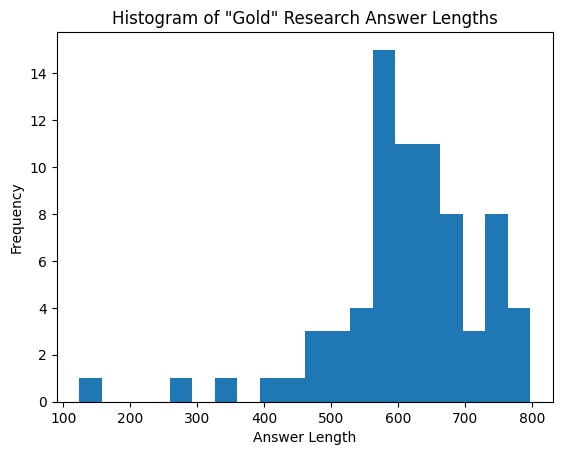

In [ ]:
# (3.4.5.c) Examine histogram of sequence lengths of optimal "research" answers for validation questions

# Plot histogram showing lengths of "research" answers
plt.hist([len(answer) for answer in v_research_answers], bins=20)
plt.xlabel('Answer Length')
plt.ylabel('Frequency')
plt.title('Histogram of "Gold" Research Answer Lengths')
plt.show()

In [ ]:
# (3.4.5.d) Examine average, minimum, and maximum number of sentences in optimal "research" answers for validation questions

# PART 1: Define empty list to hold number of sentences within each "research" answer
v_research_answer_sentence_counter = []

# PART 2: Loop through each "research" answer, compute number of sentences, and store number in list
for answer in v_research_answers:
    v_research_answer_sentences = re.split(r'[.!?]+', answer)
    v_research_answer_num_sentences = max(len(v_research_answer_sentences)-1, 1)
    v_research_answer_sentence_counter.append(v_research_answer_num_sentences)

# PART 3: Compute average number of sentences in "research" answers
v_avg_research_answer_sentences = sum(v_research_answer_sentence_counter) / len(v_research_answer_sentence_counter)

# PART 4: Compute minimum number of sentences in "research" answers
v_min_research_answer_sentences = min(v_research_answer_sentence_counter)

# PART 5: Compute maximum number of sentences in "research" answers
v_max_research_answer_sentences = max(v_research_answer_sentence_counter)

# Part 6: Print average sentences, minimum sentences, and maximum sentences
print('Average "Gold" Research Answer Sentences:', v_avg_research_answer_sentences)
print('Minimum "Gold" Research Answer Sentences:', v_min_research_answer_sentences)
print('Maximum "Gold" Research Answer Sentences:', v_max_research_answer_sentences)

Average "Gold" Research Answer Sentences: 3.7333333333333334
Minimum "Gold" Research Answer Sentences: 2
Maximum "Gold" Research Answer Sentences: 6


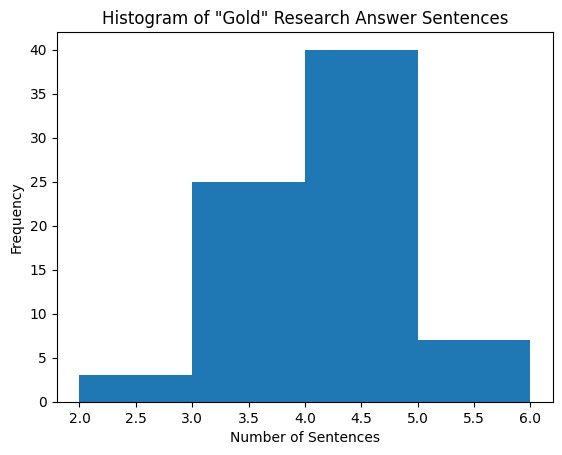

In [ ]:
# (3.4.5.e) Examine histogram of number of sentences in optimal "research" answers for validation questions

# Plot histogram showing sentences in "research" answers
plt.hist(v_research_answer_sentence_counter, bins=4)
plt.xlabel('Number of Sentences')
plt.ylabel('Frequency')
plt.title('Histogram of "Gold" Research Answer Sentences')
plt.show()

In [ ]:
# (3.4.5.f) Examine average, minimum, and maximum sequence length of optimal "marketing" answers for validation questions

# PART 1: Compute average length of "marketing" answers
v_avg_marketing_answer_length = sum(len(answer) for answer in v_marketing_answers) / len(v_marketing_answers)

# PART 2: Compute minimum length of "marketing" answers
v_min_marketing_answer_length = min(len(answer) for answer in v_marketing_answers)

# PART 3: Compute maximum length of "marketing" answers
v_max_marketing_answer_length = max(len(answer) for answer in v_marketing_answers)

# PART 4: Print average length, minimum length, and maximum length
print('Average "Gold" Marketing Answer Length:', v_avg_marketing_answer_length)
print('Minimum "Gold" Marketing Answer Length:', v_min_marketing_answer_length)
print('Maximum "Gold" Marketing Answer Length:', v_max_marketing_answer_length)

Average "Gold" Marketing Answer Length: 266.0933333333333
Minimum "Gold" Marketing Answer Length: 40
Maximum "Gold" Marketing Answer Length: 582


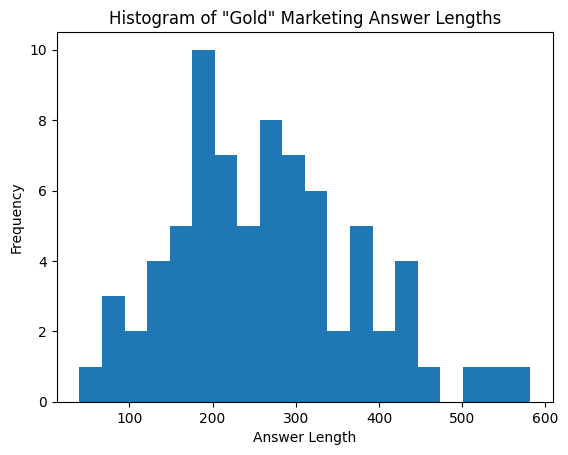

In [ ]:
# (3.4.5.g) Examine histogram of sequence lengths of optimal "marketing" answers for validation questions

# Plot histogram showing lengths of "marketing" answers
plt.hist([len(answer) for answer in v_marketing_answers], bins=20)
plt.xlabel('Answer Length')
plt.ylabel('Frequency')
plt.title('Histogram of "Gold" Marketing Answer Lengths')
plt.show()

In [ ]:
# (3.4.5.h) Examine average, minimum, and maximum number of sentences in optimal "marketing" answers for validation questions

# PART 1: Define empty list to hold number of sentences within each "marketing" answer
v_marketing_answer_sentence_counter = []

# PART 2: Loop through each "marketing" answer, compute number of sentences, and store number in list
for answer in v_marketing_answers:
    v_marketing_answer_sentences = re.split(r'[.!?]+', answer)
    v_marketing_answer_num_sentences = max(len(v_marketing_answer_sentences)-1, 1)
    v_marketing_answer_sentence_counter.append(v_marketing_answer_num_sentences)

# PART 3: Compute average number of sentences in "marketing" answers
v_avg_marketing_answer_sentences = sum(v_marketing_answer_sentence_counter) / len(v_marketing_answer_sentence_counter)

# PART 4: Compute minimum number of sentences in "marketing" answers
v_min_marketing_answer_sentences = min(v_marketing_answer_sentence_counter)

# PART 5: Compute maximum number of sentences in "marketing" answers
v_max_marketing_answer_sentences = max(v_marketing_answer_sentence_counter)

# PART 6: Print average sentences, minimum sentences, and maximum sentences
print('Average "Gold" Marketing Answer Sentences:', v_avg_marketing_answer_sentences)
print('Minimum "Gold" Marketing Answer Sentences:', v_min_marketing_answer_sentences)
print('Maximum "Gold" Marketing Answer Sentences:', v_max_marketing_answer_sentences)

Average "Gold" Marketing Answer Sentences: 1.4933333333333334
Minimum "Gold" Marketing Answer Sentences: 1
Maximum "Gold" Marketing Answer Sentences: 4


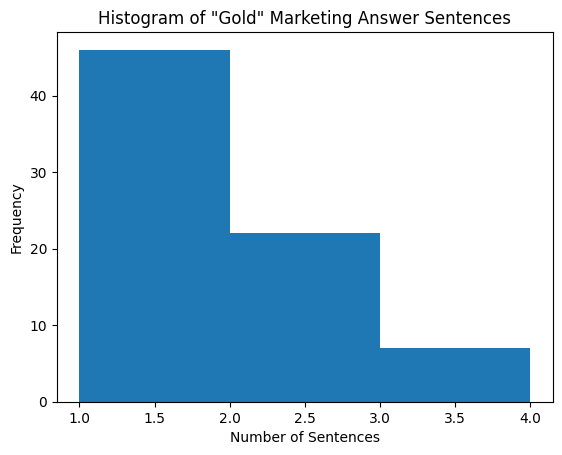

In [ ]:
# (3.4.5.i) Examine histogram of number of sentences in optimal "marketing" answers for validation questions

# Plot histogram showing sentences in "marketing" answers
plt.hist(v_marketing_answer_sentence_counter, bins=3)
plt.xlabel('Number of Sentences')
plt.ylabel('Frequency')
plt.title('Histogram of "Gold" Marketing Answer Sentences')
plt.show()

####3.4.6 Mini-Batch Test (MBT) Setup

In [ ]:
# (3.4.6.a) Create functions to generate RAG data for metric evaluations and tests

# PART 1: Define RAG data generation function for validation question and answer set
def generate_rag_data_dict_v(q_id_list, qa_dict, llm, persona):
  """Runs pre-defined RAG system using a supplied list of questions, answers, a specific llm, and a specific persona
  and outputs a dictionary showing questions, RAG answers, contexts, document sources, and ground truths

  Args:
  * q_id_list = list of question ids (e.g., question dictionary keys) in the form of numbers
  * qa_dict = dictionary of question and answer pairs (e.g., validation set)
  * llm = large language model (e.g., mistral, cohere)
  * persona = user persona/audience for generated answers (e.g., research, marketing)

  Returns:
  * rag_data_dict = dictionary of questions, RAG answers, contexts, document sources, and ground truths
  """

  # Define empty lists for storing question IDs, questions, RAG answers, contexts, document sources, and ground truths
  question_ids = []
  questions = []
  answers = []
  ground_truths = []
  contexts = []
  sources = []

  # Obtain question IDs, questions, RAG answers, contexts, and document sources to append to lists
  for id in q_id_list:

    # Append question IDs
    question_ids.append(id)

    # Append questions
    questions.append(qa_dict.get(id).get('question'))

    # Append RAG answers
    if llm == 'mistral':
      if persona == 'research':
        answers.append(clean_output(sd_os_rag_chain_research.invoke(qa_dict.get(id).get('question'))))
      else:
        answers.append(clean_output(sd_os_rag_chain_marketing.invoke(qa_dict.get(id).get('question'))))
    else:
      if persona == 'research':
        answers.append(clean_output(sd_pro_rag_chain_research.invoke(qa_dict.get(id).get('question'))))
      else:
        answers.append(clean_output(sd_pro_rag_chain_marketing.invoke(qa_dict.get(id).get('question'))))

    # Append ground truths
    if persona == 'research':
      ground_truths.append(qa_dict.get(id).get('gold_answer_research'))
    else:
      ground_truths.append(qa_dict.get(id).get('gold_answer_marketing'))

    # Append contexts
    contexts.append(
        [doc.page_content for doc in sd_retriever.get_relevant_documents(qa_dict.get(id).get('question'))])

    # Append document sources
    sources.append(
        [doc.metadata['source'] for doc in sd_retriever.get_relevant_documents(qa_dict.get(id).get('question'))])

  # Convert lists to dictionaries of lists for indexing and evaluation metrics
  rag_data_dict = {
      "q_id": question_ids,
      "question": questions,
      "answer": answers,
      "contexts": contexts,
      "sources": sources,
      "ground_truth": ground_truths
  }

  # Save output
  return rag_data_dict

###############################################################################

# PART 2: Define RAG data generation function for test question set (with no answers)
def generate_rag_data_dict_t(q_id_list, q_dict, llm, persona):
  """Runs pre-defined RAG system using a supplied list of questions, a specific llm, and a specific persona
  and outputs a dictionary showing questions, RAG answers, contexts, and document sources

  Args:
  * q_id_list = list of question ids (e.g., question dictionary keys) in the form of numbers
  * q_dict = dictionary of questions (e.g., test set)
  * llm = large language model (e.g., mistral, cohere)
  * persona = user persona/audience for generated answers (e.g., research, marketing)

  Returns:
  * rag_data_dict = dictionary of questions, RAG answers, contexts, and document sources
  """

  # Define empty lists for storing question IDs, questions, RAG answers, contexts, and document sources
  question_ids = []
  questions = []
  answers = []
  contexts = []
  sources = []

  # Obtain question IDs, questions, RAG answers, contexts, and document sources to append to lists
  for id in q_id_list:

    # Append question IDs
    question_ids.append(id)

    # Append questions
    questions.append(q_dict.get(id).get('question'))

    # Append RAG answers
    if llm == 'mistral':
      if persona == 'research':
        answers.append(clean_output(sd_os_rag_chain_research.invoke(q_dict.get(id).get('question'))))
      else:
        answers.append(clean_output(sd_os_rag_chain_marketing.invoke(q_dict.get(id).get('question'))))
    else:
      if persona == 'research':
        answers.append(clean_output(sd_pro_rag_chain_research.invoke(q_dict.get(id).get('question'))))
      else:
        answers.append(clean_output(sd_pro_rag_chain_marketing.invoke(q_dict.get(id).get('question'))))

    # Append contexts
    contexts.append(
        [doc.page_content for doc in sd_retriever.get_relevant_documents(q_dict.get(id).get('question'))])

    # Append document sources
    sources.append(
        [doc.metadata['source'] for doc in sd_retriever.get_relevant_documents(q_dict.get(id).get('question'))])

  # Convert lists to dictionaries of lists for indexing and evaluation metrics
  rag_data_dict = {
      "q_id": question_ids,
      "question": questions,
      "answer": answers,
      "contexts": contexts,
      "sources": sources
  }

  # Save output
  return rag_data_dict

In [ ]:
# (3.4.6.b) Test RAG system on mini-batch of validation question/answer pairs and test questions

# REFERENCE: Count of validation questions and test questions
# * Validation = 75
# ** Question IDs:
#   [0, 1, 2, 3, 7, 8, 9, 11, 12, 13, 16, 17, 18, 19, 20, 22, 23, 24, 25, 27,
#    28, 30, 33, 34, 35, 36, 38, 39, 41, 43, 44, 45, 46, 47, 48, 50, 51, 52,
#    54, 55, 59, 60, 61, 62, 63, 64, 65, 67, 69, 70, 73, 74, 75, 76, 78, 80,
#    81, 82, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 101, 102, 103,
#    104]
# * Test = 29
# ** Question IDs:
#   [4, 5, 6, 10, 14, 15, 21, 26, 29, 31, 32, 37, 40, 42, 49, 56, 57, 58, 66,
#    68, 71, 72, 77, 79, 83, 90, 98, 99, 100]

# PART 1: Define validation question IDs to run through RAG system
v_q_ids_mbt = [
    0,    # 5.2.1 Test Question 1
    50,   # 5.2.2 Test Question 2
    # 75,
    # 95,
    # 104,
]

# PART 2: Define test question IDs to run through RAG system
t_q_ids_mbt = [
    # 4,
    # 10,
    # 40,
    83,   # 5.2.3 Test Question 3
    # 100,
]

# PART 3: Generate RAG output for validation questions

## Research Persona
######################
# rag_output_v_research_mistral_mbt = generate_rag_data_dict_v(
#     q_id_list=v_q_ids_mbt,
#     qa_dict=validation_questions_answers,
#     llm='mistral',
#     persona='research')
rag_output_v_research_cohere_mbt = generate_rag_data_dict_v(
    q_id_list=v_q_ids_mbt,
    qa_dict=validation_questions_answers,
    llm='cohere',
    persona='research')

## Marketing Persona
######################
# rag_output_v_marketing_mistral_mbt = generate_rag_data_dict_v(
#     q_id_list=v_q_ids_mbt,
#     qa_dict=validation_questions_answers,
#     llm='mistral',
#     persona='marketing')
rag_output_v_marketing_cohere_mbt = generate_rag_data_dict_v(
    q_id_list=v_q_ids_mbt,
    qa_dict=validation_questions_answers,
    llm='cohere',
    persona='marketing')

# PART 4: Generate RAG output for test questions

## Research Persona
######################
# rag_output_t_research_mistral_mbt = generate_rag_data_dict_t(
#     q_id_list=t_q_ids_mbt,
#     q_dict=test_questions,
#     llm='mistral',
#     persona='research')
rag_output_t_research_cohere_mbt = generate_rag_data_dict_t(
    q_id_list=t_q_ids_mbt,
    q_dict=test_questions,
    llm='cohere',
    persona='research')

## Marketing Persona
######################
# rag_output_t_marketing_mistral_mbt = generate_rag_data_dict_t(
#     q_id_list=t_q_ids_mbt,
#     q_dict=test_questions,
#     llm='mistral',
#     persona='marketing')
rag_output_t_marketing_cohere_mbt = generate_rag_data_dict_t(
    q_id_list=t_q_ids_mbt,
    q_dict=test_questions,
    llm='cohere',
    persona='marketing')

In [ ]:
# (3.4.6.c) View sample RAG system output in dictionary format for troubelshooting/inspection

# Select one of the following outputs to view and comment out all others
rag_output_sample_view_mbt = [
    # rag_output_v_research_mistral_mbt,
    rag_output_v_research_cohere_mbt,
    # rag_output_t_research_mistral_mbt,
    # rag_output_t_research_cohere_mbt,
    # rag_output_v_marketing_mistral_mbt,
    # rag_output_v_marketing_cohere_mbt,
    # rag_output_t_marketing_mistral_mbt,
    # rag_output_t_marketing_cohere_mbt,
]

# View sample output
display(rag_output_sample_view_mbt)

[{'q_id': [0, 50],
  'question': ['What purpose do large language models serve in the field of natural language processing?',
   'What methods are typically employed to create training data for embedding models that use task-specific instructions?'],
  'answer': ['Large language models (LLMs) have become integral tools in natural language processing (NLP), offering a wide range of applications. These models are designed to process and analyze large volumes of text data, learning statistical relationships between words and phrases. This enables LLMs to generate human-like text, understand and interpret natural language input, and perform a variety of tasks such as speech recognition, machine translation, and information retrieval. The advanced capabilities of LLMs in NLP have led to their widespread use in developing intelligent systems that can interact with users in a more human-like manner. However, one of the challenges in the development of LLMs is aligning their training objective

In [ ]:
# (3.4.6.d) Convert RAG outputs to abbreviated datasets and pandas dataframes to prepare for performance measurements/metric evaluations

# PART 1: Create "research" and "marketing" RAG output datasets for validation question set
# rag_output_v_research_mistral_mbt_abbrev = {key: rag_output_v_research_mistral_mbt[key] for key in ['question', 'answer', 'contexts', 'ground_truth']}
# rag_output_v_research_mistral_mbt_ds = Dataset.from_dict(rag_output_v_research_mistral_mbt_abbrev)
rag_output_v_research_cohere_mbt_abbrev = {key: rag_output_v_research_cohere_mbt[key] for key in ['question', 'answer', 'contexts', 'ground_truth']}
rag_output_v_research_cohere_mbt_ds = Dataset.from_dict(rag_output_v_research_cohere_mbt_abbrev)
# rag_output_v_marketing_mistral_mbt_abbrev = {key: rag_output_v_marketing_mistral_mbt[key] for key in ['question', 'answer', 'contexts', 'ground_truth']}
# rag_output_v_marketing_mistral_mbt_ds = Dataset.from_dict(rag_output_v_marketing_mistral_mbt_abbrev)
rag_output_v_marketing_cohere_mbt_abbrev = {key: rag_output_v_marketing_cohere_mbt[key] for key in ['question', 'answer', 'contexts', 'ground_truth']}
rag_output_v_marketing_cohere_mbt_ds = Dataset.from_dict(rag_output_v_marketing_cohere_mbt_abbrev)

# PART 2: Create "research" and "marketing" RAG output dataframes for validation question set
# rag_output_v_research_mistral_mbt_df = Dataset.from_dict(rag_output_v_research_mistral_mbt).to_pandas()
rag_output_v_research_cohere_mbt_df = Dataset.from_dict(rag_output_v_research_cohere_mbt).to_pandas()
# rag_output_v_marketing_mistral_mbt_df = Dataset.from_dict(rag_output_v_marketing_mistral_mbt).to_pandas()
rag_output_v_marketing_cohere_mbt_df = Dataset.from_dict(rag_output_v_marketing_cohere_mbt).to_pandas()

# PART 3: Create "research" and "marketing" RAG output dataframes for testing question set
# rag_output_t_research_mistral_mbt_df = Dataset.from_dict(rag_output_t_research_mistral_mbt).to_pandas()
rag_output_t_research_cohere_mbt_df = Dataset.from_dict(rag_output_t_research_cohere_mbt).to_pandas()
# rag_output_t_marketing_mistral_mbt_df = Dataset.from_dict(rag_output_t_marketing_mistral_mbt).to_pandas()
rag_output_t_marketing_cohere_mbt_df = Dataset.from_dict(rag_output_t_marketing_cohere_mbt).to_pandas()

##4. POC RAG Tests & Evaluations



#### **4.1 Evaluation Metrics**

I've chosen the following metrics to assess the performance of the POC RAG system. Most of these metrics evaluate the *answer generation* aspect of the RAG system, while a few evaluate the *retrieval* aspect. Additionally, some of these metrics score RAG question responses based on token/word overlap with the provided "gold" (or ground truth) answers for those questions, while others score the responses based on semantic similarity to these "gold" answers. This allows for both word-for-word and thought-for-thought assessments (i.e., "how close are RAG answers to 'gold' answers based strictly on choice of words" versus "how close are RAG answers to 'gold' answers based on overall meaning/gist"). All metrics apply to both *research* (engineering) team answers and *marketing* team answers.

-------------------------------------------------------------
1. **Answer Length / Ratio to "Gold"**
-------------------------------------------------------------
* **`Definition`**: Length of RAG-generated answers (across a batch of answers) as measured by number of characters; the average length is taken across tested answers, and the ratio of this average length to the average length of "gold" (ground truth) answers is computed
* **`Purpose`**: Provides simple comparison of RAG answers to "gold" (ground truth) answers in terms of verbosity/succinctness
* **`Outcome Range`**: Any positive number (e.g., 365.4, 180.3, etc.) for lengths, and a smaller positive number (e.g., 1.4, 0.8) for ratios
* **`Goal`**: Where possible, minimize length differences between RAG-generated answers and "gold" (ground truth) answers and aim for a ratio close to 1.0

-------------------------------------------------------------
2. **BLEU**
-------------------------------------------------------------
* **`Definition`**: Comparison of overlap in tokens/words between RAG-generated answers and "gold" (ground truth) answers; the average scores are taken across tested questions and answers
  * *BLEU-1* compares unigrams (single tokens/words)
  * *BLEU-2* compares bigrams (pairs of adjacent tokens/words)
  * *BLEU-3* compares trigrams (sequences of three consecutive tokens/words)
  * *BLEU-4* compares fourgrams (sequences of four consecutive tokens/words)
* **`Purpose`**: Provides a measure of token/word correspondence between RAG answers and reference answers (i.e., do they generally contain the same words), used primarily to assess machine-generated translations
* **`Outcome Range`**: Any number between 0 and 1 (higher is better)
* **`Goal`**: Where possible, maximize BLEU score, especially BLEU-4 (standard version used in most translation tasks)

-------------------------------------------------------------
3. **ROUGE**
-------------------------------------------------------------
* **`Definition`**: Comparison of overlap in tokens/words between RAG-generated answers and "gold" (ground truth) answers, accounting for both presence and absence of tokens/words; the average scores are taken across tested questions and answers
  * *ROUGE-1* computes overlap of unigrams (single tokens/words)
  * *ROUGE-2* computes overlap of bigrams (pairs of adjacent tokens/words)
  * *ROUGE-L* computes the longest common subsequence (LCS), considering any length of n-grams
  * *ROUGE-Lsum* computes the LCS (similar to ROUGE-L) but weights it by length
* **`Purpose`**: Provides another measure of token/word correspondence between RAG answers and reference answers (i.e., do they generally contain the same words), used primarily to assess machine-generated summaries
* **`Outcome Range`**: Any number between 0 and 1 (higher is better)
* **`Goal`**: Where possible, maximize ROUGE score, especially ROUGE-2 (standard version used in most summary tasks)

-------------------------------------------------------------
4. **BERTScore**
-------------------------------------------------------------
* **`Definition`**: Comparison of BERT-produced contextual embeddings for RAG-generated answers and "gold" (ground truth) answers to capture semantic similarity; the average scores are taken across tested questions and answers
  * *Precision* measures the proportion of relevant tokens among those in the RAG-generated answers
  * *Recall* measures the proportion of relevant tokens in the "gold" (ground truth) answers captured by the RAG-generated answers
  * *F1* represents the harmonic mean of Precision and Recall, providing a balanced measure of both text capture and text retention in the RAG-generated answers compared to the "gold" (ground truth) answers
* **`Purpose`**: Provides a measure of semantic similarity/equivalence between RAG answers and reference answers (i.e., do they generally mean the same thing)
* **`Outcome Range`**: Any number between 0 and 1 (higher is better)
* **`Goal`**: Where possible, maximize BERTScore components, especially F1 (harmonic mean of precision and recall)

-------------------------------------------------------------
5. **RAGAS**
-------------------------------------------------------------
* **`Definition`**: Suite of several metrics evaluating RAG-generated answers and "gold" (ground truth) answers, as well as context relevance and retrieval; the average scores are taken across tested questions and answers
  * ***RAG Retrieval Metrics***:
    * *Context Precision* measures the signal-to-noise ratio of RAG-retrieved contexts (e.g., for each question, are the retrieved contexts relevant to the question)
    * *Context Recall* measures the relevance of RAG-retrieved information (e.g., for each ground truth answer, are the retrieved contexts retaining info from the answer)
  * ***RAG Generation Metrics***:
    * *Faithfulness* measures the factual accuracy of RAG-generated answers (e.g., for each RAG answer, is there a close match to the ground truth answer)
    * *Answer Relevancy* measures the relevance of RAG-generated answers (e.g., for each RAG answer and each question, does the answer capture what's being asked in the question)
  * ***RAG End-to-End Metrics***:
    * *Answer Correctness* measures overall alignment between RAG-generated answers and "gold" (ground truth) answers based on semantic similarity and factual similarity
* **`Purpose`**: Provides an assessment of various components of a RAG system, including the quality of retrieved information (i.e., does the system return appropriate and relevant contexts in which to anchor its answers) and the quality of generated answers compared to ground truth answers (i.e., do they generally mean the same thing and capture the same information)
* **`Outcome Range`**: Any number between 0 and 1 (higher is better)
* **`Goal`**: Where possible, maximize RAG Retrieval, RAG Generation, and RAG End-to-End metrics, especially the RAG Generation metrics

-------------------------------------------------------------
6. **Pass Rate (Manual Review)**
-------------------------------------------------------------
* **`Definition`**: Eye-test/human judgment comparison of RAG-generated answers and "gold" (ground truth) answers; RAG answers are compared to "gold" answers and contexts and marked as "passing" or "not passing" based on relevance and similarity to come up with an overall rate of passing answers
* **`Purpose`**: Provides a simple and intuitive measure of "goodness" of RAG-generated answers based on the overall similarity of RAG answers to "gold" (ground truth) answers and relevance to RAG-retrieved contexts
* **`Outcome Range`**: Percentage between 0% and 100% (higher is better)
* **`Goal`**: Where possible, maximize Pass Rate as a final test of reasonability in RAG answers






In [ ]:
# (4.1) Create functions to define RAG evaluation metrics

# METRIC 1: Response Length
def rag_eval_response_length(rag_output_df):
  """Evaluates RAG answer response lengths based on a provided dataframe of RAG outputs
  (e.g., questions, answers, ground truths, etc.)

  Args:
  * rag_output_df = dataframe containing RAG outputs (e.g., questions, answers, ground truths, etc.)

  Returns:
  * rag_response_lengths = dictionary of RAG answer and ground truth response lengths (measured in words)
  """

  # Define empty lists for storing response lengths for RAG-generated answers and ground truths
  rag_answer_response_lengths = []
  rag_ground_truth_response_lengths = []

  # For each answer and ground truth in RAG output dataframe, calculate its length and append it to the appropriate list
  for i in range(len(rag_output_df)):
    rag_answer_response_length = len(rag_output_df['answer'][i])
    rag_answer_response_lengths.append(rag_answer_response_length)
    rag_ground_truth_response_length = len(rag_output_df['ground_truth'][i])
    rag_ground_truth_response_lengths.append(rag_ground_truth_response_length)

  # Convert response length lists to dictionary of lists
  rag_response_lengths = {
      "RAG_Answer_Lengths": rag_answer_response_lengths,
      "Gold_Answer_Lengths": rag_ground_truth_response_lengths
  }

  # Save output
  return rag_response_lengths

###############################################################################

# METRIC 2: BLEU
def rag_eval_bleu(rag_output_df):
  """Evaluates RAG answer BLEU scores based on a provided dataframe of RAG outputs
  (e.g., questions, answers, ground truths, etc.)

  Args:
  * rag_output_df = dataframe containing RAG outputs (e.g., questions, answers, ground truths, etc.)

  Returns:
  * rag_BLEU_scores = dictionary of RAG answer BLEU scores (1-gram, 2-gram, 3-gram, 4-gram)
  """

  # Define empty lists for storing BLEU scores for RAG-generated answers
  rag_BLEU_1g = []
  rag_BLEU_2g = []
  rag_BLEU_3g = []
  rag_BLEU_4g = []

  # For each answer in RAG output dataframe, calculate its BLEU scores and append them to the appropriate list
  for i in range(len(rag_output_df)):
    rag_answer_reference = rag_output_df['ground_truth'][i].lower()
    rag_answer_candidate = rag_output_df['answer'][i].lower()
    rag_BLEU_1g.append(corpus_bleu([[rag_answer_reference]], [rag_answer_candidate], weights=(1, 0, 0, 0)))
    rag_BLEU_2g.append(corpus_bleu([[rag_answer_reference]], [rag_answer_candidate], weights=(0, 1, 0, 0)))
    rag_BLEU_3g.append(corpus_bleu([[rag_answer_reference]], [rag_answer_candidate], weights=(0, 0, 1, 0)))
    rag_BLEU_4g.append(corpus_bleu([[rag_answer_reference]], [rag_answer_candidate], weights=(0, 0, 0, 1)))

  # Convert BLEU score lists to dictionary of lists
  rag_BLEU_scores = {
      "BLEU-1": rag_BLEU_1g,
      "BLEU-2": rag_BLEU_2g,
      "BLEU-3": rag_BLEU_3g,
      "BLEU-4": rag_BLEU_4g
  }

  # Save output
  return rag_BLEU_scores

###############################################################################

# METRIC 3: ROUGE
def rag_eval_rouge(rag_output_df):
  """Evaluates RAG answer ROUGE scores based on a provided dataframe of RAG outputs
  (e.g., questions, answers, ground truths, etc.)

  Args:
  * rag_output_df = dataframe containing RAG outputs (e.g., questions, answers, ground truths, etc.)

  Returns:
  * rag_ROUGE_scores = dictionary of RAG answer ROUGE scores (1, 2, L, and Lsum)
  """

  # Define empty lists for storing ROUGE scores for RAG-generated answers
  rag_ROUGE_1 = []
  rag_ROUGE_2 = []
  rag_ROUGE_L = []
  rag_ROUGE_Lsum = []

  # Load rouge scoring mechanism
  rouge = evaluate.load('rouge')

  # For each answer in RAG output dataframe, calculate its ROUGE scores and append them to the appropriate list
  for i in range(len(rag_output_df)):
    rag_answer_reference = rag_output_df['ground_truth'][i].lower()
    rag_answer_prediction = rag_output_df['answer'][i].lower()
    rag_ROUGE_results = rouge.compute(predictions=[rag_answer_prediction], references=[rag_answer_reference])
    rag_ROUGE_1.append(rag_ROUGE_results['rouge1'])
    rag_ROUGE_2.append(rag_ROUGE_results['rouge2'])
    rag_ROUGE_L.append(rag_ROUGE_results['rougeL'])
    rag_ROUGE_Lsum.append(rag_ROUGE_results['rougeLsum'])

  # Convert ROUGE score lists to dictionary of lists
  rag_ROUGE_scores = {
      "ROUGE-1": rag_ROUGE_1,
      "ROUGE-2": rag_ROUGE_2,
      "ROUGE-L": rag_ROUGE_L,
      "ROUGE-Lsum": rag_ROUGE_Lsum
  }

  # Save output
  return rag_ROUGE_scores

###############################################################################

# METRIC 4: BERTScore
def rag_eval_bertscore(rag_output_df):
  """Evaluates RAG answer BERTScore metrics based on a provided dataframe of RAG outputs
  (e.g., questions, answers, ground truths, etc.)

  Args:
  * rag_output_df = dataframe containing RAG outputs (e.g., questions, answers, ground truths, etc.)

  Returns:
  * rag_BERTScore_metrics = dictionary of RAG answer BERTScore metrics (precision, recall, and F1)
  """

  # Define empty lists for storing BERTScore metrics for RAG-generated answers
  rag_BERTScore_precision = []
  rag_BERTScore_recall = []
  rag_BERTScore_F1 = []

  # Load BERTScore scoring mechanism and model (standard BERT model)
  scorer = BERTScorer(model_type='bert-base-uncased')

  # For each answer in RAG output dataframe, calculate its BERTScore metrics and append them to the appropriate list
  for i in range(len(rag_output_df)):
    rag_answer_reference = rag_output_df['ground_truth'][i].lower()
    rag_answer_prediction = rag_output_df['answer'][i].lower()
    rag_BERTScore_result = scorer.score([rag_answer_prediction], [rag_answer_reference])
    rag_BERTScore_precision.append(rag_BERTScore_result[0])
    rag_BERTScore_recall.append(rag_BERTScore_result[1])
    rag_BERTScore_F1.append(rag_BERTScore_result[2])

  # Convert BERTScore metric lists to dictionary of lists
  rag_BERTScore_metrics_raw = {
      "BERTScore-Precision": rag_BERTScore_precision,
      "BERTScore-Recall": rag_BERTScore_recall,
      "BERTScore-F1": rag_BERTScore_F1
  }

  # Fix output to remove tensor components
  rag_BERTScore_metrics = {
      key: [value_item.item() for value_item in value] for key, value in rag_BERTScore_metrics_raw.items()
  }

  # Save output
  return rag_BERTScore_metrics

###############################################################################

# METRIC 5: RAGAS
def rag_eval_ragas(rag_output_ds):
  """Evaluates RAG system RAGAS metrics based on a provided dataset of RAG outputs
  (e.g., questions, answers, ground truths, etc.)

  Args:
  * rag_output_ds = dataset containing RAG outputs (e.g., questions, answers, ground truths, etc.)

  Returns:
  * rag_RAGAS_metrics_df = dataframe of RAGAS metrics (context precision, context recall, faithfulness, answer relevancy, answer correctness)
  """

  # Get OpenAI API key for RAGAS evaluations
  os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

  # Calculate results for defined list of RAGAS metrics
  RAGAS_results = ragas_evaluate(
      dataset=rag_output_ds,
      metrics=[
          context_precision,
          context_recall,
          faithfulness,
          answer_relevancy,
          answer_correctness]
      )

  # Convert RAGAS results output to pandas dataframe
  rag_RAGAS_metrics_df = RAGAS_results.to_pandas()

  # Save output
  return rag_RAGAS_metrics_df

###############################################################################

# METRIC 6: Pass Rate (Manual Review)
# No function - answer reviews are manually performed

###4.2. Evaluation Comparisons

In [ ]:
# (4.2.a) Create functions to score RAG system output and append scores to output, calculate mean scores, and plot scores

# Compute metric scores (except manual review metric) and combine with RAG output
def rag_score_combine(rag_output_df, rag_output_ds):
  """Scores and appends metrics to RAG system output based on a provided dataframe of RAG outputs
  (e.g., questions, answers, ground truths, etc.) and a similar dataset of RAG outputs

  Args:
  * rag_output_df = dataframe containing RAG outputs (e.g., questions, answers, ground truths, etc.)
  * rag_output_ds = dataset containing RAG outputs (e.g., questions, answers, ground truths, etc.)

  Returns:
  * rag_scored_output_df = dataframe of RAG output and metric scores
  """

  # Score RAG system output data
  response_length_scores = rag_eval_response_length(rag_output_df)
  BLEU_scores = rag_eval_bleu(rag_output_df)
  ROUGE_scores = rag_eval_rouge(rag_output_df)
  BERTScore_scores = rag_eval_bertscore(rag_output_df)
  RAGAS_scores = rag_eval_ragas(rag_output_ds)

  # Convert metric results to dataframes
  response_length_scores_df = pd.DataFrame(response_length_scores)
  BLEU_scores_df = pd.DataFrame(BLEU_scores)
  ROUGE_scores_df = pd.DataFrame(ROUGE_scores)
  BERTScore_scores_df = pd.DataFrame(BERTScore_scores)
  RAGAS_scores_df = RAGAS_scores.drop(['question', 'answer', 'contexts', 'ground_truth'], axis=1)

  # Concatenate RAG output data and metrics
  rag_scored_output_df = pd.concat(
    [
        rag_output_df,
        response_length_scores_df,
        BLEU_scores_df,
        ROUGE_scores_df,
        BERTScore_scores_df,
        RAGAS_scores_df
    ], axis=1)

  # Replace any NaN values with zeros
  rag_scored_output_df = rag_scored_output_df.fillna(0)

  # Save output
  return rag_scored_output_df

###############################################################################

# Calculate mean metric scores for plot preparation
def rag_score_means(rag_scored_output_df):
  """Computes the means of each numeric metric in RAG scored output for use in visualizations

  Args:
  * rag_scored_output_df = dataframe of RAG output and metric scores

  Returns:
  * rag_mean_scores = dictionary of RAG mean metric scores
  """

  # Define RAG metric columns
  RAG_metric_columns = [
      'RAG_Answer_Lengths',
      'Gold_Answer_Lengths',
      'BLEU-1',
      'BLEU-2',
      'BLEU-3',
      'BLEU-4',
      'ROUGE-1',
      'ROUGE-2',
      'ROUGE-L',
      'ROUGE-Lsum',
      'BERTScore-Precision',
      'BERTScore-Recall',
      'BERTScore-F1',
      'context_precision',
      'context_recall',
      'faithfulness',
      'answer_relevancy',
      'answer_correctness'
  ]

  # Compute means across all RAG metric columns
  rag_mean_scores = rag_scored_output_df[RAG_metric_columns].mean().to_dict()

  # Compute value of new RAG_Gold_Answer_Lengths_Ratio column
  if rag_mean_scores['Gold_Answer_Lengths'] == 0:
    RAG_Gold_Answer_Lengths_Ratio = 0
  else:
    RAG_Gold_Answer_Lengths_Ratio = rag_mean_scores['RAG_Answer_Lengths'] / rag_mean_scores['Gold_Answer_Lengths']

  # Add new RAG_Gold_Answer_Lengths_Ratio column and value
  rag_mean_scores['RAG_Gold_Answer_Lengths_Ratio'] = RAG_Gold_Answer_Lengths_Ratio

  # Show resulting means output
  return rag_mean_scores

###############################################################################

# Plot mean metric scores on a scatter polar plot
def rag_score_polar_plot(rag_mean_scores_research, rag_mean_scores_marketing):
  """Plots RAG system metrics on a polar plot based on provided dataframes with RAG
  scored outputs for research and marketing personas

  Args:
  * rag_mean_scores_research = dictionary containing RAG mean scores for research persona
  * rag_mean_scores_marketing = dictionary containing RAG mean scores for marketing persona

  Returns:
  * rag_polar_plot = polar plot visualizing RAG system metrics
  """

  # Create data for polar plot to visualize RAG performance metrics
  rag_plot_data_research = {
      key: value for key, value in rag_mean_scores_research.items() if key not in ['RAG_Answer_Lengths', 'Gold_Answer_Lengths']
  }
  rag_plot_data_marketing = {
      key: value for key, value in rag_mean_scores_marketing.items() if key not in ['RAG_Answer_Lengths', 'Gold_Answer_Lengths']
  }

  # Define and add datasets to polar plot figure
  rag_pp_fig = go.Figure()
  rag_pp_fig.add_trace(go.Scatterpolar(
      r=list(rag_plot_data_research.values()),
      theta=list(rag_plot_data_research.keys()),
      fill='toself',
      name='Research'
  ))
  rag_pp_fig.add_trace(go.Scatterpolar(
      r=list(rag_plot_data_marketing.values()),
      theta=list(rag_plot_data_marketing.keys()),
      fill='toself',
      name='Marketing'
  ))
  rag_pp_fig.add_trace(go.Scatterpolar(
      r=[1.0] * len(rag_plot_data_research.values()),
      theta=list(rag_plot_data_research.keys()),
      mode='lines',
      line=dict(color='black'),
      showlegend=False
  ))

  # Generate polar plot
  rag_pp_fig.update_layout(
      polar=dict(
          radialaxis=dict(
              visible=True,
              range=[0, 2]
          )),
      showlegend=True,
      title='RAG System Output Evaluation (Mean Scores)',
      width=800
  )

  # Save output
  return rag_pp_fig

####4.2.1 Mini-Batch Test (MBT) Results

Run a small batch of validation and test questions through the RAG system to evaluate RAG pipeline and scoring.

In [ ]:
# (4.2.b) Run evaluation of RAG system output

#############################
## RUN SPECS:
## * Q_List = Validation (V)
## * Persona = Research
## * LLM = Cohere
#############################

# Score RAG system output
# RAG_V_RESEARCH_MISTRAL_COMBINED_OUTPUT_MBT = rag_score_combine(
#     rag_output_v_research_mistral_mbt_df,
#     rag_output_v_research_mistral_mbt_ds
# )
RAG_V_RESEARCH_COHERE_COMBINED_OUTPUT_MBT = rag_score_combine(
    rag_output_v_research_cohere_mbt_df,
    rag_output_v_research_cohere_mbt_ds
)

# Show resulting scored output
print('RAG System Scored Output - Mini-Batch Test (Research):\n')
# display(RAG_V_RESEARCH_MISTRAL_COMBINED_OUTPUT_MBT)
display(RAG_V_RESEARCH_COHERE_COMBINED_OUTPUT_MBT)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

RAG System Scored Output - Mini-Batch Test (Research):



,q_id,question,answer,contexts,sources,ground_truth,RAG_Answer_Lengths,Gold_Answer_Lengths,BLEU-1,BLEU-2,BLEU-3,BLEU-4,ROUGE-1,ROUGE-2,ROUGE-L,ROUGE-Lsum,BERTScore-Precision,BERTScore-Recall,BERTScore-F1,context_precision,context_recall,faithfulness,answer_relevancy,answer_correctness
0,0,What purpose do large language models serve in...,Large language models (LLMs) have become integ...,[A large language model (LLM) is a language mo...,[https://en.wikipedia.org/wiki/Large_language_...,Large language models (LLMs) serve the purpose...,872,639,0.723624,0.603904,0.435632,0.323360,0.387097,0.15814,0.248848,0.248848,0.638069,0.686313,0.661313,1.0,1.0,0.8,0.921056,0.573880
1,50,What methods are typically employed to create ...,Training data for embedding models that utiliz...,[variety of tasks for embedding training with ...,"[https://arxiv.org/pdf/2212.09741.pdf, https:/...",To create training data for embedding models t...,1027,738,0.715677,0.611111,0.461463,0.378906,0.426357,0.18750,0.263566,0.263566,0.658139,0.715702,0.685715,1.0,1.0,1.0,0.969059,0.733687


In [ ]:
# (4.2.c) Run evaluation of RAG system output

#############################
## RUN SPECS:
## * Q_List = Validation (V)
## * Persona = Research
## * LLM = Cohere
#############################

# Compute mean scores for RAG system output
# RAG_V_RESEARCH_MISTRAL_MEAN_SCORES_MBT = rag_score_means(RAG_V_RESEARCH_MISTRAL_COMBINED_OUTPUT_MBT)
RAG_V_RESEARCH_COHERE_MEAN_SCORES_MBT = rag_score_means(RAG_V_RESEARCH_COHERE_COMBINED_OUTPUT_MBT)

# Show resulting means output
print('RAG Metric Mean Scores - Mini-Batch Test (Research):\n')
# display(RAG_V_RESEARCH_MISTRAL_MEAN_SCORES_MBT)
display(RAG_V_RESEARCH_COHERE_MEAN_SCORES_MBT)

RAG Metric Mean Scores - Mini-Batch Test (Research):



{'RAG_Answer_Lengths': 949.5,
 'Gold_Answer_Lengths': 688.5,
 'BLEU-1': 0.7196502907729827,
 'BLEU-2': 0.6075073351192755,
 'BLEU-3': 0.44854779927109617,
 'BLEU-4': 0.3511332170598389,
 'ROUGE-1': 0.4067266816704176,
 'ROUGE-2': 0.17281976744186048,
 'ROUGE-L': 0.2562069088700747,
 'ROUGE-Lsum': 0.2562069088700747,
 'BERTScore-Precision': 0.6481043696403503,
 'BERTScore-Recall': 0.7010077238082886,
 'BERTScore-F1': 0.6735137403011322,
 'context_precision': 0.999999999975,
 'context_recall': 1.0,
 'faithfulness': 0.9,
 'answer_relevancy': 0.9450578064304669,
 'answer_correctness': 0.6537833901500196,
 'RAG_Gold_Answer_Lengths_Ratio': 1.3790849673202614}

In [ ]:
# (4.2.d) Run evaluation of RAG system output

#############################
## RUN SPECS:
## * Q_List = Validation (V)
## * Persona = Marketing
## * LLM = Cohere
#############################

# Score RAG system output
# RAG_V_MARKETING_MISTRAL_COMBINED_OUTPUT_MBT = rag_score_combine(
#     rag_output_v_marketing_mistral_mbt_df,
#     rag_output_v_marketing_mistral_mbt_ds
# )
RAG_V_MARKETING_COHERE_COMBINED_OUTPUT_MBT = rag_score_combine(
    rag_output_v_marketing_cohere_mbt_df,
    rag_output_v_marketing_cohere_mbt_ds
)

# Show resulting scored output
print('RAG System Scored Output - Mini-Batch Test (Marketing):\n')
# display(RAG_V_MARKETING_MISTRAL_COMBINED_OUTPUT_MBT)
display(RAG_V_MARKETING_COHERE_COMBINED_OUTPUT_MBT)

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

RAG System Scored Output - Mini-Batch Test (Marketing):



,q_id,question,answer,contexts,sources,ground_truth,RAG_Answer_Lengths,Gold_Answer_Lengths,BLEU-1,BLEU-2,BLEU-3,BLEU-4,ROUGE-1,ROUGE-2,ROUGE-L,ROUGE-Lsum,BERTScore-Precision,BERTScore-Recall,BERTScore-F1,context_precision,context_recall,faithfulness,answer_relevancy,answer_correctness
0,0,What purpose do large language models serve in...,Large language models (LLMs) are an essential ...,[A large language model (LLM) is a language mo...,[https://en.wikipedia.org/wiki/Large_language_...,Large language models serve the purpose of imp...,485,290,0.589691,0.473140,0.289855,0.224066,0.264151,0.076923,0.207547,0.207547,0.546218,0.683818,0.607321,1.000000,1.0,1.0,0.937324,0.531020
1,50,What methods are typically employed to create ...,Training data for embedding models that use ta...,[variety of tasks for embedding training with ...,"[https://arxiv.org/pdf/2212.09741.pdf, https:/...",Training data for embedding models that use ta...,334,348,0.852719,0.659458,0.534355,0.480924,0.560748,0.400000,0.504673,0.504673,0.771538,0.775630,0.773579,0.805556,1.0,1.0,0.966024,0.492167


In [ ]:
# (4.2.e) Run evaluation of RAG system output

#############################
## RUN SPECS:
## * Q_List = Validation (V)
## * Persona = Marketing
## * LLM = Cohere
#############################

# Compute mean scores for RAG system output
# RAG_V_MARKETING_MISTRAL_MEAN_SCORES_MBT = rag_score_means(RAG_V_MARKETING_MISTRAL_COMBINED_OUTPUT_MBT)
RAG_V_MARKETING_COHERE_MEAN_SCORES_MBT = rag_score_means(RAG_V_MARKETING_COHERE_COMBINED_OUTPUT_MBT)

# Show resulting means output
print('RAG Metric Mean Scores - Mini-Batch Test (Marketing):\n')
# display(RAG_V_MARKETING_MISTRAL_MEAN_SCORES_MBT)
display(RAG_V_MARKETING_COHERE_MEAN_SCORES_MBT)

RAG Metric Mean Scores - Mini-Batch Test (Marketing):



{'RAG_Answer_Lengths': 409.5,
 'Gold_Answer_Lengths': 319.0,
 'BLEU-1': 0.7212049416118438,
 'BLEU-2': 0.5662993598344945,
 'BLEU-3': 0.41210491744192634,
 'BLEU-4': 0.35249501968389463,
 'ROUGE-1': 0.41244930347381414,
 'ROUGE-2': 0.23846153846153845,
 'ROUGE-L': 0.3561100335037912,
 'ROUGE-Lsum': 0.3561100335037912,
 'BERTScore-Precision': 0.6588780879974365,
 'BERTScore-Recall': 0.7297240495681763,
 'BERTScore-F1': 0.6904501616954803,
 'context_precision': 0.9027777777476851,
 'context_recall': 1.0,
 'faithfulness': 1.0,
 'answer_relevancy': 0.9516741478175019,
 'answer_correctness': 0.511593322223689,
 'RAG_Gold_Answer_Lengths_Ratio': 1.2836990595611286}

In [ ]:
# (4.2.f) Run evaluation of RAG system output

#############################
## RUN SPECS:
## * Q_List = Validation (V)
## * Persona = Both
## * LLM = Cohere
#############################

# Plot mean scores for RAG system output
# RAG_V_MISTRAL_PP_FIG_MBT = rag_score_polar_plot(
#     RAG_V_RESEARCH_MISTRAL_MEAN_SCORES_MBT,
#     RAG_V_MARKETING_MISTRAL_MEAN_SCORES_MBT
# )
RAG_V_COHERE_PP_FIG_MBT = rag_score_polar_plot(
    RAG_V_RESEARCH_COHERE_MEAN_SCORES_MBT,
    RAG_V_MARKETING_COHERE_MEAN_SCORES_MBT
)

# Display polar plot
print('RAG Metric Polar Plot - Mini-Batch Test (Research & Marketing):\n')
# RAG_V_MISTRAL_PP_FIG_MBT.show()
RAG_V_COHERE_PP_FIG_MBT.show()

RAG Metric Polar Plot - Mini-Batch Test (Research & Marketing):



In [ ]:
# (4.2.g) Run evaluation of RAG system output

#############################
## RUN SPECS:
## * Q_List = Test (T)
## * Persona = Research
## * LLM = Cohere
#############################

# Return RAG system output
# RAG_T_RESEARCH_MISTRAL_OUTPUT_MBT = rag_output_t_research_mistral_mbt_df
RAG_T_RESEARCH_COHERE_OUTPUT_MBT = rag_output_t_research_cohere_mbt_df

# Show resulting non-scored output
print('RAG System Non-Scored Output - Mini-Batch Test (Research):\n')
# display(RAG_T_RESEARCH_MISTRAL_OUTPUT_MBT)
display(RAG_T_RESEARCH_COHERE_OUTPUT_MBT)

RAG System Non-Scored Output - Mini-Batch Test (Research):



,q_id,question,answer,contexts,sources
0,83,How does a model's ability to answer questions...,A model's ability to answer questions is direc...,[A model is able to correctly memorize and res...,[https://lilianweng.github.io/posts/2020-10-29...


In [ ]:
# (4.2.h) Run evaluation of RAG system output

#############################
## RUN SPECS:
## * Q_List = Test (T)
## * Persona = Marketing
## * LLM = Cohere
#############################

# Return RAG system output
# RAG_T_MARKETING_MISTRAL_OUTPUT_MBT = rag_output_t_marketing_mistral_mbt_df
RAG_T_MARKETING_COHERE_OUTPUT_MBT = rag_output_t_marketing_cohere_mbt_df

# Show resulting non-scored output
print('RAG System Non-Scored Output - Mini-Batch Test (Marketing):\n')
# display(RAG_T_MARKETING_MISTRAL_OUTPUT_MBT)
display(RAG_T_MARKETING_COHERE_OUTPUT_MBT)

RAG System Non-Scored Output - Mini-Batch Test (Marketing):



,q_id,question,answer,contexts,sources
0,83,How does a model's ability to answer questions...,A model's ability to answer questions is direc...,[A model is able to correctly memorize and res...,[https://lilianweng.github.io/posts/2020-10-29...


####4.2.2 Formal Test Runs and Results

This section comprises RAG experimental trials and involves running a larger batch of "validation" and "test" questions through the RAG system to evaluate RAG metrics using different parameters.

**Note: RAG parameters – including chunk size, embeddings, LLM features, etc. – are evaluated and adjusted with each testing iteration, resulting in different, iteratively-named RAG output data files. Meanwhile, the input questions tested within the following code blocks remain constant across testing iterations. Results for each iteration/run are exported to a .xlsx file for tracking and reference.*

In [ ]:
# (4.2.2.a) Test RAG system on larger batch of validation question/answer pairs for analysis and fine-tuning

# REFERENCE: Count of validation questions and test questions
# * Validation = 75
# ** Question IDs:
#   [0, 1, 2, 3, 7, 8, 9, 11, 12, 13, 16, 17, 18, 19, 20, 22, 23, 24, 25, 27,
#    28, 30, 33, 34, 35, 36, 38, 39, 41, 43, 44, 45, 46, 47, 48, 50, 51, 52,
#    54, 55, 59, 60, 61, 62, 63, 64, 65, 67, 69, 70, 73, 74, 75, 76, 78, 80,
#    81, 82, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 101, 102, 103,
#    104]
# * Test = 29
# ** Question IDs:
#   [4, 5, 6, 10, 14, 15, 21, 26, 29, 31, 32, 37, 40, 42, 49, 56, 57, 58, 66,
#    68, 71, 72, 77, 79, 83, 90, 98, 99, 100]

# PART 1: Define validation question IDs to run through RAG system (use 15 to capture ~20% of validation data)
v_q_ids = [
    0,    # 5.2.1 Test Question 1
    # 1,
    # 7,
    # 22,
    # 33,
    50,   # 5.2.2 Test Question 2
    # 62,
    # 63,
    # 76,
    # 80,
    # 91,
    # 95,
    # 96,
    # 101,
    # 102,
]

###########################################################################################
# NOTE: This section groups the validation question IDs into sets of 15 for chunked runs
# v_q_ids = [0, 1, 2, 3, 7, 8, 9, 11, 12, 13, 16, 17, 18, 19, 20]             # Chunk01
# v_q_ids = [22, 23, 24, 25, 27, 28, 30, 33, 34, 35, 36, 38, 39, 41, 43]      # Chunk02
# v_q_ids = [44, 45, 46, 47, 48, 50, 51, 52, 54, 55, 59, 60, 61, 62, 63]      # Chunk03
# v_q_ids = [64, 65, 67, 69, 70, 73, 74, 75, 76, 78, 80, 81, 82, 84, 85]      # Chunk04
# v_q_ids = [86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 101, 102, 103, 104]  # Chunk05

###########################################################################################

# PART 2: Define test question IDs to run through RAG system (use 10 to capture ~33% of test data)
t_q_ids = [
    # 5,
    # 14,
    # 21,
    # 31,
    # 37,
    # 56,
    # 71,
    83,   # 5.2.3 Test Question 3
    # 90,
    # 99,
]

# PART 3: Generate RAG output for validation questions

## Research Persona
######################
# rag_output_v_research_mistral = generate_rag_data_dict_v(
#     q_id_list=v_q_ids,
#     qa_dict=validation_questions_answers,
#     llm='mistral',
#     persona='research')
rag_output_v_research_cohere = generate_rag_data_dict_v(
    q_id_list=v_q_ids,
    qa_dict=validation_questions_answers,
    llm='cohere',
    persona='research')

## Marketing Persona
######################
# rag_output_v_marketing_mistral = generate_rag_data_dict_v(
#     q_id_list=v_q_ids,
#     qa_dict=validation_questions_answers,
#     llm='mistral',
#     persona='marketing')
rag_output_v_marketing_cohere = generate_rag_data_dict_v(
    q_id_list=v_q_ids,
    qa_dict=validation_questions_answers,
    llm='cohere',
    persona='marketing')

# PART 4: Generate RAG output for test questions

## Research Persona
######################
# rag_output_t_research_mistral = generate_rag_data_dict_t(
#     q_id_list=t_q_ids,
#     q_dict=test_questions,
#     llm='mistral',
#     persona='research')
rag_output_t_research_cohere = generate_rag_data_dict_t(
    q_id_list=t_q_ids,
    q_dict=test_questions,
    llm='cohere',
    persona='research')

## Marketing Persona
######################
# rag_output_t_marketing_mistral = generate_rag_data_dict_t(
#     q_id_list=t_q_ids,
#     q_dict=test_questions,
#     llm='mistral',
#     persona='marketing')
rag_output_t_marketing_cohere = generate_rag_data_dict_t(
    q_id_list=t_q_ids,
    q_dict=test_questions,
    llm='cohere',
    persona='marketing')

# PART 5: Convert RAG outputs to abbreviated datasets and pandas dataframes to prepare for performance measurements/metric evaluations

# Create "research" and "marketing" RAG output datasets for validation question set
# rag_output_v_research_mistral_abbrev = {key: rag_output_v_research_mistral[key] for key in ['question', 'answer', 'contexts', 'ground_truth']}
# rag_output_v_research_mistral_ds = Dataset.from_dict(rag_output_v_research_mistral_abbrev)
rag_output_v_research_cohere_abbrev = {key: rag_output_v_research_cohere[key] for key in ['question', 'answer', 'contexts', 'ground_truth']}
rag_output_v_research_cohere_ds = Dataset.from_dict(rag_output_v_research_cohere_abbrev)
# rag_output_v_marketing_mistral_abbrev = {key: rag_output_v_marketing_mistral[key] for key in ['question', 'answer', 'contexts', 'ground_truth']}
# rag_output_v_marketing_mistral_ds = Dataset.from_dict(rag_output_v_marketing_mistral_abbrev)
rag_output_v_marketing_cohere_abbrev = {key: rag_output_v_marketing_cohere[key] for key in ['question', 'answer', 'contexts', 'ground_truth']}
rag_output_v_marketing_cohere_ds = Dataset.from_dict(rag_output_v_marketing_cohere_abbrev)

# Create "research" and "marketing" RAG output dataframes for validation question set
# rag_output_v_research_mistral_df = Dataset.from_dict(rag_output_v_research_mistral).to_pandas()
rag_output_v_research_cohere_df = Dataset.from_dict(rag_output_v_research_cohere).to_pandas()
# rag_output_v_marketing_mistral_df = Dataset.from_dict(rag_output_v_marketing_mistral).to_pandas()
rag_output_v_marketing_cohere_df = Dataset.from_dict(rag_output_v_marketing_cohere).to_pandas()

# Create "research" and "marketing" RAG output dataframes for testing question set
# rag_output_t_research_mistral_df = Dataset.from_dict(rag_output_t_research_mistral).to_pandas()
rag_output_t_research_cohere_df = Dataset.from_dict(rag_output_t_research_cohere).to_pandas()
# rag_output_t_marketing_mistral_df = Dataset.from_dict(rag_output_t_marketing_mistral).to_pandas()
rag_output_t_marketing_cohere_df = Dataset.from_dict(rag_output_t_marketing_cohere).to_pandas()

In [ ]:
# (4.2.2.b) Run evaluation of RAG system output

#############################
## RUN SPECS:
## * Q_List = Validation (V)
## * Persona = Research
## * LLM = Cohere
#############################

# Score RAG system output
# RAG_V_RESEARCH_MISTRAL_COMBINED_OUTPUT = rag_score_combine(
#     rag_output_v_research_mistral_df,
#     rag_output_v_research_mistral_ds
# )
RAG_V_RESEARCH_COHERE_COMBINED_OUTPUT = rag_score_combine(
    rag_output_v_research_cohere_df,
    rag_output_v_research_cohere_ds
)

# Show resulting scored output
print('RAG System Scored Output (Research):\n')
# display(RAG_V_RESEARCH_MISTRAL_COMBINED_OUTPUT)
display(RAG_V_RESEARCH_COHERE_COMBINED_OUTPUT)

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

RAG System Scored Output (Research):



,q_id,question,answer,contexts,sources,ground_truth,RAG_Answer_Lengths,Gold_Answer_Lengths,BLEU-1,BLEU-2,BLEU-3,BLEU-4,ROUGE-1,ROUGE-2,ROUGE-L,ROUGE-Lsum,BERTScore-Precision,BERTScore-Recall,BERTScore-F1,context_precision,context_recall,faithfulness,answer_relevancy,answer_correctness
0,0,What purpose do large language models serve in...,Large language models (LLMs) have become integ...,[A large language model (LLM) is a language mo...,[https://en.wikipedia.org/wiki/Large_language_...,Large language models (LLMs) serve the purpose...,786,639,0.793893,0.658599,0.483418,0.371648,0.448980,0.206186,0.265306,0.265306,0.666541,0.703703,0.684618,1.0,1.0,1.0,0.902529,0.650536
1,50,What methods are typically employed to create ...,Training data for embedding models that utiliz...,[variety of tasks for embedding training with ...,"[https://arxiv.org/pdf/2212.09741.pdf, https:/...",To create training data for embedding models t...,1022,738,0.719178,0.617042,0.464706,0.379784,0.423529,0.189723,0.266667,0.266667,0.652804,0.712703,0.681439,1.0,1.0,1.0,0.968592,0.695218


In [ ]:
# (4.2.2.c) Run evaluation of RAG system output

#############################
## RUN SPECS:
## * Q_List = Validation (V)
## * Persona = Research
## * LLM = Cohere
#############################

# Compute mean scores for RAG system output
# RAG_V_RESEARCH_MISTRAL_MEAN_SCORES = rag_score_means(RAG_V_RESEARCH_MISTRAL_COMBINED_OUTPUT)
RAG_V_RESEARCH_COHERE_MEAN_SCORES = rag_score_means(RAG_V_RESEARCH_COHERE_COMBINED_OUTPUT)

# Show resulting means output
print('RAG Metric Mean Scores (Research):\n')
# display(RAG_V_RESEARCH_MISTRAL_MEAN_SCORES)
display(RAG_V_RESEARCH_COHERE_MEAN_SCORES)

RAG Metric Mean Scores (Research):



{'RAG_Answer_Lengths': 904.0,
 'Gold_Answer_Lengths': 688.5,
 'BLEU-1': 0.7565356059813866,
 'BLEU-2': 0.6378204208438087,
 'BLEU-3': 0.47406212484994,
 'BLEU-4': 0.375715805819694,
 'ROUGE-1': 0.43625450180072034,
 'ROUGE-2': 0.197954443584206,
 'ROUGE-L': 0.26598639455782314,
 'ROUGE-Lsum': 0.26598639455782314,
 'BERTScore-Precision': 0.6596726775169373,
 'BERTScore-Recall': 0.7082026898860931,
 'BERTScore-F1': 0.6830288767814636,
 'context_precision': 0.999999999975,
 'context_recall': 1.0,
 'faithfulness': 1.0,
 'answer_relevancy': 0.9355608311701502,
 'answer_correctness': 0.6728770196467763,
 'RAG_Gold_Answer_Lengths_Ratio': 1.3129992737835876}

In [ ]:
# (4.2.2.d) Run evaluation of RAG system output

#############################
## RUN SPECS:
## * Q_List = Validation (V)
## * Persona = Marketing
## * LLM = Cohere
#############################

# Score RAG system output
# RAG_V_MARKETING_MISTRAL_COMBINED_OUTPUT = rag_score_combine(
#     rag_output_v_marketing_mistral_df,
#     rag_output_v_marketing_mistral_ds
# )
RAG_V_MARKETING_COHERE_COMBINED_OUTPUT = rag_score_combine(
    rag_output_v_marketing_cohere_df,
    rag_output_v_marketing_cohere_ds
)

# Show resulting scored output
print('RAG System Scored Output (Marketing):\n')
# display(RAG_V_MARKETING_MISTRAL_COMBINED_OUTPUT)
display(RAG_V_MARKETING_COHERE_COMBINED_OUTPUT)

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

RAG System Scored Output (Marketing):



,q_id,question,answer,contexts,sources,ground_truth,RAG_Answer_Lengths,Gold_Answer_Lengths,BLEU-1,BLEU-2,BLEU-3,BLEU-4,ROUGE-1,ROUGE-2,ROUGE-L,ROUGE-Lsum,BERTScore-Precision,BERTScore-Recall,BERTScore-F1,context_precision,context_recall,faithfulness,answer_relevancy,answer_correctness
0,0,What purpose do large language models serve in...,Large language models (LLMs) are an essential ...,[A large language model (LLM) is a language mo...,[https://en.wikipedia.org/wiki/Large_language_...,Large language models serve the purpose of imp...,476,290,0.596639,0.471579,0.282700,0.211416,0.245283,0.076923,0.207547,0.207547,0.539629,0.680908,0.602092,1.000000,1.0,0.75,0.946459,0.338096
1,50,What methods are typically employed to create ...,Training data for embedding models that use ta...,[variety of tasks for embedding training with ...,"[https://arxiv.org/pdf/2212.09741.pdf, https:/...",Training data for embedding models that use ta...,334,348,0.852719,0.659458,0.534355,0.480924,0.560748,0.400000,0.504673,0.504673,0.771538,0.775630,0.773579,0.805556,1.0,1.00,0.965484,0.492159


In [ ]:
# (4.2.2.e) Run evaluation of RAG system output

#############################
## RUN SPECS:
## * Q_List = Validation (V)
## * Persona = Marketing
## * LLM = Cohere
#############################

# Compute mean scores for RAG system output
# RAG_V_MARKETING_MISTRAL_MEAN_SCORES = rag_score_means(RAG_V_MARKETING_MISTRAL_COMBINED_OUTPUT)
RAG_V_MARKETING_COHERE_MEAN_SCORES = rag_score_means(RAG_V_MARKETING_COHERE_COMBINED_OUTPUT)

# Show resulting means output
print('RAG Metric Mean Scores (Marketing):\n')
# display(RAG_V_MARKETING_MISTRAL_MEAN_SCORES)
display(RAG_V_MARKETING_COHERE_MEAN_SCORES)

RAG Metric Mean Scores (Marketing):



{'RAG_Answer_Lengths': 405.0,
 'Gold_Answer_Lengths': 319.0,
 'BLEU-1': 0.7246789085181939,
 'BLEU-2': 0.5655185855848207,
 'BLEU-3': 0.4085275921805064,
 'BLEU-4': 0.3461700699062767,
 'ROUGE-1': 0.40301534120966315,
 'ROUGE-2': 0.23846153846153845,
 'ROUGE-L': 0.3561100335037912,
 'ROUGE-Lsum': 0.3561100335037912,
 'BERTScore-Precision': 0.655583530664444,
 'BERTScore-Recall': 0.7282693982124329,
 'BERTScore-F1': 0.6878354251384735,
 'context_precision': 0.9027777777476851,
 'context_recall': 1.0,
 'faithfulness': 0.875,
 'answer_relevancy': 0.9559716187609533,
 'answer_correctness': 0.4151271686534985,
 'RAG_Gold_Answer_Lengths_Ratio': 1.2695924764890283}

In [ ]:
# (4.2.2.f) Run evaluation of RAG system output

#############################
## RUN SPECS:
## * Q_List = Validation (V)
## * Persona = Both
## * LLM = Cohere
#############################

# Plot mean scores for RAG system output
# RAG_V_MISTRAL_PP_FIG = rag_score_polar_plot(
#     RAG_V_RESEARCH_MISTRAL_MEAN_SCORES,
#     RAG_V_MARKETING_MISTRAL_MEAN_SCORES
# )
RAG_V_COHERE_PP_FIG = rag_score_polar_plot(
    RAG_V_RESEARCH_COHERE_MEAN_SCORES,
    RAG_V_MARKETING_COHERE_MEAN_SCORES
)

# Display polar plot
print('RAG Metric Polar Plot (Research & Marketing):\n')
# RAG_V_MISTRAL_PP_FIG.show()
RAG_V_COHERE_PP_FIG.show()

RAG Metric Polar Plot (Research & Marketing):



In [ ]:
# # EXTRA EXPORT STEP FOR CHUNKED RUNS/ITERATIONS - COMMENTED OUT

# # Export RAG system output data and metric results

# # PART 1: Set RAG system outputs to export objects and convert RAG mean score dictionaries to dataframes
# # RAG_V_RESEARCH_MISTRAL_COMBINED_OUTPUT_EXPORT = RAG_V_RESEARCH_MISTRAL_COMBINED_OUTPUT
# # RAG_V_MARKETING_MISTRAL_COMBINED_OUTPUT_EXPORT = RAG_V_MARKETING_MISTRAL_COMBINED_OUTPUT
# # RAG_V_RESEARCH_MISTRAL_MEAN_SCORES_EXPORT = pd.DataFrame.from_dict([RAG_V_RESEARCH_MISTRAL_MEAN_SCORES])
# # RAG_V_MARKETING_MISTRAL_MEAN_SCORES_EXPORT = pd.DataFrame.from_dict([RAG_V_MARKETING_MISTRAL_MEAN_SCORES])
# # RAG_T_RESEARCH_MISTRAL_OUTPUT_EXPORT = RAG_T_RESEARCH_MISTRAL_OUTPUT
# # RAG_T_MARKETING_MISTRAL_OUTPUT_EXPORT = RAG_T_MARKETING_MISTRAL_OUTPUT
# RAG_V_RESEARCH_COHERE_COMBINED_OUTPUT_EXPORT = RAG_V_RESEARCH_COHERE_COMBINED_OUTPUT
# RAG_V_MARKETING_COHERE_COMBINED_OUTPUT_EXPORT = RAG_V_MARKETING_COHERE_COMBINED_OUTPUT
# RAG_V_RESEARCH_COHERE_MEAN_SCORES_EXPORT = pd.DataFrame.from_dict([RAG_V_RESEARCH_COHERE_MEAN_SCORES])
# RAG_V_MARKETING_COHERE_MEAN_SCORES_EXPORT = pd.DataFrame.from_dict([RAG_V_MARKETING_COHERE_MEAN_SCORES])

# # PART 2: Write each dataframe to a different worksheet in an Excel (.xlsx) file
# # Note - The 'Specs' codes below are defined as follows:
# # * Questions (V = Validation, T = Test)
# # * LLM (M = Mistral, C = Cohere)
# # * Embedding Models (1 = all-MiniLM-L6-v2, 2 = multi-qa-mpnet-base-dot-v1, 3 = GIST-Embedding-v0)
# # * Chunk Size (Number - e.g. 160)
# # * Chunk Overlap (Number - e.g., 40)
# # * Comments (Space for additional notes - e.g., LLM temperature = 0.6, Prompt Changes, etc.)

# with pd.ExcelWriter(
#     # 'RAG_V_scored_full_chunk01.xlsx',   # First 15 validation questions
#     # 'RAG_V_scored_full_chunk02.xlsx'    # Next 15 validation questions
#     # 'RAG_V_scored_full_chunk03.xlsx',   # Next 15 validation questions
#     # 'RAG_V_scored_full_chunk04.xlsx',   # Next 15 validation questions
#     'RAG_V_scored_full_chunk05.xlsx',   # Final 15 validation questions
#     ) as writer:
#     # RAG_V_RESEARCH_MISTRAL_COMBINED_OUTPUT_EXPORT.to_excel(writer, sheet_name='V_R_Output', index=False)
#     # RAG_V_RESEARCH_MISTRAL_MEAN_SCORES_EXPORT.to_excel(writer, sheet_name='V_R_MeanScores', index=False)
#     # RAG_V_MARKETING_MISTRAL_COMBINED_OUTPUT_EXPORT.to_excel(writer, sheet_name='V_M_Output', index=False)
#     # RAG_V_MARKETING_MISTRAL_MEAN_SCORES_EXPORT.to_excel(writer, sheet_name='V_M_MeanScores', index=False)
#     RAG_V_RESEARCH_COHERE_COMBINED_OUTPUT_EXPORT.to_excel(writer, sheet_name='V_R_Output', index=False)
#     RAG_V_RESEARCH_COHERE_MEAN_SCORES_EXPORT.to_excel(writer, sheet_name='V_R_MeanScores', index=False)
#     RAG_V_MARKETING_COHERE_COMBINED_OUTPUT_EXPORT.to_excel(writer, sheet_name='V_M_Output', index=False)
#     RAG_V_MARKETING_COHERE_MEAN_SCORES_EXPORT.to_excel(writer, sheet_name='V_M_MeanScores', index=False)
# print('DataFrames written to Excel file successfully.')

In [ ]:
# (4.2.2.g) Run evaluation of RAG system output

#############################
## RUN SPECS:
## * Q_List = Test (T)
## * Persona = Research
## * LLM = Cohere
#############################

# Return RAG system output
# RAG_T_RESEARCH_MISTRAL_OUTPUT = rag_output_t_research_mistral_df
RAG_T_RESEARCH_COHERE_OUTPUT = rag_output_t_research_cohere_df

# Show resulting non-scored output
print('RAG System Non-Scored Output (Research):\n')
# display(RAG_T_RESEARCH_MISTRAL_OUTPUT)
display(RAG_T_RESEARCH_COHERE_OUTPUT)

RAG System Non-Scored Output (Research):



,q_id,question,answer,contexts,sources
0,83,How does a model's ability to answer questions...,A model's ability to answer questions is direc...,[A model is able to correctly memorize and res...,[https://lilianweng.github.io/posts/2020-10-29...


In [ ]:
# (4.2.2.h) Run evaluation of RAG system output

#############################
## RUN SPECS:
## * Q_List = Test (T)
## * Persona = Marketing
## * LLM = Cohere
#############################

# Return RAG system output
# RAG_T_MARKETING_MISTRAL_OUTPUT = rag_output_t_marketing_mistral_df
RAG_T_MARKETING_COHERE_OUTPUT = rag_output_t_marketing_cohere_df

# Show resulting non-scored output
print('RAG System Non-Scored Output (Marketing):\n')
# display(RAG_T_MARKETING_MISTRAL_OUTPUT)
display(RAG_T_MARKETING_COHERE_OUTPUT)

RAG System Non-Scored Output (Marketing):



,q_id,question,answer,contexts,sources
0,83,How does a model's ability to answer questions...,A model's ability to answer questions is direc...,[A model is able to correctly memorize and res...,[https://lilianweng.github.io/posts/2020-10-29...


In [ ]:
# (4.2.2.i) Export RAG system output data and metric results

# PART 1: Set RAG system outputs to export objects and convert RAG mean score dictionaries to dataframes
# RAG_V_RESEARCH_MISTRAL_COMBINED_OUTPUT_EXPORT = RAG_V_RESEARCH_MISTRAL_COMBINED_OUTPUT
# RAG_V_MARKETING_MISTRAL_COMBINED_OUTPUT_EXPORT = RAG_V_MARKETING_MISTRAL_COMBINED_OUTPUT
# RAG_V_RESEARCH_MISTRAL_MEAN_SCORES_EXPORT = pd.DataFrame.from_dict([RAG_V_RESEARCH_MISTRAL_MEAN_SCORES])
# RAG_V_MARKETING_MISTRAL_MEAN_SCORES_EXPORT = pd.DataFrame.from_dict([RAG_V_MARKETING_MISTRAL_MEAN_SCORES])
# RAG_T_RESEARCH_MISTRAL_OUTPUT_EXPORT = RAG_T_RESEARCH_MISTRAL_OUTPUT
# RAG_T_MARKETING_MISTRAL_OUTPUT_EXPORT = RAG_T_MARKETING_MISTRAL_OUTPUT
RAG_V_RESEARCH_COHERE_COMBINED_OUTPUT_EXPORT = RAG_V_RESEARCH_COHERE_COMBINED_OUTPUT
RAG_V_MARKETING_COHERE_COMBINED_OUTPUT_EXPORT = RAG_V_MARKETING_COHERE_COMBINED_OUTPUT
RAG_V_RESEARCH_COHERE_MEAN_SCORES_EXPORT = pd.DataFrame.from_dict([RAG_V_RESEARCH_COHERE_MEAN_SCORES])
RAG_V_MARKETING_COHERE_MEAN_SCORES_EXPORT = pd.DataFrame.from_dict([RAG_V_MARKETING_COHERE_MEAN_SCORES])
RAG_T_RESEARCH_COHERE_OUTPUT_EXPORT = RAG_T_RESEARCH_COHERE_OUTPUT
RAG_T_MARKETING_COHERE_OUTPUT_EXPORT = RAG_T_MARKETING_COHERE_OUTPUT

# PART 2: Write each dataframe to a different worksheet in an Excel (.xlsx) file
# Note - The 'Specs' codes below are defined as follows:
# * Questions (V = Validation, T = Test)
# * LLM (M = Mistral, C = Cohere)
# * Embedding Models (1 = all-MiniLM-L6-v2, 2 = multi-qa-mpnet-base-dot-v1, 3 = GIST-Embedding-v0)
# * Chunk Size (Number - e.g. 160)
# * Chunk Overlap (Number - e.g., 40)
# * Comments (Space for additional notes - e.g., LLM temperature = 0.6, Prompt Changes, etc.)

with pd.ExcelWriter(
    # Comment out old iteration runs below and add new lines as needed
    # 'RAG_V_scored_iter001.xlsx',  # Specs: V | M | 1 | 160 | 40 | Baseline test
    # 'RAG_V_scored_iter002.xlsx',  # Specs: V | C | 1 | 160 | 40 | LLM C > LLM M
    # 'RAG_V_scored_iter003.xlsx',  # Specs: V | C | 2 | 160 | 40 | Emb 2 > Emb 1
    # 'RAG_V_scored_iter004.xlsx',  # Specs: V | C | 3 | 160 | 40 | Emb 3 ~ Emb 2
    # 'RAG_V_scored_iter005.xlsx',  # Specs: V | C | 3 |  50 | 20 | Worse with CS 50 / CO 20
    # 'RAG_V_scored_iter006.xlsx',  # Specs: V | C | 3 | 500 | 20 | Better with CS 500 / CO 20
    # 'RAG_V_scored_iter007.xlsx',  # Specs: V | C | 3 | 400 | 20 | Better with CS 400 / CO 20
    # 'RAG_V_scored_iter008.xlsx',  # Specs: V | C | 3 | 300 | 20 | Slightly worse with CS 300 / CO 20
    # 'RAG_V_scored_iter009.xlsx',  # Specs: V | C | 3 | 350 | 20 | Slightly worse with CS 350 / CO 20
    'RAG_V_scored_iter010.xlsx',    # Specs: V | C | 3 | 400 | 20 | Improved prompts
    ) as writer:
    # RAG_V_RESEARCH_MISTRAL_COMBINED_OUTPUT_EXPORT.to_excel(writer, sheet_name='V_R_Output', index=False)
    # RAG_V_RESEARCH_MISTRAL_MEAN_SCORES_EXPORT.to_excel(writer, sheet_name='V_R_MeanScores', index=False)
    # RAG_V_MARKETING_MISTRAL_COMBINED_OUTPUT_EXPORT.to_excel(writer, sheet_name='V_M_Output', index=False)
    # RAG_V_MARKETING_MISTRAL_MEAN_SCORES_EXPORT.to_excel(writer, sheet_name='V_M_MeanScores', index=False)
    RAG_V_RESEARCH_COHERE_COMBINED_OUTPUT_EXPORT.to_excel(writer, sheet_name='V_R_Output', index=False)
    RAG_V_RESEARCH_COHERE_MEAN_SCORES_EXPORT.to_excel(writer, sheet_name='V_R_MeanScores', index=False)
    RAG_V_MARKETING_COHERE_COMBINED_OUTPUT_EXPORT.to_excel(writer, sheet_name='V_M_Output', index=False)
    RAG_V_MARKETING_COHERE_MEAN_SCORES_EXPORT.to_excel(writer, sheet_name='V_M_MeanScores', index=False)
print('DataFrames written to Excel file successfully.')
with pd.ExcelWriter(
    # Comment out old iteration runs below and add new lines as needed
    # 'RAG_T_nonscored_iter001.xlsx',  # Specs: T | M | 1 | 160 | 40 | Baseline test
    # 'RAG_T_nonscored_iter002.xlsx',  # Specs: T | C | 1 | 160 | 40 | LLM C > LLM M
    # 'RAG_T_nonscored_iter003.xlsx',  # Specs: T | C | 2 | 160 | 40 | Emb 2 > Emb 1
    # 'RAG_T_nonscored_iter004.xlsx',  # Specs: T | C | 3 | 160 | 40 | Emb 3 ~ Emb 2
    # 'RAG_T_nonscored_iter005.xlsx',  # Specs: T | C | 3 |  50 | 20 | Worse with CS 50 / CO 20
    # 'RAG_T_nonscored_iter006.xlsx',  # Specs: T | C | 3 | 500 | 20 | Better with CS 500 / CO 20
    # 'RAG_T_nonscored_iter007.xlsx',  # Specs: T | C | 3 | 400 | 20 | Better with CS 400 / CO 20
    # 'RAG_T_nonscored_iter008.xlsx',  # Specs: T | C | 3 | 300 | 20 | Slightly worse with CS 300 / CO 20
    # 'RAG_T_nonscored_iter009.xlsx',  # Specs: T | C | 3 | 350 | 20 | Slightly worse with CS 350 / CO 20
    'RAG_T_nonscored_iter010.xlsx',    # Specs: T | C | 3 | 400 | 20 | Improved prompts
    ) as writer:
    # RAG_T_RESEARCH_MISTRAL_OUTPUT_EXPORT.to_excel(writer, sheet_name='T_R_Output', index=False)
    # RAG_T_MARKETING_MISTRAL_OUTPUT_EXPORT.to_excel(writer, sheet_name='T_M_Output', index=False)
    RAG_T_RESEARCH_COHERE_OUTPUT_EXPORT.to_excel(writer, sheet_name='T_R_Output', index=False)
    RAG_T_MARKETING_COHERE_OUTPUT_EXPORT.to_excel(writer, sheet_name='T_M_Output', index=False)
print('DataFrames written to Excel file successfully.')

DataFrames written to Excel file successfully.
DataFrames written to Excel file successfully.


##5. POC RAG Details, Findings, and Discussion


###5.1 Model Specifications

**Prompts:** *Separate prompts were designed and employed for the engineering ("research") and marketing support ("marketing") personas within the RAG system.* This required twice as many runs of the RAG system – once to generate answers for the engineering team and a second time to generate answers for the marketing team – but led to responses that were generally well-tailored to each group's unique needs. No active trade-offs between the needs of each team were required given the independence of the prompts. However, for this POC, extensive fine-tuning of the "marketing" prompt (relative to the "research" prompt) was not performed due to the smaller size of the marketing team (40 employees, compared to 300 engineers), suspected average system use differences among engineers and marketing support staff, and time limitations.

**Large Language Model (LLM):** *Cohere was chosen as the LLM for the RAG system given its stronger performance.* Some estimates state that Cohere has >50B parameters while Mistral has only ~7B, so the performance difference observed between Cohere and Mistral during RAG testing trials makes sense (generally, more parameters are better). Default parameters were used for Cohere, with no adjustments made for temperature, top-p, max length, etc. With additional time (i.e., beyond the POC), the LLM could be fine-tuned with additional GenAI/NLP question-answer pairs to further improve overall performance and even more effectively adapt answers to the GenAI/NLP domain.

**Embedding Model:** *avsolatorio/GIST-Embedding-v0 was chosen as the embedding model for the RAG system given its stronger performance.* The GIST embedding model has an embedding dimension of 768, which is the same as multi-qa-mpnet-base-dot-v1 but twice as large as all-MiniLM-L6-v2 with an embedding dimension of 384, so the performance differences observed between this model and others during RAG testing trials makes sense (generally, a higher embedding dimension is better).

**Chunking Parameters:** *A chunk size of 400 with a chunk overlap of 20 was chosen as the chunking strategy for the RAG system given its performance.* Multiple chunk size and overlap values were tested – including some larger and smaller than 400 / 20 – but none performed better than these two values. With additional time (i.e., beyond the POC), more values could be tested to optimize the chunking strategy further. Directionally, it seems that reducing the chunk size below 400 (at least to a limited degree) and/or incrementing up the overlap value beyond 20 (at least to a limited degree) could potentially help with increasing the focus/relevance of RAG-generated answers.

**Retrieval Strategy/Method:** *The default method of similarity search using a single vector store-backend retriever was chosen as the retrieval strategy for the RAG system.* Other methods – like maximal marginal redundancy (MMR) search, incorporating a similarity score threshold value, or specifying a top-k for retrieval – were not tested for this POC.


###5.2 Exploring a Few Test Questions & Answers








####5.2.1 First Test Question (Validation Set)

In [ ]:
# (5.2.1.a-1a) Return RAG system output for test question 1

# Define question ID
q_id_1 = 0

# Return RAG results for question ID only
RAG_output_research_tq1 = RAG_V_RESEARCH_COHERE_COMBINED_OUTPUT_MBT[
    RAG_V_RESEARCH_COHERE_COMBINED_OUTPUT_MBT['q_id']==q_id_1
]

# View RAG results
print('5.2.1.a-1a: RAG Results - Test Question 1 (Research):\n')
display(RAG_output_research_tq1)

5.2.1.a-1a: RAG Results - Test Question 1 (Research):



,q_id,question,answer,contexts,sources,ground_truth,RAG_Answer_Lengths,Gold_Answer_Lengths,BLEU-1,BLEU-2,BLEU-3,BLEU-4,ROUGE-1,ROUGE-2,ROUGE-L,ROUGE-Lsum,BERTScore-Precision,BERTScore-Recall,BERTScore-F1,context_precision,context_recall,faithfulness,answer_relevancy,answer_correctness
0,0,What purpose do large language models serve in...,Large language models (LLMs) have become integ...,[A large language model (LLM) is a language mo...,[https://en.wikipedia.org/wiki/Large_language_...,Large language models (LLMs) serve the purpose...,872,639,0.723624,0.603904,0.435632,0.32336,0.387097,0.15814,0.248848,0.248848,0.638069,0.686313,0.661313,1.0,1.0,0.8,0.921056,0.57388


In [ ]:
# (5.2.1.a-1b) Return RAG system output for test question 1

# Return RAG "research" answer only
RAG_research_answer_tq1 = RAG_output_research_tq1['answer'].to_list()

# View RAG answer
print('5.2.1.a-1b: RAG Response - Test Question 1 (Research):\n')
display(RAG_research_answer_tq1)

5.2.1.a-1b: RAG Response - Test Question 1 (Research):



['Large language models (LLMs) have become integral tools in natural language processing (NLP), offering a wide range of applications. These models are designed to process and analyze large volumes of text data, learning statistical relationships between words and phrases. This enables LLMs to generate human-like text, understand and interpret natural language input, and perform a variety of tasks such as speech recognition, machine translation, and information retrieval. The advanced capabilities of LLMs in NLP have led to their widespread use in developing intelligent systems that can interact with users in a more human-like manner. However, one of the challenges in the development of LLMs is aligning their training objectives with human objectives, ensuring that the models not only generate responses but also follow instructions and perform tasks as expected.']

In [ ]:
# (5.2.1.a-2a) Return RAG system output for test question 1

# Define question ID
q_id_1 = 0

# Return RAG results for question ID only
RAG_output_marketing_tq1 = RAG_V_MARKETING_COHERE_COMBINED_OUTPUT_MBT[
    RAG_V_MARKETING_COHERE_COMBINED_OUTPUT_MBT['q_id']==q_id_1
]

# View RAG results
print('5.2.1.a-2a: RAG Results - Test Question 1 (Marketing):\n')
display(RAG_output_marketing_tq1)

5.2.1.a-2a: RAG Results - Test Question 1 (Marketing):



,q_id,question,answer,contexts,sources,ground_truth,RAG_Answer_Lengths,Gold_Answer_Lengths,BLEU-1,BLEU-2,BLEU-3,BLEU-4,ROUGE-1,ROUGE-2,ROUGE-L,ROUGE-Lsum,BERTScore-Precision,BERTScore-Recall,BERTScore-F1,context_precision,context_recall,faithfulness,answer_relevancy,answer_correctness
0,0,What purpose do large language models serve in...,Large language models (LLMs) are an essential ...,[A large language model (LLM) is a language mo...,[https://en.wikipedia.org/wiki/Large_language_...,Large language models serve the purpose of imp...,485,290,0.589691,0.47314,0.289855,0.224066,0.264151,0.076923,0.207547,0.207547,0.546218,0.683818,0.607321,1.0,1.0,1.0,0.937324,0.53102


In [ ]:
# (5.2.1.a-2b) Return RAG system output for test question 1

# Return RAG "marketing" answer only
RAG_marketing_answer_tq1 = RAG_output_marketing_tq1['answer'].to_list()

# View RAG answer
print('5.2.1.a-2b: RAG Response - Test Question 1 (Marketing):\n')
display(RAG_marketing_answer_tq1)

5.2.1.a-2b: RAG Response - Test Question 1 (Marketing):



['Large language models (LLMs) are an essential tool in natural language processing (NLP), offering advanced capabilities for a wide range of tasks, from speech and text recognition to more complex functions like generating human-like text and understanding instructions. LLMs are trained using vast text corpora to acquire knowledge and skills that align with human objectives, enabling them to process and generate language with a level of sophistication that rivals human performance.']

In [ ]:
# (5.2.1.b) Return RAG system output for test question 1

# Return RAG contexts for question ID only
RAG_contexts_tq1 = RAG_output_research_tq1['contexts'].to_list()

# View RAG contexts
print('5.2.1.b: RAG Contexts - Test Question 1 (Research & Marketing):\n')
display(RAG_contexts_tq1)

5.2.1.b: RAG Contexts - Test Question 1 (Research & Marketing):



[array(['A large language model (LLM) is a language model notable for its ability to achieve general-purpose language generation and other natural language processing tasks such as classification. LLMs acquire these abilities by learning statistical relationships from text documents during a computationally intensive self-supervised and semi-supervised training process. LLMs can be used for text',
        'models are useful for a variety of tasks, including speech recognition (helping prevent predictions of low-probability (e.g. nonsense) sequences), machine translation, natural language generation (generating more human-like text), optical character recognition, handwriting recognition, grammar induction, and information retrieval.Large language models, currently their most advanced form, are a',
        'at https://github.com/DaoD/INTERS.\n1\nIntroduction\nLarge language models (LLMs) have shown re-\nmarkable capabilities across various natural lan-\nguage processing (NLP) tasks. Whi

In [ ]:
# (5.2.1.c) Return RAG system output for test question 1

# Return RAG document sources for question ID only
RAG_sources_tq1 = RAG_output_research_tq1['sources'].to_list()

# View RAG document sources
print('5.2.1.c: RAG Document Sources - Test Question 1 (Research & Marketing):\n')
display(RAG_sources_tq1)

5.2.1.c: RAG Document Sources - Test Question 1 (Research & Marketing):



[array(['https://en.wikipedia.org/wiki/Large_language_model',
        'https://en.wikipedia.org/wiki/Language_model',
        'https://arxiv.org/pdf/2401.06532.pdf',
        'https://arxiv.org/pdf/2203.02155.pdf'], dtype=object)]

####5.2.2 Second Test Question (Validation Set)

In [ ]:
# (5.2.2.a-1a) Return RAG system output for test question 2

# Define question ID
q_id_2 = 50

# Return RAG results for question ID only
RAG_output_research_tq2 = RAG_V_RESEARCH_COHERE_COMBINED_OUTPUT_MBT[
    RAG_V_RESEARCH_COHERE_COMBINED_OUTPUT_MBT['q_id']==q_id_2
]

# View RAG results
print('5.2.2.a-1a: RAG Results - Test Question 2 (Research):\n')
display(RAG_output_research_tq2)

5.2.2.a-1a: RAG Results - Test Question 2 (Research):



,q_id,question,answer,contexts,sources,ground_truth,RAG_Answer_Lengths,Gold_Answer_Lengths,BLEU-1,BLEU-2,BLEU-3,BLEU-4,ROUGE-1,ROUGE-2,ROUGE-L,ROUGE-Lsum,BERTScore-Precision,BERTScore-Recall,BERTScore-F1,context_precision,context_recall,faithfulness,answer_relevancy,answer_correctness
1,50,What methods are typically employed to create ...,Training data for embedding models that utiliz...,[variety of tasks for embedding training with ...,"[https://arxiv.org/pdf/2212.09741.pdf, https:/...",To create training data for embedding models t...,1027,738,0.715677,0.611111,0.461463,0.378906,0.426357,0.1875,0.263566,0.263566,0.658139,0.715702,0.685715,1.0,1.0,1.0,0.969059,0.733687


In [ ]:
# (5.2.2.a-1b) Return RAG system output for test question 2

# Return RAG "research" answer only
RAG_research_answer_tq2 = RAG_output_research_tq2['answer'].to_list()

# View RAG answer
print('5.2.2.a-1b: RAG Response - Test Question 2 (Research):\n')
display(RAG_research_answer_tq2)

5.2.2.a-1b: RAG Response - Test Question 2 (Research):



["Training data for embedding models that utilize task-specific instructions is typically generated through a combination of existing datasets and the creation of new datasets specifically designed for this purpose. In the provided context, the INSTRUCTOR method is introduced, which combines 300 datasets from Super-NaturalInstructions (super-NI) and 30 datasets from other sources to form the Multitask Embeddings Data with Instructions (MEDI) collection. This diverse dataset collection enables the model to learn from a wide range of tasks and instructions. Another approach mentioned is to formulate various tasks as text-to-text problems, where the model learns to generate the desired output given a specific input and instruction. This allows for a more flexible and adaptable embedding model that can handle a broad range of use cases. Additionally, the use of asymmetric and symmetric tasks, as mentioned in the context, also plays a role in enhancing the model's performance when combined 

In [ ]:
# (5.2.2.a-2a) Return RAG system output for test question 2

# Define question ID
q_id_2 = 50

# Return RAG results for question ID only
RAG_output_marketing_tq2 = RAG_V_MARKETING_COHERE_COMBINED_OUTPUT_MBT[
    RAG_V_MARKETING_COHERE_COMBINED_OUTPUT_MBT['q_id']==q_id_2
]

# View RAG results
print('5.2.2.a-2a: RAG Results - Test Question 2 (Marketing):\n')
display(RAG_output_marketing_tq2)

5.2.2.a-2a: RAG Results - Test Question 2 (Marketing):



,q_id,question,answer,contexts,sources,ground_truth,RAG_Answer_Lengths,Gold_Answer_Lengths,BLEU-1,BLEU-2,BLEU-3,BLEU-4,ROUGE-1,ROUGE-2,ROUGE-L,ROUGE-Lsum,BERTScore-Precision,BERTScore-Recall,BERTScore-F1,context_precision,context_recall,faithfulness,answer_relevancy,answer_correctness
1,50,What methods are typically employed to create ...,Training data for embedding models that use ta...,[variety of tasks for embedding training with ...,"[https://arxiv.org/pdf/2212.09741.pdf, https:/...",Training data for embedding models that use ta...,334,348,0.852719,0.659458,0.534355,0.480924,0.560748,0.4,0.504673,0.504673,0.771538,0.77563,0.773579,0.805556,1.0,1.0,0.966024,0.492167


In [ ]:
# (5.2.2.a-2b) Return RAG system output for test question 1

# Return RAG "marketing" answer only
RAG_marketing_answer_tq2 = RAG_output_marketing_tq2['answer'].to_list()

# View RAG answer
print('5.2.2.a-2b: RAG Response - Test Question 2 (Marketing):\n')
display(RAG_marketing_answer_tq2)

5.2.2.a-2b: RAG Response - Test Question 2 (Marketing):



['Training data for embedding models that use task-specific instructions is created by formulating a wide array of tasks as text-to-text problems, where the model learns to map input text and task instructions to a fixed-size embedding. This approach allows the model to generate tailored text embeddings for specific tasks and domains.']

In [ ]:
# (5.2.2.b) Return RAG system output for test question 2

# Return RAG contexts for question ID only
RAG_contexts_tq2 = RAG_output_research_tq2['contexts'].to_list()

# View RAG contexts
print('5.2.2.b: RAG Contexts - Test Question 2 (Research & Marketing):\n')
display(RAG_contexts_tq2)

5.2.2.b: RAG Contexts - Test Question 2 (Research & Marketing):



[array(['variety of tasks for embedding training with in-\nstructions. We thus construct a collection of 330\ndatasets with instructions across diverse task cate-\ngories and domains: Multitask Embeddings Data\nwith Instructions (MEDI).\nData\nConstruction\nWe\nbuild\nMEDI\nby\ncombining\n300\ndatasets\nfrom\nSuper-\nNaturalInstructions\n(super-NI;\nWang\net\nal.,\n2022b) with 30 datasets from existing collections',
        'Abstract\nWe introduce INSTRUCTOR, a new method\nfor computing text embeddings given task in-\nstructions: every text input is embedded to-\ngether with instructions explaining the use case\n(e.g., task and domain descriptions). Unlike\nencoders from prior work that are more special-\nized, INSTRUCTOR is a single embedder that\ncan generate text embeddings tailored to differ-',
        'finetuned embedding models. Given an input text\nx and a task instruction Ix, INSTRUCTOR encodes\ntheir concatenation Ix ⊕x. We then generate a\nfixed-sized, task-specific embedding

In [ ]:
# (5.2.2.c) Return RAG system output for test question 2

# Return RAG document sources for question ID only
RAG_sources_tq2 = RAG_output_research_tq2['sources'].to_list()

# View RAG document sources
print('5.2.2.c: RAG Document Sources - Test Question 2 (Research & Marketing):\n')
display(RAG_sources_tq2)

5.2.2.c: RAG Document Sources - Test Question 2 (Research & Marketing):



[array(['https://arxiv.org/pdf/2212.09741.pdf',
        'https://arxiv.org/pdf/2212.09741.pdf',
        'https://arxiv.org/pdf/2212.09741.pdf',
        'https://arxiv.org/pdf/2212.09741.pdf'], dtype=object)]

**Reflections on Test Question Answer Differences across Engineering and Marketing Groups:**

For question 1, both of the RAG-generated answers resemble the "gold" answers in terms of overall meaning/semantic similarity, and the metrics generally capture that similarity. While the RAG-generated answers tend to be slightly longer than the "gold" answers in terms of character count (with RAG_Gold_Answer_Lengths_Ratio values ranging from ~1.36 to ~1.67) and have a few differences in terms of concepts referenced (e.g., the engineering/research "gold" answer talks about next word prediction while the RAG-generated answer does not), they ultimately score decently on metrics like BERTScore-recall (with values around ~0.68), RAGAS faithfulness (with values between 0.80 and 1.00), and RAGAS answer correctness (with values ranging from ~0.53 to ~0.57), indicating that they're generally aligned with the content and themes of the "gold" answers.

For question 2, there appears to be a very pronounced difference between the RAG-generated engineering/research and marketing answers on RAGAS answer correctness score (with values of ~0.49 and ~0.73), even though both answers score even better than their question 1 counterparts on several other key metrics. The < 0.50 answer correctness score for the marketing answer appears to be due to a non-trivial difference between this answer and the "gold" answer's explanation of how text-to-text problems create training data (so it's good that one of the RAGAS metrics reflected this): the marketing answer says this happens from the model learning to "map input text and task instructions to a fixed-size embedding", while the "gold" model indicates this happens from "distinguishing good/bad candidate outputs given an input text" and "constructing positive and negative pairs for training." Overall, a few metrics in particular – namely, the length ratio metric, BERTScore metrics, and RAGAS metrics (especially faithfulness and answer correctness) – do a good job of pointing out *similarities and differences* between RAG-generated and "gold" answers, especially in terms of level of detail/appropriateness for the target audience (user persona), semantic similarity, and factual accuracy.

####5.2.3 Third Test Question (Test Set)

In [ ]:
# (5.2.3.a-1a) Return RAG system output for test question 3

# Define question ID
q_id_3 = 83

# Return RAG results for question ID only
RAG_output_research_tq3 = RAG_T_RESEARCH_COHERE_OUTPUT_MBT[
    RAG_T_RESEARCH_COHERE_OUTPUT_MBT['q_id']==q_id_3
]

# View RAG results
print('5.2.3.a-1a: RAG Results - Test Question 3 (Research):\n')
display(RAG_output_research_tq3)

5.2.3.a-1a: RAG Results - Test Question 3 (Research):



,q_id,question,answer,contexts,sources
0,83,How does a model's ability to answer questions...,A model's ability to answer questions is direc...,[A model is able to correctly memorize and res...,[https://lilianweng.github.io/posts/2020-10-29...


In [ ]:
# (5.2.3.a-1b) Return RAG system output for test question 3

# Return RAG "research" answer only
RAG_research_answer_tq3 = RAG_output_research_tq3['answer'].to_list()

# View RAG answer
print('5.2.3.a-1b: RAG Response - Test Question 3 (Research):\n')
display(RAG_research_answer_tq3)

5.2.3.a-1b: RAG Response - Test Question 3 (Research):



["A model's ability to answer questions is directly influenced by the diversity and breadth of questions it encounters during its training phase. If a model is exposed to a wide range of question types, it can develop a more robust understanding of the task and perform better when faced with novel queries. This is because the model learns to generalize from the varied examples it has seen, enabling it to extrapolate and apply its knowledge to new situations. However, if a model primarily learns from a narrow set of question types, its performance may be limited to those specific patterns, struggling with questions that deviate from its training data. Thus, it is crucial to provide a comprehensive training dataset that covers different question categories to ensure the model can effectively answer a broader spectrum of queries."]

In [ ]:
# (5.2.3.a-2a) Return RAG system output for test question 3

# Define question ID
q_id_3 = 83

# Return RAG results for question ID only
RAG_output_marketing_tq3 = RAG_T_MARKETING_COHERE_OUTPUT_MBT[
    RAG_T_MARKETING_COHERE_OUTPUT_MBT['q_id']==q_id_3
]

# View RAG results
print('5.2.3.a-2a: RAG Results - Test Question 3 (Marketing):\n')
display(RAG_output_marketing_tq3)

5.2.3.a-2a: RAG Results - Test Question 3 (Marketing):



,q_id,question,answer,contexts,sources
0,83,How does a model's ability to answer questions...,A model's ability to answer questions is direc...,[A model is able to correctly memorize and res...,[https://lilianweng.github.io/posts/2020-10-29...


In [ ]:
# (5.2.3.a-2b) Return RAG system output for test question 3

# Return RAG "marketing" answer only
RAG_marketing_answer_tq3 = RAG_output_marketing_tq3['answer'].to_list()

# View RAG answer
print('5.2.3.a-2b: RAG Response - Test Question 3 (Marketing):\n')
display(RAG_marketing_answer_tq3)

5.2.3.a-2b: RAG Response - Test Question 3 (Marketing):



["A model's ability to answer questions is directly related to its exposure to specific question types during training. The more diverse and comprehensive the training data, the better equipped the model is to handle novel questions and provide accurate responses, even for unseen answers."]

In [ ]:
# (5.2.3.b) Return RAG system output for test question 3

# Return RAG contexts for question ID only
RAG_contexts_tq3 = RAG_output_research_tq3['contexts'].to_list()

# View RAG contexts
print('5.2.3.b: RAG Contexts - Test Question 3 (Research & Marketing):\n')
display(RAG_contexts_tq3)

5.2.3.b: RAG Contexts - Test Question 3 (Research & Marketing):



[array(['A model is able to correctly memorize and respond with the answer to a question that has been seen at training time.\nA model is able to answer novel questions at test time and choose an answer from the set of answers it has seen during training.\nA model is able to answer novel questions which have answers not contained in the training dataset.',
        'model to answer questions based on “knowledge” that it internalized during pre-training.',
        'knowledge, we provided additional training before\nletting them work on the task.\n3\nQASPER Analysis\nTable 1 provides representative examples from\nQASPER categorized by question, answer, and ev-\nidence types, which we describe here in greater\ndetail.\nQuestion types\nWe ﬁrst analyze whether our an-\nnotation setup results in questions that are anchored',
        'servation that LLMs provide well-calibrated proba-\nbilities when answering multiple-choice questions,\nthey essentially convert the problem of validating\nmodel

In [ ]:
# (5.2.3.c) Return RAG system output for test question 3

# Return RAG document sources for question ID only
RAG_sources_tq3 = RAG_output_research_tq3['sources'].to_list()

# View RAG document sources
print('5.2.3.c: RAG Document Sources - Test Question 3 (Research & Marketing):\n')
display(RAG_sources_tq3)

5.2.3.c: RAG Document Sources - Test Question 3 (Research & Marketing):



[array(['https://lilianweng.github.io/posts/2020-10-29-odqa/',
        'https://lilianweng.github.io/posts/2020-10-29-odqa/',
        'https://arxiv.org/pdf/2105.03011.pdf',
        'https://arxiv.org/pdf/2309.15217.pdf'], dtype=object)]

###5.3 Model Reflections


**Reflections on Chunk Sizes:**

*Assuming a Small Chunk Size of 50:* With a chunk size of 50, I'd expect response quality to *decrease* overall. While smaller chunk sizes may improve relevance (i.e., by capturing more pertinent information within a given chunk) and model processing efficiency, they can also result in incomplete information retrieval (i.e., by not capturing enough pertinent information within a given chunk) and limited context. For this RAG system – especially for answers provided to the engineering ("research") team – longer context windows play a key role in providing the model with sufficient content on which to base its answers, especially given the technical nature of the questions most likely to be passed through the system. A chunk size of 50 would almost certainly miss out on important information from relevant documents that needs to inform the model's answers, and cause the model to focus on partially helpful yet fragmented contextual source details (e.g., authors names from relevant research papers, website URLs from relevant web articles, etc.). To confirm this suspicion, I actually tested a chunk size of 50 observed a marked quality decrease relative to larger chunk sizes (e.g., 300, 400, etc.), with a sizable proportion of RAG answers lacking coherence or overall helpfulness.

*Assuming a Large Chunk Size of 5000:* With a chunk size of 5000, I'd also expect response quality to *decrease* overall, though perhaps to a larger degree than with a chunk size of 50. A larger chunk size would allow for the retrieval of more comprehensive and detailed information, allowing the model to better understand any long-range dependencies or relationships within texts. However, such a huge chunk size could also return too much irrelevant or tangentially-relevant context and decrease model response quality by making it more challenging for the model to identify the *most* relevant portions of contextual text. As a result, responses could lack precision and potentially wind up more "over-generalized" than desired. While I didn't physically test a chunk size of 5000 (which would require *more* modifications to parameters within this notebook than testing a chunk size of 50 – e.g., adjusting the max_length within the LLM), I suspect it could lead to even worse performance than a chunk size of 50 given the fact that our document store contains only a small number of documents (and very large chunks/splits would limit the number of possible rankings from which the RAG system could draw relevant contexts).

**Reflections on LLM Fine-Tuning:**

Fine-tuning the LLM used the POC RAG system would likely be beneficial. The ideal data for this task would be an extended version of the validation set of question and answer pairs – containing similar types of GenAI-/NLP-related questions – where each question has a corresponding research/engineering "gold" (ground truth) answer and a corresponding marketing "gold" (ground truth) answer that have already been judged or compiled by human reviewers. Even better would be a dataset including these question and answer pairs *along with relevant context documents*. As a starting point for fine-tuning, I would define a performance metric – like BERTScore-F1 – for the model to try to optimize/maximize by generating answers that closely match the provided ground truth responses in terms of semantic similarity. This would tune the model's parameters (e.g., embeddings) to better fit the domain of Generative AI, reduce the risk of hallucinations or inaccurate responses, and enhance the relevance of RAG-generated answers to any new/unseen questions posed in the future.

**Reflections on Prompt Design and Engineering/Marketing Support Needs:**

I chose to design separate prompts for the engineering ("research") and marketing support ("marketing") personas. For the engineering prompt, I specifically requested that the model (A) provide "clear and detailed responses tailored to the engineering staff and technical researchers" at the company (identifying the target audience), (B) aim for a response "between four and six sentences in length, with each sentence averaging between 100 and 160 words" (identifying the target length based on a brief analysis of "gold" answers), and (C) ensure the "answer is technically accurate and aligns with the provided context", supported with "concise references to relevant examples" where appropriate (identifying the target feel and level of detail). Meanwhile, for the marketing prompt, I specifically requested that the model (A) provide "concise and high-level responses suited for the marketing team" at the company (identifying a different target audience), (B) aim for a response that is "one or two sentences with each sentence averaging between 120 and 180 words" (identifying the target length based on a brief analysis of "gold" answers), and (C) strive to offer a "quick and high-level snapshot of the most important insights from the context that relate to the question" (identifying the target feel and level of detail). For both prompts, I also assigned the model a persona (e.g., "you are a highly capable Q&A assistant") and encouraged the model to answer questions based solely on the context provided. This helped the RAG-generated responses more closely resemble the overall verbosity/conciseness (or average length) and level of detail of the "gold" answers provided for the validation questions and better satisfy the unique needs of each group.

**Reflections on Hypothetical Average and Peak Load Estimates for the RAG System (Exploring Practical Use and Feasibility):**

Given the size of the tech company, I'd estimate a reasonable *average* system load of 4-8 queries per staff member per day – with about 5-7 expected for each engineer (x300) and 2-3 expected for each marketing team member (x40) – translating to a total of ~8,000-11,000 queries per 5-day workweek. Engineers would likely use the system more often for problem-solving, product development, testing, and research, while marketing staff would likely use the system less frequently for content creation, messaging to consumers, and A/B testing or experimentation. *Peak* load periods would likely occur during quarterly product releases, where engineers might be using the system more than usual for troubleshooting issues, supporting QC checks, or looking up technical details, and where marketing staff might be using it more than usual for drafting communications to go with product launches. During these periods, I'd estimate that system usage would roughly double to 8-16 queries per staff member per day (or to ~16,000-22,000 per workweek), with perhaps even additional volume (maybe another 100-200 queries) expected over the weekend. Based on this high (but reasonably predictable) variation in system load and the relatively low volume of potential users (340 staff members in total), I'd think a *pay-per-use deployment* would be best if this system were actually implemented. This would allow the company to scale up resources during peak load periods, scale them down during average load periods, and optimize costs by paying for only what is needed by the staff without incurring any unnecessary fixed expenses.

**Reflections on Risks and Limitations of this POC:**

1. Risk of the LLM potentially generating harmful or offensive content (given that neither the Mistral nor Cohere model used in testing has been trained for safety
2. Risk of providing misleading or factually inaccurate answers (e.g., hallucinations) as a result of non-relevant or imprecise context information
3. Risk of "context drift", where the contextual information retrieved from source documents and supplied to the system for answer generation becomes increasingly outdated over time
4. Limited scope and inability to scale/generalize more broadly to additional uses, topic areas, etc. given the nature of documents loaded into the vectorstore (currently all GenAI-/NLP-related)
5. Limited ability to apply abstract reasoning or creative problem-solving approaches to answer user queries (given that the system is restricted to answer based only the context provided)



###5.4 Full Validation & Test Question POC RAG Output

Documented below are the RAG system's generated answers to all 75 "validation" questions and all 29 "test" questions. They are shown here as a final test of the system.

In [ ]:
# (5.4.a) Test RAG system on complete list of validation and test questions

# REFERENCE: Count of validation questions and test questions
# * Validation = 75
# ** Question IDs:
#   [0, 1, 2, 3, 7, 8, 9, 11, 12, 13, 16, 17, 18, 19, 20, 22, 23, 24, 25, 27,
#    28, 30, 33, 34, 35, 36, 38, 39, 41, 43, 44, 45, 46, 47, 48, 50, 51, 52,
#    54, 55, 59, 60, 61, 62, 63, 64, 65, 67, 69, 70, 73, 74, 75, 76, 78, 80,
#    81, 82, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 101, 102, 103,
#    104]
# * Test = 29
# ** Question IDs:
#   [4, 5, 6, 10, 14, 15, 21, 26, 29, 31, 32, 37, 40, 42, 49, 56, 57, 58, 66,
#    68, 71, 72, 77, 79, 83, 90, 98, 99, 100]


# PART 1: Define validation question IDs to run through RAG system (use full list)
v_q_ids_full = [0, 1, 2, 3, 7, 8, 9, 11, 12, 13, 16, 17, 18, 19, 20, 22, 23,
                24, 25, 27, 28, 30, 33, 34, 35, 36, 38, 39, 41, 43, 44, 45,
                46, 47, 48, 50, 51, 52, 54, 55, 59, 60, 61, 62, 63, 64, 65,
                67, 69, 70, 73, 74, 75, 76, 78, 80, 81, 82, 84, 85, 86, 87,
                88, 89, 91, 92, 93, 94, 95, 96, 97, 101, 102, 103, 104]

# PART 2: Define test question IDs to run through RAG system (use full list)
t_q_ids_full = [4, 5, 6, 10, 14, 15, 21, 26, 29, 31, 32, 37, 40, 42, 49,
                56, 57, 58, 66, 68, 71, 72, 77, 79, 83, 90, 98, 99, 100]


# PART 3: Generate RAG output for validation questions

## Research Persona
######################
# rag_output_v_research_mistral_full = generate_rag_data_dict_v(
#     q_id_list=v_q_ids_full,
#     qa_dict=validation_questions_answers,
#     llm='mistral',
#     persona='research')
rag_output_v_research_cohere_full = generate_rag_data_dict_v(
    q_id_list=v_q_ids_full,
    qa_dict=validation_questions_answers,
    llm='cohere',
    persona='research')

## Marketing Persona
######################
# rag_output_v_marketing_mistral_full = generate_rag_data_dict_v(
#     q_id_list=v_q_ids_full,
#     qa_dict=validation_questions_answers,
#     llm='mistral',
#     persona='marketing')
rag_output_v_marketing_cohere_full = generate_rag_data_dict_v(
    q_id_list=v_q_ids_full,
    qa_dict=validation_questions_answers,
    llm='cohere',
    persona='marketing')

# PART 4: Generate RAG output for test questions

## Research Persona
######################
# rag_output_t_research_mistral_full = generate_rag_data_dict_t(
#     q_id_list=t_q_ids_full,
#     q_dict=test_questions,
#     llm='mistral',
#     persona='research')
rag_output_t_research_cohere_full = generate_rag_data_dict_t(
    q_id_list=t_q_ids_full,
    q_dict=test_questions,
    llm='cohere',
    persona='research')

## Marketing Persona
######################
# rag_output_t_marketing_mistral_full = generate_rag_data_dict_t(
#     q_id_list=t_q_ids_full,
#     q_dict=test_questions,
#     llm='mistral',
#     persona='marketing')
rag_output_t_marketing_cohere_full = generate_rag_data_dict_t(
    q_id_list=t_q_ids_full,
    q_dict=test_questions,
    llm='cohere',
    persona='marketing')

# PART 5: Convert RAG outputs to pandas dataframes for final answer review

# Create "research" and "marketing" RAG output dataframes for validation question set
# rag_output_v_research_mistral_df_full = Dataset.from_dict(rag_output_v_research_mistral_full).to_pandas()
rag_output_v_research_cohere_df_full = Dataset.from_dict(rag_output_v_research_cohere_full).to_pandas()
# rag_output_v_marketing_mistral_df_full = Dataset.from_dict(rag_output_v_marketing_mistral_full).to_pandas()
rag_output_v_marketing_cohere_df_full = Dataset.from_dict(rag_output_v_marketing_cohere_full).to_pandas()

# Create "research" and "marketing" RAG output dataframes for testing question set
# rag_output_t_research_mistral_df_full = Dataset.from_dict(rag_output_t_research_mistral_full).to_pandas()
rag_output_t_research_cohere_df_full = Dataset.from_dict(rag_output_t_research_cohere_full).to_pandas()
# rag_output_t_marketing_mistral_df_full = Dataset.from_dict(rag_output_t_marketing_mistral_full).to_pandas()
rag_output_t_marketing_cohere_df_full = Dataset.from_dict(rag_output_t_marketing_cohere_full).to_pandas()

In [ ]:
# (5.4.b) Run evaluation of RAG system output

#############################
## RUN SPECS:
## * Q_List = Validation (V)
## * Persona = Research
## * LLM = Cohere
#############################

# Return RAG system output
# RAG_V_RESEARCH_MISTRAL_OUTPUT_FULL = rag_output_v_research_mistral_df_full
RAG_V_RESEARCH_COHERE_OUTPUT_FULL = rag_output_v_research_cohere_df_full

# Show resulting non-scored output
print('RAG System Non-Scored Output - Full Validation List Final Review (Research):\n')
# display(RAG_V_RESEARCH_MISTRAL_OUTPUT_FULL)
display(RAG_V_RESEARCH_COHERE_OUTPUT_FULL)

RAG System Non-Scored Output - Full Validation List Final Review (Research):



,q_id,question,answer,contexts,sources,ground_truth
0,0,What purpose do large language models serve in...,Large language models (LLMs) have become integ...,[A large language model (LLM) is a language mo...,[https://en.wikipedia.org/wiki/Large_language_...,Large language models (LLMs) serve the purpose...
1,1,How does a large language model learn from tex...,Large language models (LLMs) learn by ingestin...,[Fig. 13. The amount of computation used for t...,[https://lilianweng.github.io/posts/2020-10-29...,A large language model learns from text during...
2,2,What are some key architectures behind the dev...,Large Language Models (LLMs) have become a pro...,"[S. Purohit, U. S. Prashanth, E. Raff, et al. ...","[https://arxiv.org/pdf/2305.14314.pdf, https:/...",Key architectures behind the development of la...
3,3,Can you name some specific large language mode...,Some prominent examples of Large Language Mode...,[A large language model (LLM) is a language mo...,[https://en.wikipedia.org/wiki/Large_language_...,Some specific large language models include GP...
4,7,What licensing models have been adopted for th...,The provided context does not explicitly menti...,"[regulation. On the other hand, if large langu...","[https://arxiv.org/pdf/2203.02155.pdf, https:/...","Based on the provided context, it seems that l..."
...,...,...,...,...,...,...
70,97,What can be inferred about the utilization of ...,Attention in neural networks is a powerful too...,"[In a nutshell, attention in deep learning can...",[https://lilianweng.github.io/posts/2018-06-24...,Attention mechanisms in neural networks play a...
71,101,Can the use of attention mechanisms in deep le...,"Yes, attention mechanisms have proven effectiv...","[With the help of the attention, the dependenc...",[https://lilianweng.github.io/posts/2018-06-24...,"Yes, attention mechanisms in deep learning mod..."
72,102,What are the potential benefits of incorporati...,The integration of self-attention mechanisms i...,[Self-Attention GAN#\nSelf-Attention GAN (SAGA...,[https://lilianweng.github.io/posts/2018-06-24...,Incorporating self-attention mechanisms into G...
73,103,How does the transformer model variate from tr...,The Transformer model differs from traditional...,[SNAIL#\nThe transformer has no recurrent or c...,[https://lilianweng.github.io/posts/2018-06-24...,The transformer model differs from traditional...


In [ ]:
# (5.4.c) Run evaluation of RAG system output

#############################
## RUN SPECS:
## * Q_List = Validation (V)
## * Persona = Marketing
## * LLM = Cohere
#############################

# Return RAG system output
# RAG_V_MARKETING_MISTRAL_OUTPUT_FULL = rag_output_v_marketing_mistral_df_full
RAG_V_MARKETING_COHERE_OUTPUT_FULL = rag_output_v_marketing_cohere_df_full

# Show resulting non-scored output
print('RAG System Non-Scored Output - Full Validation List Final Review (Marketing):\n')
# display(RAG_V_MARKETING_MISTRAL_OUTPUT_FULL)
display(RAG_V_MARKETING_COHERE_OUTPUT_FULL)

RAG System Non-Scored Output - Full Validation List Final Review (Marketing):



,q_id,question,answer,contexts,sources,ground_truth
0,0,What purpose do large language models serve in...,Large language models (LLMs) are an essential ...,[A large language model (LLM) is a language mo...,[https://en.wikipedia.org/wiki/Large_language_...,Large language models serve the purpose of imp...
1,1,How does a large language model learn from tex...,Large language models (LLMs) learn by ingestin...,[Fig. 13. The amount of computation used for t...,[https://lilianweng.github.io/posts/2020-10-29...,A large language model learns from text during...
2,2,What are some key architectures behind the dev...,Large Language Models (LLMs) are developed usi...,"[S. Purohit, U. S. Prashanth, E. Raff, et al. ...","[https://arxiv.org/pdf/2305.14314.pdf, https:/...",Key architectures behind the development of la...
3,3,Can you name some specific large language mode...,Some prominent examples of Large Language Mode...,[A large language model (LLM) is a language mo...,[https://en.wikipedia.org/wiki/Large_language_...,"Chinchilla by DeepMind, GPT-3 by OpenAI."
4,7,What licensing models have been adopted for th...,There are a few licensing models for source-av...,"[regulation. On the other hand, if large langu...","[https://arxiv.org/pdf/2203.02155.pdf, https:/...",Answer: Some organizations choose open-sourcin...
...,...,...,...,...,...,...
70,97,What can be inferred about the utilization of ...,Attention in neural networks is a powerful too...,"[In a nutshell, attention in deep learning can...",[https://lilianweng.github.io/posts/2018-06-24...,Attention in neural networks allows the model ...
71,101,Can the use of attention mechanisms in deep le...,"Yes, attention mechanisms have proven effectiv...","[With the help of the attention, the dependenc...",[https://lilianweng.github.io/posts/2018-06-24...,"Yes, attention mechanisms in deep learning mod..."
72,102,What are the potential benefits of incorporati...,The integration of self-attention mechanisms i...,[Self-Attention GAN#\nSelf-Attention GAN (SAGA...,[https://lilianweng.github.io/posts/2018-06-24...,Incorporating self-attention mechanisms into G...
73,103,How does the transformer model variate from tr...,The transformer model differs from traditional...,[SNAIL#\nThe transformer has no recurrent or c...,[https://lilianweng.github.io/posts/2018-06-24...,The transformer model differs from traditional...


In [ ]:
# (5.4.d) Run evaluation of RAG system output

#############################
## RUN SPECS:
## * Q_List = Test (T)
## * Persona = Research
## * LLM = Cohere
#############################

# Return RAG system output
# RAG_T_RESEARCH_MISTRAL_OUTPUT_FULL = rag_output_t_research_mistral_df_full
RAG_T_RESEARCH_COHERE_OUTPUT_FULL = rag_output_t_research_cohere_df_full

# Show resulting non-scored output
print('RAG System Non-Scored Output - Full Test List Final Review (Research):\n')
# display(RAG_T_RESEARCH_MISTRAL_OUTPUT_FULL)
display(RAG_T_RESEARCH_COHERE_OUTPUT_FULL)

RAG System Non-Scored Output - Full Test List Final Review (Research):



,q_id,question,answer,contexts,sources
0,4,When was the transformer architecture introduc...,The Transformer architecture was introduced in...,[Full Architecture#\nFinally here is the compl...,[https://lilianweng.github.io/posts/2018-06-24...
1,5,How has the accessibility of powerful language...,The developers of large language models like G...,"[regulation. On the other hand, if large langu...","[https://arxiv.org/pdf/2203.02155.pdf, https:/..."
2,6,What benchmarks or ratings are used to compare...,Language models are typically evaluated using ...,[Evaluation of the quality of language models ...,"[https://en.wikipedia.org/wiki/Language_model,..."
3,10,What are some of the primary applications for ...,Language models have a wide range of applicati...,"[models are useful for a variety of tasks, inc...","[https://en.wikipedia.org/wiki/Language_model,..."
4,14,How are language models typically evaluated an...,Language models are typically evaluated by com...,[Evaluation of the quality of language models ...,"[https://en.wikipedia.org/wiki/Language_model,..."
5,15,What datasets are available for evaluating lan...,There are several datasets available for evalu...,[Holistic evaluation of language models.\narXi...,"[https://arxiv.org/pdf/2305.14314.pdf, https:/..."
6,21,What collaborations with other companies have ...,Anthropic's collaboration with Notion and Quor...,[== Models ==\n\n\n=== Claude ===\nClaude was ...,[https://en.wikipedia.org/wiki/Claude_(languag...
7,26,"According to DeepMind, how should the number o...",DeepMind's Chinchilla team recommends that the...,[Fig. 13. The amount of computation used for t...,[https://lilianweng.github.io/posts/2020-10-29...
8,29,How do the sizes of models in the Gopher famil...,The Gopher family is a set of transformer mode...,[The Gopher family contains six models of incr...,[https://en.wikipedia.org/wiki/Chinchilla_(lan...
9,31,What type of model architecture do the Gopher ...,The Gopher and Chinchilla families are both pa...,[== Architecture ==\nBoth the Gopher family an...,[https://en.wikipedia.org/wiki/Chinchilla_(lan...


In [ ]:
# (5.4.e) Run evaluation of RAG system output

#############################
## RUN SPECS:
## * Q_List = Test (T)
## * Persona = Marketing
## * LLM = Cohere
#############################

# Return RAG system output
# RAG_T_MARKETING_MISTRAL_OUTPUT_FULL = rag_output_t_marketing_mistral_df_full
RAG_T_MARKETING_COHERE_OUTPUT_FULL = rag_output_t_marketing_cohere_df_full

# Show resulting non-scored output
print('RAG System Non-Scored Output - Full Test List Final Review (Marketing):\n')
# display(RAG_T_MARKETING_MISTRAL_OUTPUT_FULL)
display(RAG_T_MARKETING_COHERE_OUTPUT_FULL)

RAG System Non-Scored Output - Full Test List Final Review (Marketing):



,q_id,question,answer,contexts,sources
0,4,When was the transformer architecture introduc...,The Transformer architecture was introduced in...,[Full Architecture#\nFinally here is the compl...,[https://lilianweng.github.io/posts/2018-06-24...
1,5,How has the accessibility of powerful language...,The developers of GPT-3 and GPT-4 have impleme...,"[regulation. On the other hand, if large langu...","[https://arxiv.org/pdf/2203.02155.pdf, https:/..."
2,6,What benchmarks or ratings are used to compare...,Human-created samples and benchmarks are the p...,[Evaluation of the quality of language models ...,"[https://en.wikipedia.org/wiki/Language_model,..."
3,10,What are some of the primary applications for ...,Language models have a wide range of applicati...,"[models are useful for a variety of tasks, inc...","[https://en.wikipedia.org/wiki/Language_model,..."
4,14,How are language models typically evaluated an...,Language models are typically evaluated by com...,[Evaluation of the quality of language models ...,"[https://en.wikipedia.org/wiki/Language_model,..."
5,15,What datasets are available for evaluating lan...,There are various datasets designed for evalua...,[Holistic evaluation of language models.\narXi...,"[https://arxiv.org/pdf/2305.14314.pdf, https:/..."
6,21,What collaborations with other companies have ...,Anthropic's collaboration with Notion and Quor...,[== Models ==\n\n\n=== Claude ===\nClaude was ...,[https://en.wikipedia.org/wiki/Claude_(languag...
7,26,"According to DeepMind, how should the number o...",DeepMind's Chinchilla team suggests that the n...,[Fig. 13. The amount of computation used for t...,[https://lilianweng.github.io/posts/2020-10-29...
8,29,How do the sizes of models in the Gopher famil...,The Gopher family offers a range of model size...,[The Gopher family contains six models of incr...,[https://en.wikipedia.org/wiki/Chinchilla_(lan...
9,31,What type of model architecture do the Gopher ...,The Gopher and Chinchilla families are both pa...,[== Architecture ==\nBoth the Gopher family an...,[https://en.wikipedia.org/wiki/Chinchilla_(lan...


In [ ]:
# (5.4.f) Export RAG system output data for full validation and test sets

# PART 1: Set RAG system outputs to export objects and convert RAG mean score dictionaries to dataframes
# RAG_V_RESEARCH_MISTRAL_OUTPUT_EXPORT_FULL = RAG_V_RESEARCH_MISTRAL_OUTPUT_FULL
# RAG_V_MARKETING_MISTRAL_OUTPUT_EXPORT_FULL = RAG_V_MARKETING_MISTRAL_OUTPUT_FULL
# RAG_T_RESEARCH_MISTRAL_OUTPUT_EXPORT_FULL = RAG_T_RESEARCH_MISTRAL_OUTPUT_FULL
# RAG_T_MARKETING_MISTRAL_OUTPUT_EXPORT_FULL = RAG_T_MARKETING_MISTRAL_OUTPUT_FULL
RAG_V_RESEARCH_COHERE_OUTPUT_EXPORT_FULL = RAG_V_RESEARCH_COHERE_OUTPUT_FULL
RAG_V_MARKETING_COHERE_OUTPUT_EXPORT_FULL = RAG_V_MARKETING_COHERE_OUTPUT_FULL
RAG_T_RESEARCH_COHERE_OUTPUT_EXPORT_FULL = RAG_T_RESEARCH_COHERE_OUTPUT_FULL
RAG_T_MARKETING_COHERE_OUTPUT_EXPORT_FULL = RAG_T_MARKETING_COHERE_OUTPUT_FULL

# PART 2: Write each dataframe to a different worksheet in an Excel (.xlsx) file
# Note - The 'Specs' codes below are defined as follows:
# * Questions (V = Validation, T = Test)
# * LLM (M = Mistral, C = Cohere)
# * Embedding Models (1 = all-MiniLM-L6-v2, 2 = multi-qa-mpnet-base-dot-v1, 3 = GIST-Embedding-v0)
# * Chunk Size (Number - e.g. 160)
# * Chunk Overlap (Number - e.g., 40)
# * Comments (Space for additional notes - e.g., LLM temperature = 0.6, Prompt Changes, etc.)

with pd.ExcelWriter(
    'RAG_V_nonscored_full_list.xlsx',    # Specs: V | C | 3 | 400 | 20 | Final iteration
    ) as writer:
    # RAG_V_RESEARCH_MISTRAL_OUTPUT_EXPORT_FULL.to_excel(writer, sheet_name='V_R_Output_Full', index=False)
    # RAG_V_MARKETING_MISTRAL_OUTPUT_EXPORT_FULL.to_excel(writer, sheet_name='V_M_Output_Full', index=False)
    RAG_V_RESEARCH_COHERE_OUTPUT_EXPORT_FULL.to_excel(writer, sheet_name='V_R_Output_Full', index=False)
    RAG_V_MARKETING_COHERE_OUTPUT_EXPORT_FULL.to_excel(writer, sheet_name='V_M_Output_Full', index=False)
print('DataFrames written to Excel file successfully.')
with pd.ExcelWriter(
    'RAG_T_nonscored_full_list.xlsx',    # Specs: T | C | 3 | 400 | 20 | Final iteration
    ) as writer:
    # RAG_T_RESEARCH_MISTRAL_OUTPUT_EXPORT_FULL.to_excel(writer, sheet_name='T_R_Output_Full', index=False)
    # RAG_T_MARKETING_MISTRAL_OUTPUT_EXPORT_FULL.to_excel(writer, sheet_name='T_M_Output_Full', index=False)
    RAG_T_RESEARCH_COHERE_OUTPUT_EXPORT_FULL.to_excel(writer, sheet_name='T_R_Output_Full', index=False)
    RAG_T_MARKETING_COHERE_OUTPUT_EXPORT_FULL.to_excel(writer, sheet_name='T_M_Output_Full', index=False)
print('DataFrames written to Excel file successfully.')

DataFrames written to Excel file successfully.
DataFrames written to Excel file successfully.
